# 列舉所有資產的riskiness r

In [1]:
import sympy
from pandas import Series,DataFrame
from scipy.optimize import fsolve
import math
import time
import pandas as pd
import numpy  as  np
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 無風險利率
* 我們須扣除無風險利率，得到超額報酬率以計算Riskiness r
* 目前使用LIBOR [1個月利率](https://www.global-rates.com/interest-rates/libor/american-dollar/usd-libor-interest-rate-overnight.aspx)

In [2]:
rfrate = 2.45785 / 12 /100 /52
rfrate

3.938862179487179e-05

# 自定義 functions，用來計算風險指標
- get_riskiness_r(guess , arr_returns)
    - 計算Riskiness R
- get_all_risk_with_return_data(df)
    - 傳入多組ETF的月報酬序列資料，分別計算各組ETF的Riskiness R
- get_top5(df)
    - 依照R值排序，並傳回前5名的ETF
    
### 關於超額報酬的數量級:
* 將要帶入公式的數值調整到介在0-100間，目的是為了讓大部分的Riskiness r介在0-100間。

In [3]:
def f1(x,arr_returns):
    arr_returns = arr_returns
    return np.mean( np.exp(-1*arr_returns/x) ) - 1
def get_riskiness_r(guess , arr_returns):
    while (guess<10**(2)):
        risk2 = fsolve(f1,guess,arr_returns)  #引用函數f1
        #print('guess:',guess,'risk:',risk2,"value:",f1(risk2,arr_returns))
        if (risk2 != guess) and (f1(risk2,arr_returns)<0.1):
            break
        guess = guess*10
    return risk2

def get_all_risk_with_return_data(df):
    global rfrate
    
    etf_list = list(df.columns)
    etf_risk = []
    
    # 計算每支ETF的riskiness r
    for etf_name in etf_list:
        etf_returns = df[etf_name] - rfrate  
        guess = 10**(-5)
        risk_r = get_riskiness_r(guess,etf_returns)
        etf_risk.append([etf_name,risk_r])
        
    df = pd.DataFrame(etf_risk,columns=['Name','Riskiness R'])
    return df

def get_top5(df):
    df_sorted = df.sort_values(by=['Riskiness R'])
    df_top5 = df_sorted[:5]
    return df_top5

# 自定義 functions，用來計算最佳配置的權重值


In [4]:
def risk(x):
    guess  = 10**(-5)
    while (guess<1000):
        risk2 = fsolve(f1,guess,x)  #引用函數f1
        if risk2[0] != guess:
            break
        guess = guess*10
    return risk2[0]
    #return np.std(x)

def sumrisk(weight,all_return):
    w = weight
    a = all_return
    v = 0
    for i in range(len(w)):
        v = v + w[i]*risk(w[i]*(all_return.iloc[:,i]))
    return v

def penalty(w):
    if min(w)<0 or max(w)>1:
        return 100000
    else:
        return 0

def portretmean(weight,all_return):
    w = weight
    a = all_return
    return np.mean(np.dot(np.array(all_return),np.array(weight)))    

def bestweight(w,all_return):
    r = []
    r.append(penalty(w)+np.abs(sum(w)-1)*1000)
    for i in range(len(w)-1):
        v =  np.abs( risk(w[i]*(all_return.iloc[:,i]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i])-rfrate)/(portretmean(w,all_return)-rfrate) ) \
            + np.abs( risk(w[i+1]*(all_return.iloc[:,i+1]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i+1])-rfrate)/(portretmean(w,all_return)-rfrate))
        r.append(v) 
    print('權重:',w,'誤差值:',v+penalty(w)+np.abs(sum(w)-1))
    return r

def fourdrop(x):
    a = []
    for i in range(len(x)):
        a.append(round(sum(x[i]),3))
    return a

# 完整的處理流程

依序產生以下檔案

- 每月資料夾下有4個檔案
    - all_group_return.csv：用來存所有群組的月報酬(該月報酬即為該群前5名ETF的月報酬之平均值)
    - all_group_risk.csv：用來存每個群組的Riskiness R(該Riskiness R是以該群月報酬去計算)
    - top5_group_list.csv：用來存所有群組中Riskiness R最小的前5名
    - top5_group_weight.csv：用來存前5名群組的最佳配置權重
    
- 每群資料夾下也有4個檔案
    - all_etf_return.csv：用來存該群中所有ETF的月報酬資料
    - all_etf_risk.csv：用來存該群中每支ETF以月報酬計算出來的Riskiness R
    - top5_etf_list.csv：用來存該群中前5名的ETF(以 Riskiness R 排序)
    - top5_etf_return.csv：用來存該群中前5名的ETF的月報酬取之平均值

In [5]:
def get_total_months(data_path):
    subdir = os.listdir(data_path)[0] #取第一個group的csv檔
    file_path = data_path + subdir + '/' + subdir + '_return.csv'
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        total_rows = df.shape[0]
        return total_rows

In [6]:
return_data_path = 'C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2014to2018RE_data_weekly\\'
risk_data_path = 'C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2017to2019Risk_data_weekly_new_frate'

# 以程式取得資料總筆數
total_data = get_total_months(return_data_path)
print('共有',total_data,'個周的資料')

# 指定用來計算指標的資料個數
window_size = 36*4
print('取',window_size,'個周的資料計算風險指標')

rolling_times = total_data - window_size 
print('共滾動',rolling_times,'次')

共有 265 個周的資料
取 144 個周的資料計算風險指標
共滾動 121 次


In [7]:
for i in range(rolling_times-16):
    print('=== Rolling #',i+1,'===')
    
    #第一層目錄
    first_month = '2017-01-02'
    first_date = datetime.strptime(first_month,'%Y-%m-%d')
    the_date = first_date + relativedelta(weeks=i)
    date_string = the_date.strftime('%Y-%m-%d')
    risk_dir_path = os.path.join(risk_data_path,date_string)
    if not os.path.exists(risk_dir_path):
        os.makedirs(risk_dir_path)
        print('新增資料夾',risk_dir_path)
        
    #第二層目錄
    risk_dir_path_2nd = os.path.join(risk_dir_path,'all_groups/')
    if not os.path.exists(risk_dir_path_2nd):
        os.makedirs(risk_dir_path_2nd)
        print('新增資料夾',risk_dir_path_2nd)

    allgroup_top5_return = DataFrame()
    allgroup_top5_dict = dict()
    
    for subdir in os.listdir(return_data_path):
        #第三層目錄(group name)
        risk_dir_path_3rd = os.path.join(risk_dir_path_2nd,subdir)
        if not os.path.exists(risk_dir_path_3rd):
            os.makedirs(risk_dir_path_3rd)
            print('新增資料夾',risk_dir_path_3rd)
        
        subdir_path = os.path.join(return_data_path,subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            file = subdir + '_return.csv'
            file_path = os.path.join(subdir_path, file)
            if os.path.isfile(file_path):
                df = pd.read_csv(file_path)
                df_return = df.iloc[i:i+window_size,2:]
                print(df_return.shape)
                df_return = df_return.dropna(axis=1)
                print(df_return.shape)
                
                #第三層目錄下的檔案
                # 0. all_etf_return.csv
                csv_file = "all_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_return.to_csv(save_path,index=False)
                
                # 1. all_etf_risk.csv
                df_etf_risk = get_all_risk_with_return_data(df_return)
                csv_file = "all_etf_risk.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_etf_risk.to_csv(save_path,index=False)
                
                # 2. top5_etf_list.csv
                df_top5_etf = get_top5(df_etf_risk)
                csv_file = "top5_etf_list.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_top5_etf.to_csv(save_path,index=False)
                
                # 3. top5_etf_return.csv
                top5_etf = df_top5_etf['Name']
                top5_return_average = df_return[top5_etf].mean(axis=1)
                allgroup_top5_return[subdir] = top5_return_average
                
                csv_file = "top5_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                top5_return_average.to_csv(save_path,index=False)
                
                # 4. the_group_risk.csv
                # 改在第二層
                
                #[ top5_etf,allgroup_top5_return[subdir] ] = get_top5_etf(df)
                print('Group:',subdir)
                print('Top5:',top5_etf)
                print('================')
                #allgroup_top5_dict[subdir] = top5_etf
                
    #第二層
    # 4. all_group_return
    csv_file = "all_group_return.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    allgroup_top5_return.to_csv(save_path,index=False)
    
    # 5. all_group_risk
    df_group_risk = get_all_risk_with_return_data(allgroup_top5_return)
    csv_file = "all_group_risk.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_group_risk.to_csv(save_path,index=False)
    
    # 6. top5_group_list
    df_top5_group = get_top5(df_group_risk)
    csv_file = "top5_group_list.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_top5_group.to_csv(save_path,index=False)
    
    # 7. top_group_weight
    top5_group = df_top5_group['Name']    
    top5_group_return = allgroup_top5_return[top5_group]
    n = top5_group_return.shape[1]
    weight = [1/n]*n
    top5_group_best_weight = fsolve(bestweight,weight,top5_group_return)
    print(top5_group_best_weight)
    
    weight_list = []
    for i,group_name in enumerate(top5_group):
        group_weight = top5_group_best_weight[i]
        weight_list.append([group_name,group_weight])
    
    df_best_weight = pd.DataFrame(weight_list,columns=['Name','Weight'])
    print(df_best_weight)
    
    csv_file = "top5_group_weight.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_best_weight.to_csv(save_path,index=False)


=== Rolling # 1 ===
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Alternatives ETF List (35)
(144, 24)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 2     CPI
7     MNA
11    QMN
10    QAI
5     HDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 11     FPA
3      AIA
7     DBAP
8      DNL
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
42     IAU
55    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
5     INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
3      FXG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Currency ETF List (36)
(144, 26)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22     UUP
7     EUFX
18     INR
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
2      DFJ
40     SCJ
32    IDHQ
28    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
42     KXI
13    EFAV
61     SMH
37     IXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 11     FAN
35     TOK
20    IDHQ
10     EXI
13     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
44    INDY
27     EPI
53    SCIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26    FEMS
34    SPEM
21    EMIF
33    SCHE
36     VWO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 13     FAN
8     EMLP
35     NLR
22    GRID
44     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
32     RYF
10     FXO
36     VFH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 13    FONE
8      FAN
21     IFV
14     FPA
0     AADR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
8    SGOL
5     GLD
9     UBG
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
20     RYH
25     XLV
5     FHLC
12     IYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
0     CGW
19    XAR
20    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
5     IGSB
15    VCSH
9     SLQD
4     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Junk ETF List (43)
(144, 21)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 1     CJNK
11    RIGS
9     PGHY
0     ANGL
10     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
34     RTM
31     PYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 8      SHM
6      PZA
11     SUB
10    SMMU
3     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
6    PSK
2    PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
5     GQRE
14     PSR
7      ICF
22    SCHH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
23     RYT
5      IGM
18     QQQ
2     FTEC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
2    FONE
7     XTL
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    MINT
15    NEAR
16    RAVI
13    MINC
12    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 11     RYU
8     PSCU
1     FUTY
2      FXU
15     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-02\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.256835630433139
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.256835630433139
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.256835630433139
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.25683563031527
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2568356268825758
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2568356300127865
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2568355906621553
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2568356530109472


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.00324089 0.31519304 0.20907233 0.32787773 0.144616  ] 誤差值: 2.2154951463516257
權重: [0.26782063 0.22769383 0.15295774 0.24329238 0.10824952] 誤差值: 3.4001145507782793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.25683563031527
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2568356268825758
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2568356300127865
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2568355906621553
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2568356530109472
權重: [0.00324089 0.31519304 0.20907233 0.32787773 0.144616  ] 誤差值: 2.2154951463516257
權重: [0.26782063 0.22769383 0.15295774 0.24329238 0.10824952] 誤差值: 3.4001145507782793
權重: [0.17551925 0.17367841 0.25370118 0.18656311 0.21056256] 誤差值: 2.5386397150187294
權重: [0.2162559  0.21101235 0.18066723 0.20882519 0.18327149] 誤差值: 1.9993496129335862
權重: [0.25029983 0.22512985 0.15199913 0.23141879 0.14111284] 誤差值: 3.4164300645720926
權重: [0.20348804 0.19988411 0.20748116 0.20003648 0.18909578] 誤差值: 2.172130972019595
權重: [0.2162559  0.21101235 0.18066723 0.20882519 0.18327149] 誤差值: 1.99934

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 2     CPI
7     MNA
11    QMN
10    QAI
5     HDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 11     FPA
3      AIA
7     DBAP
8      DNL
2     ADRA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
19    DDP
28    DTO
54    SCO
42    IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
5     INCO
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
3      FXG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Currency ETF List (36)
(144, 26)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22     UUP
7     EUFX
18     INR
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
2      DFJ
40     SCJ
28    FNDC
32    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
42     KXI
13    EFAV
37     IXJ
61     SMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35     TOK
11     FAN
26     NLR
20    IDHQ
10     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
6     FDTS
12     IPO
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
44    INDY
26    EPHE
27     EPI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 16    EEMS
34    SPEM
26    FEMS
33    SCHE
24     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
13     FAN
35     NLR
22    GRID
44     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
32     RYF
10     FXO
36     VFH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 13    FONE
8      FAN
14     FPA
21     IFV
0     AADR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
8    SGOL
5     GLD
9     UBG
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
20     RYH
25     XLV
5     FHLC
12     IYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
0     CGW
20    XLI
8     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
5     IGSB
15    VCSH
9     SLQD
4     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Junk ETF List (43)
(144, 21)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 1     CJNK
11    RIGS
9     PGHY
0     ANGL
10     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
18     ITB
31     PYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
10    SMMU
8      SHM
11     SUB
3     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
6    PSK
2    PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
7      ICF
5     GQRE
22    SCHH
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
18     QQQ
5      IGM
23     RYT
2     FTEC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    MINT
15    NEAR
16    RAVI
13    MINC
12    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 11     RYU
2      FXU
1     FUTY
15     XLU
8     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-09\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.163133528257921
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.163133528257921
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.163133528257921
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1631335281852877
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1631335252305712
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.163133528155008
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1631335505650853
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1631334892428464


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 21.02163869 -11.52271445 -10.44768272   0.50830715   1.44045134] 誤差值: 100001.47775552432
權重: [0.18705386 0.57387771 0.59059034 0.48278106 0.40113429] 誤差值: 4.214212268496112
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1631335281852877
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1631335252305712
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.163133528155008
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1631335505650853
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1631334892428464
權重: [ 21.02163869 -11.52271445 -10.44768272   0.50830715   1.44045134] 誤差值: 100001.47775552432
權重: [0.18705386 0.57387771 0.59059034 0.48278106 0.40113429] 誤差值: 4.214212268496112
權重: [ 0.31487772  0.01230563 -0.01090597  0.10869606  0.15537193] 誤差值: 100005.80603152007
權重: [0.32105078 0.19716183 0.27079137 0.16661008 0.27085717] 誤差值: 3.345028715390569
權重: [0.24429135 0.20480567 0.20970851 0.19555212 0.26597411] 誤差值: 3.811232097525708
權重: [0.1981515  0.19590537 0.21247404 0.19399698 0.16257053] 誤差值: 2.7474793731031477
權重: [0.1881824  0.19919877 0.19990745 0.19272933 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 2      CPI
7      MNA
11     QMN
10     QAI
3     FLAG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 11     FPA
3      AIA
0     AAXJ
9     EEMA
8      DNL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
42     IAU
55    SGOL
35     GLD
19     DDP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
5     INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\

Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
3      FXG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
18     INR
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
2      DFJ
40     SCJ
28    FNDC
32    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
42     KXI
13    EFAV
37     IXJ
41     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35     TOK
26     NLR
11     FAN
20    IDHQ
0     ACIM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
6     FDTS
12     IPO
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
44    INDY
26    EPHE
27     EPI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 24     EWX
16    EEMS
34    SPEM
0     ADRE
33    SCHE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
35     NLR
13     FAN
22    GRID
44     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
32     RYF
10     FXO
28    PSCF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 13    FONE
8      FAN
14     FPA
21     IFV
0     AADR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
8    SGOL
5     GLD
9     UBG
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
20     RYH
25     XLV
5     FHLC
12     IYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
0     CGW
20    XLI
19    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
5     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 1     CJNK
13    RIGS
11    PGHY
0     ANGL
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
31     PYZ
44     VAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
8      SHM
10    SMMU
3     MUNI
11     SUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
0    FPE
5    PGX
4    PGF
2    PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
14     PSR
7      ICF
5     GQRE
22    SCHH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
18     QQQ
5      IGM
23     RYT
2     FTEC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
2    FONE
7     XTL
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 16    MINT
17    NEAR
18    RAVI
15    MINC
14    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 11     RYU
1     FUTY
15     XLU
2      FXU
8     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-16\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0590006286451747
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0590006286451747
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0590006286451747
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0590006286855678
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.059000626155652
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.059000628966306
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0590006506980494
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0590005904091964


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 26.50852145 -14.55444489 -13.31798323   0.78887213   1.57503454] 誤差值: 100000.50850150669
權重: [0.11689583 0.61863376 0.63323962 0.48598736 0.40317811] 誤差值: 4.234099411695415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0590006286855678
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.059000626155652
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.059000628966306
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0590006506980494
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0590005904091964
權重: [ 26.50852145 -14.55444489 -13.31798323   0.78887213   1.57503454] 誤差值: 100000.50850150669
權重: [0.11689583 0.61863376 0.63323962 0.48598736 0.40317811] 誤差值: 4.234099411695415
權重: [ 0.36267483 -0.00249024 -0.0224741   0.12639009  0.17074229] 誤差值: 100005.29618280733
權重: [0.33841317 0.21326508 0.27330265 0.23078227 0.2717855 ] 誤差值: 3.458938871740459
權重: [0.15292733 0.20038213 0.17921845 0.17668356 0.13284465] 誤差值: 3.377843273094607
權重: [0.16900921 0.19515157 0.19112571 0.17162212 0.1924142 ] 誤差值: 2.0962678885930517
權重: [0.21567533 0.20394136 0.2029994  0.21321368 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 2      CPI
7      MNA
11     QMN
10     QAI
3     FLAG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 11     FPA
3      AIA
0     AAXJ
9     EEMA
7     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
42     IAU
28     DTO
55    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
5     INCO
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
3      FXG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
18     INR
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
2      DFJ
40     SCJ
28    FNDC
30     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
42     KXI
13    EFAV
61     SMH
37     IXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35     TOK
11     FAN
0     ACIM
13     FPA
20    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
6     FDTS
12     IPO
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
26    EPHE
44    INDY
27     EPI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 33    SCHE
16    EEMS
26    FEMS
24     EWX
36     VWO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
13     FAN
35     NLR
22    GRID
44     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
23     KIE
38     XLF
10     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 13    FONE
8      FAN
21     IFV
14     FPA
0     AADR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
8    SGOL
5     GLD
9     UBG
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
20     RYH
25     XLV
5     FHLC
12     IYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
0     CGW
20    XLI
8     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
5     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    RIGS
1     CJNK
11    PGHY
0     ANGL
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
31     PYZ
34     RTM
13    GOEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
11     SUB
3     MUNI
10    SMMU
8      SHM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
0    FPE
5    PGX
4    PGF
2    PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
5     GQRE
22    SCHH
14     PSR
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
18     QQQ
5      IGM
23     RYT
2     FTEC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
2    FONE
7     XTL
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 16    MINT
17    NEAR
18    RAVI
15    MINC
14    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 41    VGSH
20     SHY
17    SCHO
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 11     RYU
2      FXU
1     FUTY
8     PSCU
15     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-23\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601511560602
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601511560602
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601511560602
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601516216502
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601497220546
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601523428784
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601734281388
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601186774917


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 2.27430572 -0.8054338  -0.8643037   0.09401088  0.30142089] 誤差值: 100013.79783189717
權重: [0.41795467 0.42801102 0.47672852 0.52361978 0.43061812] 誤差值: 3.000635955931799
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601516216502
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601497220546
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601523428784
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601734281388
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5133601186774917
權重: [ 2.27430572 -0.8054338  -0.8643037   0.09401088  0.30142089] 誤差值: 100013.79783189717
權重: [0.41795467 0.42801102 0.47672852 0.52361978 0.43061812] 誤差值: 3.000635955931799
權重: [0.27742373 0.29621001 0.33386064 0.36666686 0.35015951] 誤差值: 3.0254160776149344
權重: [0.1962527  0.18780121 0.15398795 0.11546293 0.09301174] 誤差值: 3.170388336248682
權重: [0.17948003 0.18203652 0.16249511 0.14464734 0.197917  ] 誤差值: 1.2833920756702988
權重: [0.1881246  0.18861596 0.18199218 0.17564578 0.18920126] 誤差值: 1.5896759246991572
權重: [0.20710627 0.20681222 0.20855913 0.21027914 0.20709464] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
11     QMN
3     FLAG
10     QAI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 11     FPA
3      AIA
0     AAXJ
9     EEMA
7     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
54     SCO
8     CANE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
5     INCO
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
3      FXG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
18     INR
22    USDU
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
2      DFJ
40     SCJ
30     FPA
15     EWH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
42     KXI
61     SMH
37     IXJ
13    EFAV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35     TOK
0     ACIM
13     FPA
11     FAN
20    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
12     IPO
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
44    INDY
57     THD
27     EPI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 0     ADRE
33    SCHE
36     VWO
34    SPEM
6     DGRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
13     FAN
22    GRID
35     NLR
44     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
23     KIE
38     XLF
10     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 13    FONE
21     IFV
14     FPA
8      FAN
0     AADR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
8     SGOL
9      UBG
10     UGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
20     RYH
25     XLV
5     FHLC
23     XHE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
20    XLI
8     IYJ
19    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
5     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    RIGS
1     CJNK
11    PGHY
0     ANGL
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
31     PYZ
34     RTM
48     XLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
10    SMMU
3     MUNI
8      SHM
11     SUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
0    FPE
5    PGX
4    PGF
2    PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
7      ICF
22    SCHH
17     REZ
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
18     QQQ
5      IGM
2     FTEC
23     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
2    FONE
7     XTL
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 16    MINT
17    NEAR
18    RAVI
15    MINC
14    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
41    VGSH
17    SCHO
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 11     RYU
2      FXU
1     FUTY
15     XLU
8     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-01-30\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.176768830303862
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.176768830303862
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.176768830303862
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.17676883007929
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.17676882725324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.176768830201092
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1767688525209
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.176768791283606


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-7.8788693   4.75197548  4.20828518 -0.00881544 -0.07257591] 誤差值: 100000.91210238141
權重: [0.54190099 0.37203438 0.40949125 0.48947049 0.42007236] 誤差值: 3.298399436790667
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.17676883007929
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.17676882725324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.176768830201092
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1767688525209
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.176768791283606
權重: [-7.8788693   4.75197548  4.20828518 -0.00881544 -0.07257591] 誤差值: 100000.91210238141
權重: [0.54190099 0.37203438 0.40949125 0.48947049 0.42007236] 誤差值: 3.298399436790667
權重: [0.39294644 0.2334356  0.26965002 0.34480698 0.32838956] 誤差值: 3.5355526354596476
權重: [0.11400479 0.22546599 0.1817901  0.12676333 0.11985536] 誤差值: 3.4610284450864808
權重: [0.18477366 0.21211004 0.17630497 0.15604801 0.24656856] 誤差值: 3.8894490026563315
權重: [0.1990709  0.19182684 0.22012253 0.18691593 0.17517446] 誤差值: 2.4891237290544423
權重: [0.20219694 0.19314357 0.21108869 0.20068961 0.18817834] 誤差值: 2.357

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 2      CPI
7      MNA
15    WTMF
3     FLAG
0     BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 11     FPA
3      AIA
7     DBAP
9     EEMA
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
8     CANE
7      BOS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
5     INCO
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
3      FXG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
18     INR
22    USDU
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
2      DFJ
40     SCJ
15     EWH
30     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
42     KXI
61     SMH
13    EFAV
37     IXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35     TOK
13     FPA
0     ACIM
11     FAN
20    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
44    INDY
27     EPI
42    INDA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 0     ADRE
34    SPEM
33    SCHE
36     VWO
3      BKF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
13     FAN
35     NLR
22    GRID
44     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
23     KIE
38     XLF
12     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 13    FONE
21     IFV
14     FPA
8      FAN
0     AADR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
8     SGOL
5      GLD
9      UBG
10     UGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
20     RYH
25     XLV
23     XHE
5     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
20    XLI
8     IYJ
14    RGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
5     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    RIGS
1     CJNK
11    PGHY
0     ANGL
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
31     PYZ
34     RTM
48     XLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
10    SMMU
3     MUNI
11     SUB
9      SMB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
0    FPE
5    PGX
4    PGF
2    PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
7      ICF
22    SCHH
5     GQRE
17     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
18     QQQ
5      IGM
2     FTEC
9      IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
2    FONE
7     XTL
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 16    MINT
17    NEAR
18    RAVI
15    MINC
14    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
41    VGSH
20     SHY
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 11     RYU
2      FXU
8     PSCU
1     FUTY
15     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-06\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.202638887590547
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.202638887590547
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.202638887590547
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.202638887243279
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2026388848614094
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2026388872769687
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2026389096118955
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.202638848300749


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-3.28575203  2.14947557  1.9274663   0.04628257  0.16252759] 誤差值: 100001.46199610842


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.48726335 0.4090501  0.43794722 0.49335582 0.41676853] 誤差值: 3.2589436109159147
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.202638887243279
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2026388848614094
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2026388872769687
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2026389096118955
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.202638848300749
權重: [-3.28575203  2.14947557  1.9274663   0.04628257  0.16252759] 誤差值: 100001.46199610842
權重: [0.48726335 0.4090501  0.43794722 0.49335582 0.41676853] 誤差值: 3.2589436109159147
權重: [0.35123905 0.28298551 0.29322874 0.35118219 0.3329031 ] 誤差值: 3.4213646159513855
權重: [0.26445186 0.22285501 0.22000261 0.27932117 0.29150693] 誤差值: 3.7956318415141874
權重: [0.18945968 0.2026075  0.21458186 0.16403531 0.14245677] 誤差值: 3.008526533568562
權重: [0.1814126  0.19558342 0.19250735 0.17559872 0.18525667] 誤差值: 2.365022150012006
權重: [0.2105225  0.20509929 0.20549267 0.20892138 0.2078737 ] 誤差值: 2.1612823011995514
權重: [0.2058878  0.20212223 0.20250784 0.20434861 0.20357091] 誤差值: 2.1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
15    WTMF
5      HDG
3     FLAG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 11     FPA
3      AIA
9     EEMA
0     AAXJ
7     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
7      BOS
8     CANE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
5     INCO
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
3      FXG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
18     INR
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
40     SCJ
12    ENZL
30     FPA
28    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
42     KXI
61     SMH
13    EFAV
37     IXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35     TOK
0     ACIM
13     FPA
11     FAN
10     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
4      EFO
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
44    INDY
26    EPHE
27     EPI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 0     ADRE
34    SPEM
33    SCHE
36     VWO
31     PXH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
13     FAN
35     NLR
22    GRID
44     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
23     KIE
38     XLF
10     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 13    FONE
21     IFV
0     AADR
14     FPA
8      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
8     SGOL
5      GLD
9      UBG
10     UGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
20    RYH
25    XLV
9     IHF
23    XHE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
20    XLI
8     IYJ
14    RGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
5     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 1     CJNK
13    RIGS
11    PGHY
0     ANGL
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
31     PYZ
34     RTM
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
11    SMMU
3     MUNI
10     SMB
12     SUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
0    FPE
5    PGX
4    PGF
2    PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
7      ICF
22    SCHH
14     PSR
5     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
18     QQQ
5      IGM
2     FTEC
9      IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
2    FONE
7     XTL
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    MINT
18    NEAR
19    RAVI
16    MINC
15    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 41    VGSH
20     SHY
17    SCHO
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 11     RYU
2      FXU
1     FUTY
8     PSCU
15     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-13\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1250760293800823
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1250760293800823
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1250760293800823
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1250760290629467
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1250760270271725
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.12507602922922
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1250760514097538
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.125075990714934


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-3.08397328  2.02052217  1.83520175  0.04372249  0.18452687] 誤差值: 100001.48427718971


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.48766577 0.41330196 0.44131807 0.50045169 0.41993083] 誤差值: 3.23984406561825
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1250760290629467
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1250760270271725
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.12507602922922
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1250760514097538
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.125075990714934
權重: [-3.08397328  2.02052217  1.83520175  0.04372249  0.18452687] 誤差值: 100001.48427718971
權重: [0.48766577 0.41330196 0.44131807 0.50045169 0.41993083] 誤差值: 3.23984406561825
權重: [0.35111575 0.28799639 0.29345251 0.35326938 0.33592562] 誤差值: 3.3807090117883294
權重: [0.26436453 0.22903575 0.21672343 0.27777552 0.29489233] 誤差值: 3.7416383912183457
權重: [0.19044328 0.19603684 0.22078938 0.16889586 0.14022695] 誤差值: 3.000457767233395
權重: [0.1824928  0.19480262 0.1942286  0.17468159 0.18380884] 誤差值: 2.2979346337056943
權重: [0.21049437 0.20540879 0.20537601 0.20902152 0.20823561] 誤差值: 2.0825142391999503
權重: [0.20587066 0.20226026 0.20253473 0.20445424 0.20367937] 誤差值: 2.10834

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
5      HDG
3     FLAG
11     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 11     FPA
3      AIA
7     DBAP
0     AAXJ
9     EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
19    DDP
28    DTO
54    SCO
7     BOS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
5     INCO
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
3      FXG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
18     INR
22    USDU
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
40     SCJ
12    ENZL
30     FPA
15     EWH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
42     KXI
61     SMH
13    EFAV
41     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35     TOK
0     ACIM
13     FPA
11     FAN
10     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
44    INDY
27     EPI
52     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 0     ADRE
33    SCHE
2     BICK
36     VWO
34    SPEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
13     FAN
35     NLR
44     PZD
22    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
32     RYF
38     XLF
12     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 13    FONE
0     AADR
14     FPA
21     IFV
8      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
8     SGOL
5      GLD
9      UBG
10     UGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
20    RYH
25    XLV
12    IYH
23    XHE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
20    XLI
8     IYJ
14    RGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
5     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    RIGS
1     CJNK
11    PGHY
0     ANGL
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
34     RTM
48     XLB
31     PYZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
11    SMMU
12     SUB
3     MUNI
8      SHM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
0    FPE
5    PGX
4    PGF
2    PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
20     RWR
7      ICF
17     REZ
22    SCHH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
7    IBDD
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
5      IGM
2     FTEC
18     QQQ
9      IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
2    FONE
7     XTL
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
17    MINC
15    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 41    VGSH
20     SHY
17    SCHO
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 11     RYU
2      FXU
1     FUTY
15     XLU
8     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-20\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2694129730916415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2694129730916415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2694129730916415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.269412972656779
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.269412970457
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2694129723512013
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2694129331290407
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.269412995063651


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.03374188 0.27224581 0.21337865 0.33574175 0.1448919 ] 誤差值: 3.2119150993777392
權重: [0.22851045 0.1212831  0.25946649 0.15642016 0.23437605] 誤差值: 3.2127704348558206
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.269412972656779
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.269412970457
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2694129723512013
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2694129331290407
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.269412995063651
權重: [0.03374188 0.27224581 0.21337865 0.33574175 0.1448919 ] 誤差值: 3.2119150993777392
權重: [0.22851045 0.1212831  0.25946649 0.15642016 0.23437605] 誤差值: 3.2127704348558206
權重: [0.1585249  0.23487719 0.19097544 0.21937079 0.19633759] 誤差值: 1.9831069485815125
權重: [0.13246134 0.31530574 0.17199603 0.25402397 0.12621299] 誤差值: 3.206450372670875
權重: [0.14303889 0.19781305 0.22842504 0.2150869  0.21563391] 誤差值: 2.190445084901273
權重: [0.15852491 0.23487719 0.19097544 0.21937079 0.19633759] 誤差值: 1.9831069486137523
權重: [0.1585249  0.2348772  0.19097544 0.21937079 0.19633759] 誤差值: 1.9831069474

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
3    FLAG
5     HDG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 11     FPA
3      AIA
0     AAXJ
7     DBAP
2     ADRA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
54     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
5     INCO
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
3      FXG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
18     INR
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
41     SCJ
13    ENZL
16     EWH
29    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
42     KXI
61     SMH
13    EFAV
41     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36     TOK
14     FPA
12     FAN
0     ACIM
11     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
4      EFO
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
44    INDY
27     EPI
42    INDA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 0     ADRE
33    SCHE
36     VWO
34    SPEM
2     BICK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 13     FAN
8     EMLP
35     NLR
22    GRID
44     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
32     RYF
38     XLF
12     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
15     FPA
22     IFV
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
8    SGOL
5     GLD
9     UBG
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
20    RYH
25    XLV
23    XHE
12    IYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
20    XLI
8     IYJ
14    RGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
5     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    RIGS
11    PGHY
1     CJNK
0     ANGL
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
34     RTM
48     XLB
31     PYZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
11    SMMU
12     SUB
3     MUNI
10     SMB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
0    FPE
5    PGX
4    PGF
2    PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
17     REZ
20     RWR
7      ICF
22    SCHH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
7    IBDD
5    IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
5      IGM
2     FTEC
23     RYT
9      IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
2    FONE
7     XTL
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
17    MINC
15    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
11     RYU
1     FUTY
15     XLU
2      FXU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-02-27\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.5431488480574105
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.5431488480574105
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.5431488480574105
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.543148843341991
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.543148831827682
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.543148831052771
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.543148856790799
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.543148847398781


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.8583764   0.29495517  1.28869007  0.35343306 -0.0787019 ] 誤差值: 100008.86333948365
權重: [0.51790016 0.51058846 0.48017766 0.56860846 0.53583202] 誤差值: 1.6797365673042897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.543148843341991
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.543148831827682
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.543148831052771
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.543148856790799
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.543148847398781
權重: [-0.8583764   0.29495517  1.28869007  0.35343306 -0.0787019 ] 誤差值: 100008.86333948365
權重: [0.51790016 0.51058846 0.48017766 0.56860846 0.53583202] 誤差值: 1.6797365673042897
權重: [0.37721593 0.35553916 0.33223876 0.39425556 0.34265402] 誤差值: 3.4774336330514846
權重: [0.29310809 0.27963797 0.26285116 0.2916075  0.27375046] 誤差值: 3.7876785259922987
權重: [0.25053572 0.23911265 0.2315668  0.24181439 0.23700858] 誤差值: 4.101779759991363
權重: [0.22799175 0.21805708 0.21650904 0.21887516 0.21763937] 誤差值: 4.318287113791262
權重: [0.2151366  0.20811888 0.20839269 0.20878742 0.20834894] 誤差值: 4

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
3     FLAG
5      HDG
11     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
11     FPA
2     ADRA
7     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
54     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
18     INR
22    USDU
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
42     SCJ
13    ENZL
12    DXJS
16     EWH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
61     SMH
42     KXI
13    EFAV
37     IXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36     TOK
0     ACIM
11     EXI
6      DGT
14     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
4      EFO
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
44    INDY
27     EPI
53    SCIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 0     ADRE
33    SCHE
2     BICK
31     PXH
36     VWO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
22    GRID
13     FAN
44     PZD
35     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
32     RYF
38     XLF
12     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
22     IFV
0     AADR
15     FPA
10    FIEG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 9     UBG
4     DZZ
1    DGLD
3     DGZ
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
20    RYH
25    XLV
9     IHF
23    XHE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
20    XLI
8     IYJ
19    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
5     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
1     CJNK
0     ANGL
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
34     RTM
28     PKB
6     FMAT
31     PYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
3     MUNI
2      MUB
11    SMMU
12     SUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
20     RWR
22    SCHH
7      ICF
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
7    IBDD
5    IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
13    PSCT
23     RYT
2     FTEC
5      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
17    MINC
15    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
41    VGSH
17    SCHO
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
11     RYU
2      FXU
1     FUTY
15     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-06\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.4926866630741165
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.4926866630741165
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.4926866630741165
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.4926866592280765
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.492686649064908
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.4926866424924965
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.492686655917271
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.492686672524426


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-28.72860345  -2.37657382   9.39017376  11.18807108  11.52693245] 誤差值: 100000.09933634085
權重: [0.8593664  0.52806371 0.33588423 0.29903685 0.3383353 ] 誤差值: 4.127427250473385
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.4926866592280765
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.492686649064908
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.4926866424924965
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.492686655917271
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.492686672524426
權重: [-28.72860345  -2.37657382   9.39017376  11.18807108  11.52693245] 誤差值: 100000.09933634085
權重: [0.8593664  0.52806371 0.33588423 0.29903685 0.3383353 ] 誤差值: 4.127427250473385
權重: [0.56849653 0.29617157 0.19026148 0.16978282 0.16251632] 誤差值: 2.8550655407720447
權重: [0.38389076 0.20080641 0.1726773  0.18202066 0.1555417 ] 誤差值: 3.5592647027855717
權重: [0.28779873 0.17392141 0.18324844 0.19821114 0.17669497] 誤差值: 4.507030693185605
權重: [0.15803955 0.21853657 0.21052878 0.19962493 0.20941414] 誤差值: 4.42092254517241
權重: [0.22178589 0.1997963  0.19484271 0.19434933 0.1934591

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
3    FLAG
5     HDG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
2     ADRA
11     FPA
7     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
54     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
18     INR
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
42     SCJ
13    ENZL
12    DXJS
37    JPXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
43     KXI
56     RXI
13    EFAV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 11     EXI
36     TOK
0     ACIM
4     DBAW
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
5      EFU
2      DPK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
44    INDY
27     EPI
53    SCIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 0     ADRE
2     BICK
31     PXH
36     VWO
33    SCHE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
22    GRID
13     FAN
44     PZD
3     ATMP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
32     RYF
38     XLF
10     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
22     IFV
0     AADR
2     DBAW
15     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
6     GLL
1    DGLD
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
20    RYH
9     IHF
23    XHE
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
20    XLI
8     IYJ
14    RGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
5     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
1     CJNK
0     ANGL
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
31     PYZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 11    SMMU
6      PZA
3     MUNI
2      MUB
13     TFI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
22    SCHH
7      ICF
14     PSR
5     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
7    IBDD
5    IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
13    PSCT
23     RYT
5      IGM
2     FTEC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
17    MINC
15    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
41    VGSH
17    SCHO
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
11     RYU
2      FXU
1     FUTY
15     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-13\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.266339611777892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.266339611777892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.266339611777892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2663396078562057
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2663395877490666
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2663396139627583
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.266339642961026
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2663396153335835
權重: [ 2.1222257  -0.74545978  0.17638925 -0.57725834  0.02410316] 誤差值: 100002.90062329925


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.43873718 0.59927048 0.65643209 0.30493671 0.61799241] 誤差值: 2.0110560907254946
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2663396078562057
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2663395877490666
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2663396139627583
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.266339642961026
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2663396153335835
權重: [ 2.1222257  -0.74545978  0.17638925 -0.57725834  0.02410316] 誤差值: 100002.90062329925
權重: [0.43873718 0.59927048 0.65643209 0.30493671 0.61799241] 誤差值: 2.0110560907254946
權重: [0.29412195 0.39543236 0.44378549 0.24752561 0.40946339] 誤差值: 2.6065783638418356
權重: [0.23968872 0.30333595 0.31965043 0.22504133 0.30467839] 誤差值: 2.74717899931356
權重: [0.2157735  0.2542467  0.25875137 0.21218543 0.25241052] 誤差值: 2.9526829817248945
權重: [0.20600831 0.22833893 0.22879784 0.20632851 0.2260016 ] 誤差值: 3.1035592983932063
權重: [0.20252792 0.21492524 0.21382917 0.20433119 0.2125301 ] 誤差值: 3.192493010811715
權重: [0.20084556 0.20752911 0.20675369 0.2026027  0.20626509] 誤差值: 3.2

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
3    FLAG
5     HDG
1    CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
11     FPA
2     ADRA
7     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
54     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
18     INR
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
42     SCJ
13    ENZL
12    DXJS
37    JPXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
43     KXI
56     RXI
13    EFAV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 11     EXI
36     TOK
0     ACIM
4     DBAW
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
5      EFU
2      DPK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
44    INDY
27     EPI
49     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 31     PXH
0     ADRE
2     BICK
36     VWO
33    SCHE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
22    GRID
13     FAN
44     PZD
35     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
32     RYF
38     XLF
10     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
22     IFV
2     DBAW
15     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
6     GLL
1    DGLD
8    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
9     IHF
20    RYH
23    XHE
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12     PPA
7      ITA
20     XLI
8      IYJ
3     FIDU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
3     ICSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
1     CJNK
0     ANGL
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
31     PYZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
2      MUB
3     MUNI
13     TFI
0      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
22    SCHH
7      ICF
17     REZ
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
7    IBDD
5    IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
13    PSCT
23     RYT
5      IGM
25     SMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
15    ISTB
17    MINC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 41    VGSH
17    SCHO
20     SHY
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
11     RYU
2      FXU
1     FUTY
14     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-20\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.076176598406557
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.076176598406557
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.076176598406557
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.076176590730415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.0761765792662485
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.076176602941978
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.076176588898778
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.076176601005563


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [ 3.3402106  -0.65116034 -1.51780612 -0.20811161  0.03686747] 誤差值: 100000.45858117811
權重: [0.3861847  0.49333004 0.39346042 0.5007016  0.72590229] 誤差值: 2.361762740792597
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.076176590730415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.0761765792662485
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.076176602941978
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.076176588898778
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.076176601005563
權重: [ 3.3402106  -0.65116034 -1.51780612 -0.20811161  0.03686747] 誤差值: 100000.45858117811
權重: [0.3861847  0.49333004 0.39346042 0.5007016  0.72590229] 誤差值: 2.361762740792597
權重: [0.26224621 0.3309814  0.30647507 0.33699226 0.48310576] 誤差值: 2.0582713386233538
權重: [0.21715695 0.24095563 0.26701179 0.25339713 0.35332286] 誤差值: 3.69108278776424
權重: [0.20754114 0.23466141 0.23833654 0.2342114  0.26562631] 誤差值: 3.770369359320877
權重: [0.20266481 0.22109874 0.2217539  0.21955985 0.22726157] 誤差值: 3.89331088162241
權重: [0.20033823 0.21124817 0.21188687 0.21028174 0.2117969 ] 誤差值: 3.983

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
3    FLAG
5     HDG
1    CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
11     FPA
2     ADRA
7     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
19    DDP
28    DTO
24    DGZ
54    SCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
18     INR
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
42     SCJ
13    ENZL
12    DXJS
37    JPXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
43     KXI
56     RXI
67    URTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
11     EXI
0     ACIM
37     TOK
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
5      EFU
2      DPK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
49     PEK
44    INDY
27     EPI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 31     PXH
36     VWO
33    SCHE
27    FNDE
3      BKF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
22    GRID
13     FAN
44     PZD
33    MLPX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
23     KIE
38     XLF
36     VFH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
22     IFV
2     DBAW
0     AADR
15     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
6     GLL
1    DGLD
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
9     IHF
20    RYH
23    XHE
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
20    XLI
8     IYJ
14    RGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
3     ICSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
1     CJNK
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
34     RTM
28     PKB
31     PYZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
2      MUB
3     MUNI
13     TFI
0      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
22    SCHH
14     PSR
7      ICF
5     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
7    IBDD
5    IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
13    PSCT
25     SMH
23     RYT
2     FTEC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
17    MINC
15    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
41    VGSH
17    SCHO
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
11     RYU
1     FUTY
15     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-03-27\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9089240883906626
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9089240883906626
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9089240883906626
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.908924081000393
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.90892406915716
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9089240939287677
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9089240790460176
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.908924091870839


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [ 4.32502327 -1.08548068 -2.54190078 -0.5513541   0.8537123 ] 誤差值: 100001.94527954474
權重: [0.34943578 0.51231382 0.45876814 0.52293864 0.69020337] 誤差值: 2.327117946551808
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.908924081000393
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.90892406915716
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9089240939287677
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9089240790460176
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.908924091870839
權重: [ 4.32502327 -1.08548068 -2.54190078 -0.5513541   0.8537123 ] 誤差值: 100001.94527954474
權重: [0.34943578 0.51231382 0.45876814 0.52293864 0.69020337] 誤差值: 2.327117946551808
權重: [0.25525625 0.35598654 0.36844313 0.3673279  0.42158085] 誤差值: 2.3762542732635836
權重: [0.24546354 0.2639567  0.330771   0.2863202  0.25004171] 誤差值: 3.3026583255985518
權重: [0.21793136 0.24094511 0.26525228 0.24396292 0.21071134] 誤差值: 3.5090317331727805
權重: [0.20589938 0.22280044 0.23225784 0.22192157 0.20021098] 誤差值: 3.689549178536226
權重: [0.20064039 0.21166483 0.21626457 0.21085801 0.20021652] 誤差值: 3

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
3     FLAG
5      HDG
15    WTMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
2     ADRA
11     FPA
7     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
19    DDP
24    DGZ
28    DTO
54    SCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
42     SCJ
12    DXJS
37    JPXN
13    ENZL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
43     KXI
56     RXI
71      VT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
4      EFO
2      DPK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
56    SMIN
50     PEK
2      AIA
44    INDY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 31     PXH
27    FNDE
3      BKF
36     VWO
33    SCHE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
22    GRID
44     PZD
13     FAN
33    MLPX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
23     KIE
38     XLF
36     VFH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
22     IFV
2     DBAW
0     AADR
10    FIEG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
6     GLL
1    DGLD
8    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
9     IHF
23    XHE
20    RYH
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
20    XLI
8     IYJ
14    RGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
3     ICSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
1     CJNK
0     ANGL
14    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
34     RTM
28     PKB
31     PYZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
2      MUB
3     MUNI
13     TFI
0      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
22    SCHH
7      ICF
14     PSR
5     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
7    IBDD
5    IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
23     RYT
13    PSCT
2     FTEC
5      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
4     IYZ
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
15    ISTB
17    MINC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
11     RYU
1     FUTY
15     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-03\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.97445169236782
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.97445169236782
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.97445169236782
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.974451684373369
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.974451673351431
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.974451698020916
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9744516844242694
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9744516953572253


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [ 2.34290756 -0.34092021 -0.92329341 -0.05439845 -0.02429549] 誤差值: 100000.62743114405
權重: [0.42005681 0.49490397 0.38375346 0.51214616 0.75355309] 誤差值: 2.3736751363551143
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.974451684373369
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.974451673351431
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.974451698020916
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9744516844242694
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9744516953572253
權重: [ 2.34290756 -0.34092021 -0.92329341 -0.05439845 -0.02429549] 誤差值: 100000.62743114405
權重: [0.42005681 0.49490397 0.38375346 0.51214616 0.75355309] 誤差值: 2.3736751363551143
權重: [0.28801931 0.32848727 0.29974563 0.34332377 0.49750247] 誤差值: 2.0279701161424697
權重: [0.23481344 0.23801497 0.26458982 0.25654542 0.36058647] 誤差值: 3.6094605208018953
權重: [0.21645112 0.23324478 0.23463496 0.23523025 0.2716717 ] 誤差值: 3.6884526777327595
權重: [0.20713359 0.22039872 0.21880929 0.21991928 0.23194946] 誤差值: 3.805907243211254
權重: [0.20270325 0.21090258 0.21006248 0.21046996 0.21491751] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
5     HDG
3    FLAG
1    CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
2     ADRA
11     FPA
7     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
24    DGZ
28    DTO
19    DDP
30    DZZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
42     SCJ
12    DXJS
37    JPXN
17     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
43     KXI
56     RXI
67    URTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
56    SMIN
2      AIA
50     PEK
27     EPI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 31     PXH
27    FNDE
3      BKF
12     EEB
36     VWO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
22    GRID
13     FAN
44     PZD
35     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
23     KIE
38     XLF
36     VFH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
2     DBAW
22     IFV
0     AADR
10    FIEG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
6     GLL
1    DGLD
9     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
9     IHF
20    RYH
23    XHE
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
15    RGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
3     ICSH
10    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
1     CJNK
0     ANGL
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
31     PYZ
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
2      MUB
3     MUNI
13     TFI
0      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 22    SCHH
7      ICF
20     RWR
5     GQRE
17     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
7    IBDD
5    IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
23     RYT
2     FTEC
5      IGM
9      IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
15    ISTB
17    MINC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
41    VGSH
20     SHY
14     ITE
32     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
11     RYU
1     FUTY
15     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-10\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263452588873
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263452588873
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263452588873
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263444750712
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263433596926
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263453585256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263438227442
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263449669097


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [10.69555531 -2.35427536 -2.64997745 -0.46001345 -4.23128904] 誤差值: 100000.10257460624
權重: [0.34562459 0.44098796 0.24859867 0.43427597 0.73296059] 誤差值: 1.8632910237965594
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263444750712
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263433596926
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263453585256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263438227442
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.757263449669097
權重: [10.69555531 -2.35427536 -2.64997745 -0.46001345 -4.23128904] 誤差值: 100000.10257460624
權重: [0.34562459 0.44098796 0.24859867 0.43427597 0.73296059] 誤差值: 1.8632910237965594
權重: [0.20669447 0.27832872 0.17437996 0.27383646 0.50472549] 誤差值: 1.3049958453813597
權重: [0.18316838 0.17882366 0.12840738 0.18697743 0.34233793] 誤差值: 1.295742963557236
權重: [0.20053015 0.15234492 0.14616672 0.1638535  0.20977189] 誤差值: 4.63849850767637
權重: [0.19393106 0.19026467 0.19530868 0.19636278 0.23841969] 誤差值: 4.807748674327797
權重: [0.19555165 0.200683   0.19360491 0.2003586  0.21869367] 誤差值: 4.7

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
3     FLAG
5      HDG
15    WTMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
2     ADRA
11     FPA
7     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
24    DGZ
19    DDP
28    DTO
54    SCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
19     XLY
6      IYC
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
8      EUO
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
42     SCJ
12    DXJS
37    JPXN
17     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
43     KXI
56     RXI
47    NFRA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
11     EXI
0     ACIM
37     TOK
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
56    SMIN
50     PEK
2      AIA
27     EPI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 31     PXH
27    FNDE
0     ADRE
12     EEB
36     VWO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
22    GRID
35     NLR
44     PZD
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
32     RYF
38     XLF
36     VFH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
22     IFV
2     DBAW
0     AADR
10    FIEG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3      DGZ
4      DZZ
6      GLL
1     DGLD
10     UGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
20    RYH
9     IHF
25    XLV
23    XHE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13     PPA
8      ITA
21     XLI
9      IYJ
4     FIDU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
3     ICSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
1     CJNK
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
6     FMAT
31     PYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
2      MUB
3     MUNI
13     TFI
0      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
14     PSR
22    SCHH
7      ICF
17     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
18     QQQ
23     RYT
2     FTEC
13    PSCT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
4     IYZ
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
15    ISTB
17    MINC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
11     RYU
2      FXU
1     FUTY
15     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-17\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0380370172972513
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0380370172972513
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0380370172972513
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0380370147451297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.038037009985791
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0380369894291297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.038037025312325
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0380370180458565
權重: [ 0.1813195   0.28808299  0.52954561  0.34102537 -0.33997348] 誤差值: 100003.02916740743
權重: [0.34567182 0.35311864 0.3285778  0.35726276 0.34531461] 誤差值: 3.15653027167132
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0380370147451297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.038037009985791
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0380369894291297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.038037025312325
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0380370180458565
權重: [ 0.1813195   0.28808299  0.52954561  0.34102537 -0.33997348] 誤差值: 100003.02916740743
權重: [0.34567182 0.35311864 0.3285778  0.35726276 0.34531461] 誤差值: 3.15653027167132
權重: [0.2

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
3     FLAG
5      HDG
15    WTMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
2     ADRA
11     FPA
7     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
19    DDP
28    DTO
24    DGZ
54    SCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
42     SCJ
12    DXJS
37    JPXN
27     FJP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
43     KXI
56     RXI
67    URTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
4     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
6     FDTS
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
56    SMIN
50     PEK
2      AIA
4     ASHR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 32     PXH
28    FNDE
13     EEB
3      BKF
35    SPEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
22    GRID
13     FAN
35     NLR
44     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
32     RYF
38     XLF
10     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
22     IFV
2     DBAW
0     AADR
32    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
6     GLL
1    DGLD
8    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
20    RYH
23    XHE
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
19    VIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
5     IGIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
1     CJNK
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
31     PYZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
2      MUB
3     MUNI
13     TFI
0      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
22    SCHH
7      ICF
5     GQRE
17     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
13    PSCT
18     QQQ
5      IGM
23     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
17    MINC
15    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 41    VGSH
20     SHY
17    SCHO
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
11     RYU
2      FXU
1     FUTY
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-04-24\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6580727571621905
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6580727571621905
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6580727571621905
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.658072755640686
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6580727460273224
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.658072735034528
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.658072767473678
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6580727581947663
權重: [ 0.16583711  0.33814653  0.52306046  0.32438081 -0.35142492] 誤差值: 100002.44034763357
權重: [0.34687553 0.35555558 0.33143269 0.36051216 0.34910665] 誤差值: 2.7754684001922714
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.658072755640686
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6580727460273224
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.658072735034528
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.658072767473678
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6580727581947663
權重: [ 0.16583711  0.33814653  0.52306046  0.32438081 -0.35142492] 誤差值: 100002.44034763357
權重: [0.34687553 0.35555558 0.33143269 0.36051216 0.34910665] 誤差值: 2.7754684001922714
權重: [0

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
5      HDG
3     FLAG
11     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
2     ADRA
7     DBAP
11     FPA
9     EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
19    DDP
28    DTO
54    SCO
24    DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
42     SCJ
12    DXJS
37    JPXN
27     FJP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
43     KXI
56     RXI
13    EFAV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
56    SMIN
50     PEK
2      AIA
4     ASHR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 32     PXH
28    FNDE
13     EEB
3      BKF
35    SPEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
22    GRID
35     NLR
44     PZD
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
32     RYF
38     XLF
10     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
22     IFV
32    SOCL
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
6     GLL
1    DGLD
8    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
20    RYH
23    XHE
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
20    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
3     ICSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
1     CJNK
14    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
31     PYZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
2      MUB
3     MUNI
12     SUB
13     TFI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
7      ICF
5     GQRE
22    SCHH
17     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
18     QQQ
5      IGM
13    PSCT
2     FTEC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
4     IYZ
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
15    ISTB
17    MINC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
11     RYU
1     FUTY
16     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-01\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.643443592226598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.643443592226598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.643443592226598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.643443590356034
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.643443586254069
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.643443568098651
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.643443602647788
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6434436406282584
權重: [0.42342089 0.16443715 0.26868592 0.03144361 0.11201243] 誤差值: 2.051779962224805
權重: [0.2737727  0.10305048 0.27996327 0.18090083 0.16244441] 誤差值: 3.56453625070157
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.643443590356034
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.643443586254069
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.643443568098651
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.643443602647788
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6434436406282584
權重: [0.42342089 0.16443715 0.26868592 0.03144361 0.11201243] 誤差值: 2.051779962224805
權重: [0.2737727  0.10305048 0.27996327 0.18090083 0.16244441] 誤差值: 3.56453625070157
權重: [0.18041873 0.18956189 

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
5      HDG
3     FLAG
11     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 2     ADRA
3      AIA
11     FPA
7     DBAP
9     EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
54     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
3      FXG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
43     SCJ
38    JPXN
13    DXJS
18     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
56     RXI
43     KXI
38     IXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
56    SMIN
50     PEK
2      AIA
10    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 32     PXH
28    FNDE
13     EEB
4     DBEM
3      BKF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
22    GRID
44     PZD
35     NLR
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
32    SOCL
22     IFV
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
6     GLL
1    DGLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
20    RYH
23    XHE
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
20    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
3     ICSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
1     CJNK
0     ANGL
14    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
9      FXZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
2      MUB
12     SUB
3     MUNI
11    SMMU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
5     GQRE
22    SCHH
7      ICF
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
7    IBDD
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
18     QQQ
13    PSCT
23     RYT
5      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
4     IYZ
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
15    ISTB
17    MINC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
11     RYU
1     FUTY
9      PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-08\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7313182875650064
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7313182875650064
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7313182875650064
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.731318288643801
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.731318283593524
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7313182780285992
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.731318290475986
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7313182879626725


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-4.62663525 -0.63419778  1.07708371  1.47167102  3.7120783 ] 誤差值: 100000.42708371994


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.48668112 0.45934233 0.38074237 0.42693207 0.4009826 ] 誤差值: 2.9532065511139045
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.731318288643801
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.731318283593524
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7313182780285992
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.731318290475986
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7313182879626725
權重: [-4.62663525 -0.63419778  1.07708371  1.47167102  3.7120783 ] 誤差值: 100000.42708371994
權重: [0.48668112 0.45934233 0.38074237 0.42693207 0.4009826 ] 誤差值: 2.9532065511139045
權重: [0.0346914  0.08110381 0.12583274 0.06873262 0.13437422] 誤差值: 3.7483914579074424
權重: [0.23556046 0.31410137 0.23456582 0.22976731 0.22758497] 誤差值: 2.814320768384974
權重: [0.17801486 0.16687348 0.18172448 0.15177073 0.20636968] 誤差值: 1.978954399921728
權重: [0.21760503 0.2171253  0.20858676 0.21595588 0.21178174] 誤差值: 1.7090100757027402
權重: [0.21041224 0.2083527  0.20507212 0.20652759 0.20458983] 誤差值: 1.7160268109652572
權重: [0.20585939 0.20399859 0.20246389 0.20282116 0.20159546] 誤差值: 1.72

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
3     FLAG
5      HDG
11     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 2     ADRA
3      AIA
11     FPA
7     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
3      FXG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
43     SCJ
13    DXJS
38    JPXN
28     FJP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
43     KXI
56     RXI
38     IXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
4     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
56    SMIN
50     PEK
2      AIA
4     ASHR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 32     PXH
28    FNDE
13     EEB
3      BKF
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
13     FAN
22    GRID
44     PZD
35     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
22     IFV
2     DBAW
32    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
1    DGLD
6     GLL
8    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
9     IHF
20    RYH
23    XHE
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
20    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
3     ICSH
10    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
1     CJNK
12     PHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
9      FXZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
2      MUB
12     SUB
3     MUNI
10     SMB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
7      ICF
22    SCHH
14     PSR
5     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
18     QQQ
13    PSCT
23     RYT
5      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
4     IYZ
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    MINT
19    NEAR
20    RAVI
15    ISTB
17    MINC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
11     RYU
1     FUTY
9      PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-15\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8529265192496478
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8529265192496478
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8529265192496478
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8529265203419174
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8529265155768881
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8529265094824245
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8529265192984126
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.852926520520627


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-4.9655307  -0.613721    0.969653    1.81388972  3.79570898] 誤差值: 100000.29652670906
權重: [0.48353129 0.45033929 0.38200753 0.43034442 0.3848608 ] 誤差值: 2.881902981385193
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8529265203419174
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8529265155768881
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8529265094824245
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8529265192984126
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.852926520520627
權重: [-4.9655307  -0.613721    0.969653    1.81388972  3.79570898] 誤差值: 100000.29652670906
權重: [0.48353129 0.45033929 0.38200753 0.43034442 0.3848608 ] 誤差值: 2.881902981385193
權重: [0.37063802 0.31579381 0.28804681 0.30110994 0.27317066] 誤差值: 2.938634421712254
權重: [0.09712373 0.16335004 0.15780886 0.15991142 0.16608974] 誤差值: 2.5614825797570315
權重: [0.2387248  0.23782993 0.21782945 0.22606947 0.21370277] 誤差值: 1.7703843224157771
權重: [0.22349695 0.21585584 0.20967357 0.20959414 0.20631311] 誤差值: 1.8174518481448019
權重: [0.21266277 0.20756439 0.20423175 0.20445545 0.20138791] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
5      HDG
3     FLAG
10     QAI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
2     ADRA
11     FPA
7     DBAP
9     EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 6      IYC
19     XLY
14     RTH
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
43     SCJ
38    JPXN
13    DXJS
18     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
56     RXI
43     KXI
67    URTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
3      CUT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
56    SMIN
2      AIA
50     PEK
37     GMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 32     PXH
28    FNDE
13     EEB
3      BKF
4     DBEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
44     PZD
13     FAN
22    GRID
35     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
32    SOCL
22     IFV
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
6     GLL
1    DGLD
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
15    RGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
3     ICSH
10    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
1     CJNK
14    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
9      FXZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
8      SHM
12     SUB
2      MUB
3     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
11    KBWY
7      ICF
22    SCHH
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
13    PSCT
18     QQQ
5      IGM
23     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
4     IYZ
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 19    MINT
20    NEAR
21    RAVI
16    ISTB
25    ULST
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
14     ITE
13     IEI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
11     RYU
1     FUTY
9      PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-22\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.031474602128683
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.031474602128683
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.031474602128683
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0314746033824376
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.031474598994939
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0314745939587455
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.031474601607841
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0314745991254313


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.99722454  1.07252705  0.33480329  0.14065057  0.44924363] 誤差值: 100000.9045188842
權重: [0.42655037 0.4002808  0.38754582 0.44615241 0.44331947] 誤差值: 1.5892352362106215
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0314746033824376
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.031474598994939
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0314745939587455
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.031474601607841
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0314745991254313
權重: [-0.99722454  1.07252705  0.33480329  0.14065057  0.44924363] 誤差值: 100000.9045188842
權重: [0.42655037 0.4002808  0.38754582 0.44615241 0.44331947] 誤差值: 1.5892352362106215
權重: [0.35557258 0.38808304 0.24201671 0.1840461  0.19751993] 誤差值: 2.3920859338101526
權重: [0.27184093 0.28613838 0.24520759 0.19633463 0.17238807] 誤差值: 2.855025279478994
權重: [0.16545973 0.16092992 0.17095335 0.20112171 0.21689843] 誤差值: 2.244077900208865
權重: [0.2199247  0.22030703 0.20723119 0.20705838 0.2071468 ] 誤差值: 1.9937263645872478
權重: [0.20299449 0.20166009 0.21428341 0.19642294 0.19652946] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
5      HDG
3     FLAG
11     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
2     ADRA
11     FPA
7     DBAP
9     EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 6      IYC
14     RTH
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
43     SCJ
38    JPXN
13    DXJS
18     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62     SMH
43     KXI
56     RXI
67    URTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INCO
57    SMIN
2      AIA
51     PEK
10      CN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 28    FNDE
32     PXH
3      BKF
36    TLTE
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 8     EMLP
44     PZD
22    GRID
13     FAN
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
32    SOCL
22     IFV
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
1    DGLD
6     GLL
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
20    XAR
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
3     ICSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
1     CJNK
14    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
9      FXZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
2      MUB
8      SHM
3     MUNI
12     SUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
11    KBWY
5     GQRE
22    SCHH
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
13    PSCT
23     RYT
18     QQQ
5      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 19    MINT
20    NEAR
21    RAVI
16    ISTB
18    MINC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
11     RYU
1     FUTY
9      PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-05-29\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9304995578168433
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9304995578168433
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9304995578168433
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9304995588819966
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9304995541894476
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9304995476339324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.930499558570518
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.930499557592727


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.9377208   1.0726546   0.32030504  0.07878024  0.46598092] 誤差值: 100000.97342662036
權重: [0.42946313 0.40325891 0.39375533 0.45923805 0.45283466] 誤差值: 2.9630750391129754
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9304995588819966
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9304995541894476
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9304995476339324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.930499558570518
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.930499557592727
權重: [-0.9377208   1.0726546   0.32030504  0.07878024  0.46598092] 誤差值: 100000.97342662036
權重: [0.42946313 0.40325891 0.39375533 0.45923805 0.45283466] 誤差值: 2.9630750391129754
權重: [0.30483172 0.29499012 0.29368968 0.37279287 0.2837354 ] 誤差值: 3.143308071900285
權重: [0.16286829 0.1465012  0.17811606 0.09549328 0.22781979] 誤差值: 2.0935528377832355
權重: [0.17548095 0.18061765 0.19192758 0.1547673  0.16812746] 誤差值: 2.200085808617989
權重: [0.20851237 0.20356441 0.21426874 0.21981185 0.21856439] 誤差值: 1.836566063607371
權重: [0.20532083 0.20339701 0.20757746 0.21095455 0.2062613 ] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
5      HDG
3     FLAG
10     QAI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    IHDG
3      AIA
2     ADRA
11     FPA
7     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
28    DTO
19    DDP
54    SCO
13    DBB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
43     SCJ
38    JPXN
13    DXJS
30    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
63     SMH
57     RXI
44     KXI
56    ROBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INCO
57    SMIN
11    CQQQ
2      AIA
10      CN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
27    FEMS
32     PXH
4     DBEM
26     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 22    GRID
44     PZD
8     EMLP
13     FAN
35     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
32    SOCL
0     AADR
22     IFV
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
3     DGZ
6     GLL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
21    XLI
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
3     ICSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
1     CJNK
14    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
31     PYZ
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
8      SHM
12     SUB
11    SMMU
3     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
20     RWR
11    KBWY
22    SCHH
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    PSCT
36     XLK
24    SKYY
5      IGM
18     QQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
1    FCOM
6     VOX
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 19    MINT
20    NEAR
21    RAVI
25    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
11     RYU
1     FUTY
9      PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-05\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.829259219050475
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.829259219050475
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.829259219050475
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8292592198073987
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.829259215233144
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8292592078206897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.829259221601394
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8292592200822861


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-9.7850175  -1.48394703  1.86392987  2.85969557  7.54533908] 誤差值: 100000.21178878417
權重: [0.55502394 0.4668681  0.37131338 0.41830504 0.36051544] 誤差值: 2.7881298552130613
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8292592198073987
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.829259215233144
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8292592078206897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.829259221601394
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8292592200822861
權重: [-9.7850175  -1.48394703  1.86392987  2.85969557  7.54533908] 誤差值: 100000.21178878417
權重: [0.55502394 0.4668681  0.37131338 0.41830504 0.36051544] 誤差值: 2.7881298552130613
權重: [-0.02509369  0.12318483  0.13654251  0.0829449   0.17330479] 誤差值: 100002.4990828919
權重: [0.12805005 0.28893102 0.24901998 0.25698358 0.20400989] 誤差值: 2.5167987322443706
權重: [0.2335785  0.17567889 0.15189385 0.17696884 0.18888088] 誤差值: 2.1741489972050463
權重: [0.18374786 0.21683734 0.20742407 0.21331307 0.21979991] 誤差值: 1.792144905016704
權重: [0.19174601 0.20635689 0.20536641 0.20750377 0.20996775

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
5      HDG
3     FLAG
10     QAI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    IHDG
3      AIA
2     ADRA
7     DBAP
11     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
8      EUO
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
43     SCJ
13    DXJS
38    JPXN
30    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
63     SMH
57     RXI
44     KXI
56    ROBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
6     FDTS
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INCO
57    SMIN
11    CQQQ
10      CN
51     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
32     PXH
26     FEM
3      BKF
28    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 22    GRID
44     PZD
8     EMLP
13     FAN
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
32    SOCL
0     AADR
22     IFV
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
3     DGZ
6     GLL
9    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
21    XLI
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
3     ICSH
10    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
1     CJNK
14    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
31     PYZ
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0     FMB
13    SUB
7     PZA
9     SHM
3     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
5     GQRE
11    KBWY
22    SCHH
10     IYR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    PSCT
36     XLK
5      IGM
18     QQQ
23     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
1    FCOM
6     VOX
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 19    MINT
20    NEAR
21    RAVI
16    ISTB
18    MINC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
11     RYU
1     FUTY
9      PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-12\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7407220317826004
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7407220317826004
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7407220317826004
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7407220331521758
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.740722028402281
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7407220215939867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.740722034446631
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7407220321189882


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.3724307  -0.30849337  0.77261705  0.89036445  2.01794257] 誤差值: 100000.57440512386
權重: [0.4535837  0.46668669 0.38329337 0.43177661 0.41795982] 誤差值: 2.971682520144789
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7407220331521758
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.740722028402281
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7407220215939867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.740722034446631
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7407220321189882
權重: [-2.3724307  -0.30849337  0.77261705  0.89036445  2.01794257] 誤差值: 100000.57440512386
權重: [0.4535837  0.46668669 0.38329337 0.43177661 0.41795982] 誤差值: 2.971682520144789
權重: [0.07128245 0.063734   0.11486014 0.05822799 0.12874053] 誤差值: 4.194274226175683
權重: [0.20915467 0.32476589 0.22302371 0.20937421 0.22495479] 誤差值: 1.6225928379939023
權重: [0.22024447 0.25261536 0.22305626 0.21491272 0.21704275] 誤差值: 1.7006818419702745
權重: [0.20830119 0.21612486 0.20172831 0.22686061 0.19848691] 誤差值: 2.52349087019068
權重: [0.20192085 0.19807485 0.21518168 0.19510679 0.19857305] 誤差值: 1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
3    FLAG
5     HDG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    IHDG
3      AIA
2     ADRA
11     FPA
7     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
43     SCJ
13    DXJS
38    JPXN
30    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
63     SMH
44     KXI
57     RXI
39     IXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 68)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 43    INCO
11      CN
52     PEK
58    SMIN
2      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
32     PXH
3      BKF
7      DGS
28    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
22    GRID
44     PZD
8     EMLP
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
32    SOCL
0     AADR
22     IFV
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
3     DGZ
9    SGOL
8    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
25    XLV
9     IHF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
21    XLI
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
3     ICSH
10    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
1     CJNK
14    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
34     RTM
18     ITB
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0     FMB
13    SUB
9     SHM
7     PZA
3     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     RWR
7      ICF
17     REZ
22    SCHH
10     IYR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 13    PSCT
36     XLK
23     RYT
5      IGM
18     QQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
7     XTL
6     VOX
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 19    MINT
20    NEAR
21    RAVI
25    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
11     RYU
2      FXU
1     FUTY
16     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-19\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6277388742726762
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6277388742726762
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6277388742726762
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6277388754411017
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6277388711251042
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.627738864506229
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6277388778070798
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.627738875046228


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.8581855   0.98391343  0.30770552  0.11881039  0.44775616] 誤差值: 100001.06434737922
權重: [0.44669506 0.41710351 0.40161563 0.47356434 0.47948332] 誤差值: 3.052502786928048
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6277388754411017
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6277388711251042
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.627738864506229
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6277388778070798
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.627738875046228
權重: [-0.8581855   0.98391343  0.30770552  0.11881039  0.44775616] 誤差值: 100001.06434737922
權重: [0.44669506 0.41710351 0.40161563 0.47356434 0.47948332] 誤差值: 3.052502786928048
權重: [0.07433975 0.09244522 0.11515678 0.04008857 0.07642979] 誤差值: 3.933867999916576
權重: [0.23808142 0.2200352  0.2804387  0.27673944 0.2680975 ] 誤差值: 3.5045050601931447
權重: [0.18522395 0.18143543 0.19372219 0.13633067 0.19249735] 誤差值: 1.7264812629320176
權重: [0.18732976 0.18983607 0.19284703 0.17801462 0.18051287] 誤差值: 1.7654373390382545
權重: [0.20570136 0.20437289 0.20604499 0.21013641 0.21017864] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
3    FLAG
5     HDG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    IHDG
3      AIA
2     ADRA
11     FPA
7     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
43     SCJ
13    DXJS
38    JPXN
30    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
63     SMH
44     KXI
57     RXI
39     IXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    IPKW
37     TOK
11     EXI
0     ACIM
6      DGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 68)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 43    INCO
58    SMIN
11      CN
52     PEK
2      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
32     PXH
3      BKF
33     PXR
28    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 22    GRID
44     PZD
8     EMLP
35     NLR
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
32    SOCL
22     IFV
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
7      IAU
9     SGOL
8     OUNZ
5      GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
21    XLI
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
10    SLQD
3     ICSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
0     ANGL
1     CJNK
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
34     RTM
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
7      PZA
9      SHM
12    SMMU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REZ
20     RWR
7      ICF
22    SCHH
10     IYR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
7    IBDD
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
13    PSCT
23     RYT
5      IGM
18     QQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
7     XTL
6     VOX
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 19    MINT
20    NEAR
21    RAVI
25    ULST
18    MINC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
41    VGSH
20     SHY
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
11     RYU
1     FUTY
2      FXU
9      PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-06-26\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944063024423537
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944063024423537
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944063024423537
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944063039599038
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944063106142262
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944063206023448
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944062754965681
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944062953429214
權重: [-0.21153826  0.14314207  0.39081854  0.44483749  0.23274017] 誤差值: 100002.3019004741
權重: [0.29990227 0.34725636 0.32953662 0.27977726 0.31269005] 誤差值: 2.790251788933074
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944063039599038
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944063106142262
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944063206023448
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944062754965681
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4944062953429214
權重: [-0.21153826  0.14314207  0.39081854  0.44483749  0.23274017] 誤差值: 100002.3019004741
權重: [0.29990227 0.34725636 0.32953662 0.27977726 0.31269005] 誤差值: 2.790251788933074
權重: 

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
3    FLAG
5     HDG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
12     FPA
2     ADRA
8     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
19     XLY
6      IYC
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
8      EUO
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
44     SCJ
37    JPMV
13    DXJS
39    JPXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 77)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
64     SMH
44     KXI
58     RXI
39     IXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35    QWLD
23    IPKW
39     TOK
12     EXI
0     ACIM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 44    INCO
12      CN
53     PEK
59    SMIN
13    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
3      BKF
32     PXH
0     ADRE
7      DGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 22    GRID
44     PZD
8     EMLP
5      DDG
35     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
37     VFH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
33    SOCL
0     AADR
22     IFV
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
1     DGLD
4      DZZ
3      DGZ
6      GLL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
25     XLV
5     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
21    XLI
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
16    VCSH
10    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
0     ANGL
1     CJNK
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
34     RTM
47     XHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0     FMB
13    SUB
7     PZA
9     SHM
3     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17    REZ
7     ICF
14    PSR
10    IYR
20    RWR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
24    SKYY
23     RYT
5      IGM
13    PSCT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 19    MINT
20    NEAR
21    RAVI
25    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
11     RYU
1     FUTY
2      FXU
16     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-03\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8319464037248463
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8319464037248463
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8319464037248463
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8319464048926266
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8319464000714167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.83194639464949
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8319464059222037
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8319464025610004


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-1.74856243 -0.10811957  0.63456556  0.72203746  1.50007898] 誤差值: 100000.5939982714
權重: [0.4336197  0.47238263 0.37797279 0.41861789 0.41543942] 誤差值: 3.058962910136868
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8319464048926266
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8319464000714167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.83194639464949
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8319464059222037
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8319464025610004
權重: [-1.74856243 -0.10811957  0.63456556  0.72203746  1.50007898] 誤差值: 100000.5939982714
權重: [0.4336197  0.47238263 0.37797279 0.41861789 0.41543942] 誤差值: 3.058962910136868
權重: [0.07881953 0.05779179 0.12619376 0.07639537 0.11038698] 誤差值: 3.588165445078575
權重: [0.21381188 0.31832954 0.22668021 0.19776121 0.23172756] 誤差值: 2.1182788004764257
權重: [0.22029892 0.24423603 0.23597424 0.20837715 0.21566917] 誤差值: 2.634098839331742
權重: [0.19021652 0.1885633  0.17234654 0.19998514 0.19817677] 誤差值: 2.0231806549018816
權重: [0.19596431 0.18725037 0.19246862 0.19755828 0.19732551] 誤差值: 1.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
5     HDG
3    FLAG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
12     FPA
2     ADRA
8     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
45     SCJ
13    DXJS
40    JPXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 77)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
64     SMH
44     KXI
58     RXI
39     IXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 23    IPKW
35    QWLD
39     TOK
12     EXI
0     ACIM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 44    INCO
59    SMIN
2      AIA
12      CN
53     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
7      DGS
37    TLTE
28    FNDE
36    SPEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 22    GRID
44     PZD
8     EMLP
5      DDG
35     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
22     IFV
33    SOCL
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
4      DZZ
3      DGZ
10     UBG
6      GLL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
25     XLV
5     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
21    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
16    VCSH
3     ICSH
10    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
0     ANGL
1     CJNK
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
47     XHB
34     RTM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0     FMB
13    SUB
9     SHM
7     PZA
3     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17    REZ
14    PSR
7     ICF
10    IYR
20    RWR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
23     RYT
5      IGM
24    SKYY
13    PSCT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
14    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
11     RYU
1     FUTY
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-10\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6664662728057043
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6664662728057043
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6664662728057043
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6664662756820205
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6664662690970826
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.666466262920631
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6664662759810653
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6664662725414892


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.75223869  0.26522676  0.46490202  0.43181088  0.59029904] 誤差值: 100000.73385207562
權重: [0.44763428 0.45565889 0.38981975 0.44667652 0.44986831] 誤差值: 3.139967607294462
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6664662756820205
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6664662690970826
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.666466262920631
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6664662759810653
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6664662725414892
權重: [-0.75223869  0.26522676  0.46490202  0.43181088  0.59029904] 誤差值: 100000.73385207562
權重: [0.44763428 0.45565889 0.38981975 0.44667652 0.44986831] 誤差值: 3.139967607294462
權重: [0.07200408 0.07934269 0.12230822 0.05686753 0.08152409] 誤差值: 3.519110817459608
權重: [0.25433973 0.28806009 0.26092336 0.23789572 0.24493778] 誤差值: 3.4074751034483217
權重: [0.17022706 0.18341863 0.18693062 0.14916604 0.17649345] 誤差值: 1.8866690148765215
權重: [0.18427264 0.18530671 0.19029549 0.18399461 0.18257572] 誤差值: 1.8374006026579557
權重: [0.20752302 0.2075269  0.20603672 0.20795286 0.2081459 ] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
3    FLAG
5     HDG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
12     FPA
8     DBAP
2     ADRA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
19     XLY
6      IYC
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
8      EUO
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
45     SCJ
13    DXJS
30    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
65     SMH
45     KXI
59     RXI
43    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35    QWLD
23    IPKW
12     EXI
39     TOK
0     ACIM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 44    INCO
59    SMIN
2      AIA
12      CN
53     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
37    TLTE
7      DGS
36    SPEM
4     DBEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 5      DDG
22    GRID
44     PZD
35     NLR
8     EMLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
22     IFV
33    SOCL
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3      DGZ
4      DZZ
1     DGLD
6      GLL
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
25     XLV
5     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
21    XLI
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
17    VCSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
0     ANGL
1     CJNK
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
47     XHB
34     RTM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13    SUB
0     FMB
9     SHM
7     PZA
3     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 14     PSR
17     REZ
5     GQRE
20     RWR
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
23     RYT
5      IGM
18     QQQ
24    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
7     XTL
2    FONE
6     VOX
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
11     RYU
1     FUTY
16     XLU
9      PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-17\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118382801186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118382801186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118382801186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118396209727
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118350780044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118288068655
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118427297048
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118394232855


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-10.23032183  -1.4560078    1.9670065    2.95011469   7.76920844] 誤差值: 100000.2476024629
權重: [0.57405282 0.47962615 0.37633712 0.41912209 0.367328  ] 誤差值: 2.961658945797645
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118396209727
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118350780044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118288068655
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118427297048
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5208118394232855
權重: [-10.23032183  -1.4560078    1.9670065    2.95011469   7.76920844] 誤差值: 100000.2476024629
權重: [0.57405282 0.47962615 0.37633712 0.41912209 0.367328  ] 誤差值: 2.961658945797645
權重: [-0.04119473  0.10533987  0.14405956  0.10371467  0.15793638] 誤差值: 100003.12874087262
權重: [0.12662701 0.2812347  0.25216125 0.26494207 0.23747923] 誤差值: 3.4191426125522346
權重: [0.22925603 0.19393775 0.19797538 0.13872247 0.17926745] 誤差值: 1.4685863822361347
權重: [0.21480718 0.19244853 0.19360618 0.18280305 0.17435833] 誤差值: 1.5923652721191515
權重: [0.19315961 0.20198388 0.20499644 0.20735872 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
5     HDG
3    FLAG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
12     FPA
8     DBAP
2     ADRA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
18     INR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
45     SCJ
13    DXJS
30    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
45     KXI
65     SMH
59     RXI
34    IHDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35    QWLD
23    IPKW
12     EXI
39     TOK
0     ACIM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
12     IPO
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 44    INCO
59    SMIN
2      AIA
12      CN
53     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
7      DGS
37    TLTE
3      BKF
4     DBEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 22    GRID
44     PZD
5      DDG
35     NLR
8     EMLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
22     IFV
33    SOCL
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
1    DGLD
6     GLL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
21    XLI
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
17    VCSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
0     ANGL
1     CJNK
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
34     RTM
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0     FMB
13    SUB
9     SHM
7     PZA
3     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17    REZ
7     ICF
10    IYR
14    PSR
16    REM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
5      IGM
24    SKYY
23     RYT
18     QQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
1    FCOM
2    FONE
6     VOX
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
14    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
11     RYU
2      FXU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-24\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6029825559690114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6029825559690114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6029825559690114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6029825588814404
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.602982552608096
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6029825457206652
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6029825595740095
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6029825562345255


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.51760625  0.56278874  0.36453339  0.2502147   0.34006942] 誤差值: 100000.91149750087
權重: [0.38289701 0.36179678 0.35390804 0.40965401 0.41602699] 誤差值: 3.1615124368043417
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6029825588814404
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.602982552608096
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6029825457206652
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6029825595740095
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6029825562345255
權重: [-0.51760625  0.56278874  0.36453339  0.2502147   0.34006942] 誤差值: 100000.91149750087
權重: [0.38289701 0.36179678 0.35390804 0.40965401 0.41602699] 誤差值: 3.1615124368043417
權重: [0.11048043 0.12193395 0.14262516 0.07150351 0.10215168] 誤差值: 2.659151223162753
權重: [0.23920924 0.21866485 0.24987411 0.24685433 0.26559303] 誤差值: 3.6324213363893865
權重: [0.18873516 0.19423578 0.20054598 0.15308917 0.18110982] 誤差值: 1.6501590353772926
權重: [0.19415621 0.20117711 0.19455065 0.18232941 0.1826223 ] 誤差值: 1.6754483701131786
權重: [0.20234051 0.1980315  0.20429184 0.20805985 0.20878233] 誤

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                                                Name  Weight
0                    Total Bond Market ETF List (82)     0.2
1           Investment Grade Corporate ETF List (50)     0.2
2  Target Maturity Date Corporate Bond ETF List (24)     0.2
3                       Municipal Bond ETF List (29)     0.2
4                           Treasuries ETF List (51)     0.2
=== Rolling # 31 ===
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Alternatives ETF List (35)
(144, 24)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
3    FLAG
5     HDG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
8     DBAP
12     FPA
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
18     INR
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
45     SCJ
13    DXJS
30    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
65     SMH
45     KXI
34    IHDG
59     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35    QWLD
23    IPKW
12     EXI
39     TOK
0     ACIM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
12     IPO
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 44    INCO
59    SMIN
12      CN
53     PEK
2      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
7      DGS
37    TLTE
3      BKF
32     PXH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 22    GRID
35     NLR
44     PZD
5      DDG
8     EMLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
33     RYF
39     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
22     IFV
33    SOCL
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
1    DGLD
6     GLL
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
21    XLI
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
17    VCSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
0     ANGL
1     CJNK
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
34     RTM
46    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0     FMB
13    SUB
9     SHM
7     PZA
3     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17    REZ
7     ICF
14    PSR
10    IYR
20    RWR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
5      IGM
23     RYT
24    SKYY
18     QQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
7     XTL
6     VOX
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
11     RYU
16     XLU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-07-31\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5399026143008472
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5399026143008472
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5399026143008472
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5399026155495212
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5399026108573604
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.539902605200938
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5399026185701958
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5399026152667667


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-13.27324692  -1.86603263   2.34827076   3.75221849  10.0387903 ] 誤差值: 100000.53209942655
權重: [0.60608602 0.48282018 0.36899148 0.407495   0.33717956] 誤差值: 2.9039134913977493
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5399026155495212
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5399026108573604
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.539902605200938
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5399026185701958
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5399026152667667
權重: [-13.27324692  -1.86603263   2.34827076   3.75221849  10.0387903 ] 誤差值: 100000.53209942655
權重: [0.60608602 0.48282018 0.36899148 0.407495   0.33717956] 誤差值: 2.9039134913977493
權重: [-0.061978    0.11900841  0.15522898  0.12076451  0.18108633] 誤差值: 100002.81915485582
權重: [0.14577781 0.26467334 0.25514484 0.27394106 0.27298228] 誤差值: 3.404992214671348
權重: [0.22329933 0.18297901 0.20311021 0.14082617 0.1700717 ] 誤差值: 1.5205831216229027
權重: [0.21017267 0.19162605 0.19305902 0.18298683 0.17173974] 誤差值: 1.6303631487515522
權重: [0.19501003 0.20292489 0.20515826 0.2082871

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
5     HDG
3    FLAG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
12     FPA
8     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
45     SCJ
30    FNDC
13    DXJS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
45     KXI
65     SMH
34    IHDG
59     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35    QWLD
23    IPKW
0     ACIM
12     EXI
39     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
12     IPO
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 44    INCO
59    SMIN
2      AIA
53     PEK
12      CN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
7      DGS
37    TLTE
36    SPEM
3      BKF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
22    GRID
35     NLR
5      DDG
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
33    SOCL
22     IFV
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 4     DZZ
3     DGZ
1    DGLD
9    SGOL
8    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
21    XLI
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
17    VCSH
3     ICSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
0     ANGL
1     CJNK
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
47     XHB
46    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13    SUB
0     FMB
9     SHM
7     PZA
3     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    REZ
14    PSR
7     ICF
10    IYR
21    RWR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
36     XLK
23     RYT
5      IGM
7      IGV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
7     XTL
6     VOX
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
41    VGSH
32     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
11     RYU
16     XLU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-07\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.409379143351172
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.409379143351172
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.409379143351172
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.409379144778744
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.409379140291181
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4093791339600859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.409379148578774
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4093791451359265


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.67796815  0.86277425  0.29237888  0.12143486  0.40138016] 誤差值: 100001.23882102671
權重: [0.44633677 0.41793691 0.40547363 0.48184484 0.49409668] 誤差值: 3.050603267925627
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.409379144778744
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.409379140291181
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4093791339600859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.409379148578774
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4093791451359265
權重: [-0.67796815  0.86277425  0.29237888  0.12143486  0.40138016] 誤差值: 100001.23882102671
權重: [0.44633677 0.41793691 0.40547363 0.48184484 0.49409668] 誤差值: 3.050603267925627
權重: [0.07826612 0.0989816  0.11070784 0.0393122  0.05764571] 誤差值: 3.5736660946207497
權重: [0.21164077 0.19733714 0.27340777 0.30708722 0.2526374 ] 誤差值: 3.696640276480188
權重: [0.20044727 0.19688427 0.20941936 0.13106665 0.19039616] 誤差值: 1.3967074774603052
權重: [0.19919312 0.2036101  0.1947961  0.17151228 0.18042048] 誤差值: 1.44012647227763
權重: [0.20182075 0.20604772 0.19728521 0.19135648 0.18632706] 誤差值: 1.

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
5     HDG
3    FLAG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
12     FPA
8     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
18     INR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 38    JPMV
3      DFJ
45     SCJ
30    FNDC
13    DXJS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
45     KXI
65     SMH
59     RXI
34    IHDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35    QWLD
23    IPKW
12     EXI
39     TOK
3      CUT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 44    INCO
59    SMIN
2      AIA
53     PEK
12      CN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
7      DGS
37    TLTE
3      BKF
36    SPEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
22    GRID
5      DDG
35     NLR
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
33    SOCL
22     IFV
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 4      DZZ
9     SGOL
8     OUNZ
7      IAU
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
21    XLI
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
17    VCSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
0     ANGL
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
48     XHB
3      CUT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13    SUB
0     FMB
9     SHM
7     PZA
3     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REZ
11    KBWY
10     IYR
7      ICF
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 24    SKYY
36     XLK
23     RYT
13    PSCT
7      IGV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
7     XTL
6     VOX
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
42    VGSH
33     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
11     RYU
16     XLU
9      PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-14\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.423055031164191
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.423055031164191
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.423055031164191
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4230550326477829
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.423055028375046
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4230550213360305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4230550361420404
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4230550330690148


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.7382321   0.9190071   0.2846955   0.11294573  0.42158378] 誤差值: 100001.23909253979
權重: [0.45611571 0.42333426 0.41754084 0.49855865 0.50792462] 誤差值: 3.0477305741258665
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4230550326477829
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.423055028375046
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4230550213360305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4230550361420404
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4230550330690148
權重: [-0.7382321   0.9190071   0.2846955   0.11294573  0.42158378] 誤差值: 100001.23909253979
權重: [0.45611571 0.42333426 0.41754084 0.49855865 0.50792462] 誤差值: 3.0477305741258665
權重: [0.07961329 0.1048229  0.10066005 0.02267152 0.05227432] 誤差值: 4.454315279384414
權重: [0.20192227 0.19719354 0.27316145 0.32525541 0.2248624 ] 誤差值: 3.7992927353254364
權重: [0.20330103 0.19194747 0.21649549 0.130028   0.21319519] 誤差值: 1.3781864835166038
權重: [0.19682551 0.19513429 0.19584597 0.16423822 0.19503953] 誤差值: 1.458161241274821
權重: [0.19476989 0.19506665 0.194551   0.18587611 0.19240009] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
5     HDG
3    FLAG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
12     FPA
8     DBAP
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
18     INR
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
45     SCJ
30    FNDC
13    DXJS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
45     KXI
65     SMH
59     RXI
34    IHDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35    QWLD
23    IPKW
12     EXI
39     TOK
34     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INCO
60    SMIN
2      AIA
12      CN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
37    TLTE
4     DBEM
7      DGS
28    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
22    GRID
5      DDG
13     FAN
35     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
33    SOCL
2     DBAW
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 4     DZZ
1    DGLD
3     DGZ
7     IAU
8    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
9      IHF
16    PSCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
21    XLI
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
17    VCSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
0     ANGL
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
48     XHB
3      CUT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0     FMB
13    SUB
9     SHM
7     PZA
3     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REM
18     REZ
11    KBWY
5     GQRE
10     IYR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
36     XLK
13    PSCT
23     RYT
5      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
7     XTL
6     VOX
2    FONE
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
42    VGSH
33     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
11     RYU
16     XLU
2      FXU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-21\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475626196878
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475626196878
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475626196878
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475640840204
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475599231694
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475525121185
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475664309424
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475639188998


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.85236403  1.01052239  0.28611073  0.10669096  0.44903995] 誤差值: 100001.16493269203
權重: [0.44615774 0.41223221 0.41058611 0.4882298  0.49216755] 誤差值: 3.0337951425564684
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475640840204
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475599231694
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475525121185
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475664309424
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5532475639188998
權重: [-0.85236403  1.01052239  0.28611073  0.10669096  0.44903995] 誤差值: 100001.16493269203
權重: [0.44615774 0.41223221 0.41058611 0.4882298  0.49216755] 誤差值: 3.0337951425564684
權重: [0.09100583 0.11741038 0.10056231 0.01877833 0.065184  ] 誤差值: 4.785832413966052
權重: [0.21880795 0.21415811 0.27496608 0.3126943  0.232036  ] 誤差值: 3.6531541080480747
權重: [0.20584032 0.1959705  0.20752743 0.13245476 0.21749422] 誤差值: 1.4102109620068124
權重: [0.19628826 0.19671248 0.19727695 0.16669353 0.18987403] 誤差值: 1.6009063279622229
權重: [0.19430763 0.19431114 0.19448977 0.18661347 0.19394765] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
5      HDG
3     FLAG
11     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
8     DBAP
12     FPA
21    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
18     INR
22    USDU
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
45     SCJ
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
45     KXI
65     SMH
34    IHDG
59     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35    QWLD
23    IPKW
12     EXI
39     TOK
34     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INCO
60    SMIN
2      AIA
14    CQQQ
31     EPI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
37    TLTE
7      DGS
4     DBEM
28    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
22    GRID
13     FAN
35     NLR
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
33    SOCL
2     DBAW
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
1    DGLD
6     GLL
9    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
20    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
17    VCSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
15    SHYG
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
48     XHB
3      CUT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0      FMB
13     SUB
9      SHM
7      PZA
4     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
18     REZ
17     REM
10     IYR
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
24    SKYY
5      IGM
23     RYT
7      IGV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
7     XTL
2    FONE
6     VOX
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
42    VGSH
33     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
16     XLU
15     VPU
11     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-08-28\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232825035927
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232825035927
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232825035927
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232836112933
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232794032254
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232728769217
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232862406139
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232831827068


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.85317071  1.01749313  0.29391232  0.09953597  0.4422293 ] 誤差值: 100001.10923294665
權重: [0.44539478 0.41475318 0.40351627 0.47636214 0.48410451] 誤差值: 3.0526046021563324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232836112933
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232794032254
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232728769217
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232862406139
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6160232831827068
權重: [-0.85317071  1.01749313  0.29391232  0.09953597  0.4422293 ] 誤差值: 100001.10923294665
權重: [0.44539478 0.41475318 0.40351627 0.47636214 0.48410451] 誤差值: 3.0526046021563324
權重: [0.08261864 0.10714787 0.10967693 0.03624447 0.06274702] 誤差值: 3.875765865187496
權重: [0.22079379 0.20508916 0.27101661 0.29589752 0.26598704] 誤差值: 3.600093646324263
權重: [0.20769445 0.20883335 0.20326854 0.13359749 0.18564185] 誤差值: 1.5165862624157858
權重: [0.19937116 0.20553301 0.19558767 0.17607763 0.17616551] 誤差值: 1.6642623602552524
權重: [0.19753706 0.19995244 0.19477508 0.18832604 0.18868385] 誤

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
5      HDG
3     FLAG
11     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
8     DBAP
12     FPA
9      DNL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
12     VDC
2     FSTA
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
7     EUFX
22    USDU
18     INR
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
45     SCJ
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
45     KXI
65     SMH
34    IHDG
59     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35    QWLD
23    IPKW
12     EXI
39     TOK
22    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INCO
60    SMIN
2      AIA
31     EPI
48    INDY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
37    TLTE
4     DBEM
7      DGS
28    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
22    GRID
35     NLR
13     FAN
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
33    SOCL
2     DBAW
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
4     DZZ
1    DGLD
6     GLL
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
20    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
17    VCSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
0     ANGL
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
48     XHB
3      CUT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
9      SHM
7      PZA
12    SMMU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
18     REZ
7      ICF
14     PSR
10     IYR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36     XLK
5      IGM
23     RYT
24    SKYY
9      IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
14    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
42    VGSH
33     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
16     XLU
11     RYU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-04\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5686109069057097
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5686109069057097
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5686109069057097
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.56861090657078
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5686109044562953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.568610901132783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.568610865420827
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5686109295315696


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.097381    0.34483639  0.23542364  0.35356801  0.16355296] 誤差值: 100002.1453993967
權重: [0.26023089 0.26733076 0.29510054 0.25538911 0.31671122] 誤差值: 4.5236744257043
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.56861090657078
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5686109044562953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.568610901132783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.568610865420827
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5686109295315696
權重: [-0.097381    0.34483639  0.23542364  0.35356801  0.16355296] 誤差值: 100002.1453993967
權重: [0.26023089 0.26733076 0.29510054 0.25538911 0.31671122] 誤差值: 4.5236744257043
權重: [0.20862532 0.18733046 0.16120122 0.22090229 0.12064908] 誤差值: 1.723794681995821
權重: [0.19878628 0.19790806 0.17423084 0.19749284 0.16202267] 誤差值: 2.453821302605856
權重: [0.19416349 0.19215312 0.18813232 0.19531144 0.18353337] 誤差值: 2.6266783012349704
權重: [0.20426451 0.20528363 0.20544369 0.20354923 0.20663839] 誤差值: 2.5545665306038767
權重: [0.20199232 0.20216621 0.20293928 0.20184619 0.20352004] 誤差值: 2.561991

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
5      HDG
3     FLAG
11     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
8     DBAP
12     FPA
21    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
18     INR
7     EUFX
22    USDU
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
45     SCJ
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
45     KXI
65     SMH
34    IHDG
59     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 35    QWLD
23    IPKW
12     EXI
39     TOK
22    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INCO
60    SMIN
2      AIA
58    SCIF
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
37    TLTE
7      DGS
4     DBEM
28    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
22    GRID
13     FAN
35     NLR
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
33    SOCL
2     DBAW
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 4     DZZ
3     DGZ
1    DGLD
6     GLL
8    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
9      IHF
16    PSCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
20    XAR
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
17    VCSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
0     ANGL
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
18     ITB
28     PKB
48     XHB
47    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
9      SHM
12    SMMU
7      PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REZ
5     GQRE
14     PSR
7      ICF
10     IYR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36    XLK
23    RYT
5     IGM
9     IXN
7     IGV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
14    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
42    VGSH
33     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
16     XLU
15     VPU
11     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-11\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.507345497052701
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.507345497052701
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.507345497052701
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5073454966693154
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5073454946785283
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5073454913480653
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.507345456172364
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5073455199947663


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.07312299  0.34352539  0.232463    0.34539891  0.15173568] 誤差值: 100002.15567092053
權重: [0.24907076 0.25800906 0.29018207 0.25032326 0.31615358] 誤差值: 4.527112267778758
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5073454966693154
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5073454946785283
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5073454913480653
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.507345456172364
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5073455199947663
權重: [-0.07312299  0.34352539  0.232463    0.34539891  0.15173568] 誤差值: 100002.15567092053
權重: [0.24907076 0.25800906 0.29018207 0.25032326 0.31615358] 誤差值: 4.527112267778758
權重: [0.22099035 0.20325915 0.17197261 0.21839305 0.12313989] 誤差值: 1.6538948666177329
權重: [0.20649421 0.20744152 0.17756772 0.19872189 0.16438732] 誤差值: 2.3333704240372457
權重: [0.19819765 0.19622523 0.18916154 0.19716149 0.18198239] 誤差值: 2.496419189798617
權重: [0.1970315  0.19571138 0.19486776 0.19742287 0.19246813] 誤差值: 2.5424439776666645
權重: [0.20198305 0.20243608 0.20249123 0.20181681 0.20313915] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
2      CPI
5      HDG
3     FLAG
11     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
8     DBAP
12     FPA
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
19     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
13     XLP
2     FSTA
12     VDC
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
18     INR
7     EUFX
22    USDU
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
45     SCJ
30    FNDC
35    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46     KXI
66     SMH
35    IHDG
13    EFAV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    QWLD
24    IPKW
13     EXI
40     TOK
23    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INCO
60    SMIN
2      AIA
15    CXSE
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
7      DGS
37    TLTE
4     DBEM
2     BICK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
35     NLR
13     FAN
22    GRID
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
33    SOCL
2     DBAW
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
8     OUNZ
5      GLD
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
9      IHF
16    PSCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
20    XAR
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
17    VCSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
0     ANGL
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
18     ITB
28     PKB
3      CUT
47    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13    SUB
0     FMB
9     SHM
7     PZA
11    SMB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REZ
5     GQRE
17     REM
7      ICF
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36    XLK
5     IGM
23    RYT
9     IXN
7     IGV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
42    VGSH
33     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
16     XLU
15     VPU
11     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-18\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3789007035094603
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3789007035094603
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3789007035094603
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3789007023822544
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3789007017014647
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.37890069863976
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.378900665368181
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3789007253499745


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.001043   0.33797652 0.1986582  0.34057876 0.12174352] 誤差值: 2.223032449733305
權重: [0.28367893 0.23152072 0.14868223 0.23309358 0.10302681] 誤差值: 3.3655988319959835
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3789007023822544
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3789007017014647
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.37890069863976
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.378900665368181
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3789007253499745
權重: [0.001043   0.33797652 0.1986582  0.34057876 0.12174352] 誤差值: 2.223032449733305
權重: [0.28367893 0.23152072 0.14868223 0.23309358 0.10302681] 誤差值: 3.3655988319959835
權重: [0.17222254 0.16184352 0.25455933 0.20312486 0.20825268] 誤差值: 2.368812188131152
權重: [0.18655299 0.15914573 0.22822951 0.22285347 0.20322371] 誤差值: 2.2338016756171566
權重: [0.18649603 0.14790426 0.22297209 0.23554808 0.20708629] 誤差值: 3.945532689781646
權重: [0.19099485 0.16436455 0.22432027 0.22134698 0.19897929] 誤差值: 2.1051968706025157
權重: [0.19592247 0.16877996 0.22049217 0.22069962 0.1941128 ] 誤差值: 2.077162086

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
5     HDG
3    FLAG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
12     FPA
8     DBAP
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
20     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
12     VDC
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
18     INR
7     EUFX
22    USDU
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 38    JPMV
3      DFJ
45     SCJ
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46     KXI
13    EFAV
66     SMH
44    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    QWLD
24    IPKW
13     EXI
23    IDHQ
40     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
7      FLM
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INCO
60    SMIN
2      AIA
15    CXSE
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    TLTE
27    FEMS
7      DGS
4     DBEM
30    IEMG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
35     NLR
22    GRID
13     FAN
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
33    SOCL
2     DBAW
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
8    OUNZ
5     GLD
9    SGOL
4     DZZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
9      IHF
16    PSCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
20    XAR
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
17    VCSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
0     ANGL
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
18     ITB
28     PKB
3      CUT
47    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0      FMB
13     SUB
9      SHM
4     MUNI
7      PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
18     REZ
14     PSR
7      ICF
17     REM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 36    XLK
5     IGM
23    RYT
7     IGV
15    PSJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
8     XTL
2    FONE
6     VOX
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
14    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
42    VGSH
33     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
17     XLU
11     RYU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-09-25\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.473317296602179
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.473317296602179
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.473317296602179
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4733172994191064
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4733172935673962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4733172864066266
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4733173013398597
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.473317297484298


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.51538215  0.58674507  0.34876312  0.24048466  0.3393893 ] 誤差值: 100000.98964979158
權重: [0.38222784 0.35825487 0.35539385 0.41070333 0.42211254] 誤差值: 3.154821696412337
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4733172994191064
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4733172935673962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4733172864066266
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4733173013398597
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.473317297484298
權重: [-0.51538215  0.58674507  0.34876312  0.24048466  0.3393893 ] 誤差值: 100000.98964979158
權重: [0.38222784 0.35825487 0.35539385 0.41070333 0.42211254] 誤差值: 3.154821696412337
權重: [0.11595941 0.14069279 0.13702009 0.0745057  0.08279449] 誤差值: 2.294722385693648
權重: [0.22502663 0.19468535 0.24503574 0.26118846 0.26768348] 誤差值: 3.717147274285337
權重: [0.20787142 0.22566818 0.2081932  0.16388462 0.17431329] 誤差值: 1.3373903560438052
權重: [0.20492687 0.21712874 0.19801144 0.18930258 0.18412656] 誤差值: 1.4472604032320793
權重: [0.20033262 0.20565908 0.19814232 0.19204795 0.19144531] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7     MNA
2     CPI
5     HDG
3    FLAG
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
12     FPA
8     DBAP
2     ADRA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
20     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
12     VDC
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 23     UUP
18     INR
7     EUFX
22    USDU
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
45     SCJ
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46     KXI
66     SMH
13    EFAV
44    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    QWLD
24    IPKW
13     EXI
40     TOK
35     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
12     IPO
6     FDTS
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INCO
60    SMIN
2      AIA
14    CQQQ
15    CXSE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
7      DGS
37    TLTE
30    IEMG
4     DBEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
22    GRID
13     FAN
35     NLR
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
33    SOCL
9      FAN
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
8     OUNZ
9     SGOL
5      GLD
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
9      IHF
16    PSCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
20    XAR
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
17    VCSH
11    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
15    SHYG
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
48     XHB
47    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13    SUB
0     FMB
9     SHM
3     MUB
7     PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
18     REZ
17     REM
11    KBWY
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
5      IGM
23     RYT
9      IXN
13    PSCT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
8     XTL
6     VOX
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
42    VGSH
33     TUZ
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
17     XLU
11     RYU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-02\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4920269603734464
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4920269603734464
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4920269603734464
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4920269616957735
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.492026957779982
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.49202695079749
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4920269648660383
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4920269614307766


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.8440715   1.03708714  0.27234871  0.09969515  0.43494051] 誤差值: 100001.26312101538
權重: [0.44698065 0.41297284 0.4121795  0.48387009 0.49544346] 誤差值: 3.0847706134352397
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4920269616957735
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.492026957779982
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.49202695079749
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4920269648660383
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4920269614307766
權重: [-0.8440715   1.03708714  0.27234871  0.09969515  0.43494051] 誤差值: 100001.26312101538
權重: [0.44698065 0.41297284 0.4121795  0.48387009 0.49544346] 誤差值: 3.0847706134352397
權重: [0.09070581 0.12223553 0.1018553  0.03079534 0.04651851] 誤差值: 3.690760257634084
權重: [0.1972942  0.18804297 0.25290202 0.32016044 0.25064829] 誤差值: 3.8048815909309415
權重: [0.22640956 0.2295399  0.21817733 0.146049   0.18669278] 誤差值: 1.2280887773896612
權重: [0.20900858 0.21494825 0.20034359 0.17634996 0.18042857] 誤差值: 1.4516498638847697
權重: [0.19957964 0.20098065 0.19741065 0.18455733 0.1919099 ] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8     MNA
2     CPI
5    FTLS
6     HDG
3    FLAG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
12     FPA
8     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 6      IYC
20     XLY
14     RTH
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
12     VDC
2     FSTA
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Currency ETF List (36)
Top5: 18     INR
23     UUP
7     EUFX
6      DRR
22    USDU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 38    JPMV
3      DFJ
45     SCJ
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46     KXI
13    EFAV
44    JPGE
66     SMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    QWLD
24    IPKW
13     EXI
40     TOK
23    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
6     FDTS
7      FLM
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INCO
60    SMIN
2      AIA
15    CXSE
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
7      DGS
37    TLTE
4     DBEM
30    IEMG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
35     NLR
22    GRID
13     FAN
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
33    SOCL
9      FAN
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
9      IHF
16    PSCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13     PPA
8      ITA
21     XLI
9      IYJ
4     FIDU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
18    VCSH
12    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
19    WBII
1     CJNK
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
18     ITB
28     PKB
3      CUT
47    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
9      SHM
4     MUNI
3      MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REZ
5     GQRE
7      ICF
14     PSR
10     IYR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
0    BSCJ
1    BSCK
7    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36     XLK
23     RYT
5      IGM
9      IXN
13    PSCT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
8     XTL
6     VOX
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
26    ULST
22    RAVI
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 17    SCHO
20     SHY
19     SHV
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
17     XLU
11     RYU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-09\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.784737070212184
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.784737070212184
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.784737070212184
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7847370700297516
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7847370693100653
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7847370711213966
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7847370345487121
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7847370918980863


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.08108381 0.30663228 0.13447868 0.31982927 0.15797595] 誤差值: 3.6350919757466302
權重: [0.23177503 0.10899269 0.214787   0.20005783 0.24441651] 誤差值: 2.0884915221593987
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7847370700297516
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7847370693100653
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7847370711213966
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7847370345487121
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7847370918980863
權重: [0.08108381 0.30663228 0.13447868 0.31982927 0.15797595] 誤差值: 3.6350919757466302
權重: [0.23177503 0.10899269 0.214787   0.20005783 0.24441651] 誤差值: 2.0884915221593987
權重: [0.23278231 0.16197445 0.20548136 0.18724526 0.21254939] 誤差值: 2.0410078247159555
權重: [0.18401822 0.21607969 0.19405848 0.21163296 0.19424863] 誤差值: 1.6013826647046145
權重: [0.1586447  0.24447986 0.17499771 0.24118249 0.18069398] 誤差值: 3.758197512135535
權重: [0.20450409 0.20400289 0.18198888 0.21306694 0.19636309] 誤差值: 1.59733186664252
權重: [0.22384607 0.18705258 0.17756832 0.20977226 0.20145222] 誤差值: 1.67521

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8     MNA
2     CPI
5    FTLS
6     HDG
3    FLAG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
12     FPA
8     DBAP
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
14     RTH
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
12     VDC
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
23     UUP
7     EUFX
22    USDU
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 38    JPMV
3      DFJ
45     SCJ
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46     KXI
44    JPGE
13    EFAV
66     SMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    QWLD
24    IPKW
23    IDHQ
13     EXI
35     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
6     FDTS
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INCO
2      AIA
60    SMIN
15    CXSE
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
37    TLTE
27    FEMS
4     DBEM
30    IEMG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
22    GRID
35     NLR
13     FAN
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
33    SOCL
0     AADR
2     DBAW
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
16    PSCH
9      IHF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
20    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
18    VCSH
12    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
19    WBII
1     CJNK
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
3      CUT
48     XHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
9      SHM
4     MUNI
7      PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REZ
5     GQRE
14     PSR
21     RWR
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
6    IBCD
0    BSCJ
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 36    XLK
23    RYT
7     IGV
15    PSJ
5     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
8     XTL
7    WBIF
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
20     SHY
17    SCHO
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
17     XLU
11     RYU
9      PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-16\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380328182948693
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380328182948693
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380328182948693
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380328192430972
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380328188719408
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380328203120293
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380327891884111
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380328415917086


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.18056048 0.29663808 0.09210318 0.26924069 0.16145758] 誤差值: 3.223328653969471
權重: [0.23971121 0.14708338 0.19404767 0.17558777 0.24360293] 誤差值: 1.3242893660180832
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380328192430972
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380328188719408
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380328203120293
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380327891884111
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0380328415917086
權重: [0.18056048 0.29663808 0.09210318 0.26924069 0.16145758] 誤差值: 3.223328653969471
權重: [0.23971121 0.14708338 0.19404767 0.17558777 0.24360293] 誤差值: 1.3242893660180832
權重: [0.17343939 0.19233904 0.2148362  0.19306265 0.22636395] 誤差值: 1.002875404304986
權重: [0.2126629  0.18743636 0.19349824 0.2082533  0.198191  ] 誤差值: 0.9410089877144416
權重: [0.24683674 0.16928996 0.17968622 0.21142728 0.19275951] 誤差值: 0.8617695390833034
權重: [0.31869084 0.14105155 0.15330437 0.21009846 0.17689165] 誤差值: 0.7277460255081454
權重: [0.46336367 0.09669612 0.09666748 0.20525471 0.13801939] 誤差值: 0.39912

權重: [0.3832292  0.20722104 0.0423536  0.22821193 0.13898299] 誤差值: 0.16705736447354924
權重: [0.3832292  0.20722104 0.0423536  0.22821193 0.13898299] 誤差值: 0.16705736952433858
權重: [0.3832292  0.20722104 0.0423536  0.22821193 0.13898299] 誤差值: 0.1670573835145137
權重: [0.38323172 0.20722292 0.04235398 0.228208   0.1389835 ] 誤差值: 0.16705383828983322
[0.38323172 0.20722292 0.04235398 0.228208   0.1389835 ]
                                                Name    Weight
0                    Total Bond Market ETF List (82)  0.383232
1           Investment Grade Corporate ETF List (50)  0.207223
2                           Treasuries ETF List (51)  0.042354
3  Target Maturity Date Corporate Bond ETF List (24)  0.228208
4                       Municipal Bond ETF List (29)  0.138983
=== Rolling # 43 ===
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\20

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8     MNA
2     CPI
5    FTLS
6     HDG
3    FLAG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
8     DBAP
12     FPA
0     AAXJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 6      IYC
20     XLY
14     RTH
3     FDIS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
12     VDC
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
23     UUP
7     EUFX
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    JPMV
30    FNDC
45     SCJ
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46     KXI
13    EFAV
44    JPGE
20    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    QWLD
24    IPKW
13     EXI
23    IDHQ
40     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
6     FDTS
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
45    INCO
60    SMIN
15    CXSE
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
38    TLTE
29    HEEM
7      DGS
25     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
22    GRID
13     FAN
35     NLR
5      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
34    SOCL
9      FAN
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
9      IHF
16    PSCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
20    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
18    VCSH
12    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
19    WBII
15    SHYG
1     CJNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
18     ITB
28     PKB
3      CUT
47    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0      FMB
13     SUB
9      SHM
4     MUNI
7      PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
18     REZ
14     PSR
10     IYR
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
6    IBCD
0    BSCJ
1    BSCK
9    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 13    PSCT
15     PSJ
24    SKYY
7      IGV
23     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
8     XTL
7    WBIF
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
16    ISTB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
9      PUI
15     VPU
17     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-23\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.767230053959784
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.767230053959784
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.767230053959784
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7672300538530241
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7672300530362417
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7672300547182107
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7672300189417793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.767230075443258


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.06771653 0.31869859 0.13073263 0.32209725 0.16075499] 誤差值: 3.577435336769862
權重: [0.23246811 0.10434874 0.21742224 0.19413517 0.25165575] 誤差值: 1.203382369139918
權重: [0.26438133 0.14741382 0.16966478 0.24249244 0.17604816] 誤差值: 3.9540617125156414
權重: [0.21770884 0.13010775 0.21267337 0.15650351 0.28299103] 誤差值: 1.5183920682290086
權重: [0.23246811 0.10434874 0.21742224 0.19413517 0.25165575] 誤差值: 1.2033823732177709
權重: [0.23246811 0.10434874 0.21742224 0.19413517 0.25165575] 誤差值: 1.203382370094282
權重: [0.23246811 0.10434874 0.21742224 0.19413517 0.25165575] 誤差值: 1.203382395298988
權重: [0.23246811 0.10434874 0.21742224 0.19413517 0.25165575] 誤差值: 1.2033823415451117
權重: [0.23246811 0.10434874 0.21742224 0.19413517 0.25165576] 誤差值: 1.2033823609646253
權重: [0.21161889 0.12125227 0.21640521 0.20337588 0.24732855] 誤差值: 1.1118756550253148
權重: [0.16699453 0.15354682 0.2144473  0.21951006 0.24535382] 誤差值: 0.9850492992166038
權重: [0.0709102  0.20487929 0.21267992 0.2305231  0.28025383] 誤差值: 2.6

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8     MNA
2     CPI
5    FTLS
6     HDG
3    FLAG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
8     DBAP
12     FPA
22    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
12     VDC
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
23     UUP
7     EUFX
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
38    JPMV
5      DLS
45     SCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46     KXI
13    EFAV
44    JPGE
20    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 38    QWLD
26    IPKW
25    IDHQ
15     EXI
42     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
6     FDTS
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
45    INCO
60    SMIN
15    CXSE
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 38    TLTE
2     BICK
7      DGS
27    FEMS
4     DBEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
6      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
34    SOCL
9      FAN
2     DBAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
7      IAU
8     OUNZ
9     SGOL
5      GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
9      IHF
20     RYH
16    PSCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
20    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
18    VCSH
12    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
19    WBII
15    SHYG
7     HYLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
3      CUT
48     XHB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
9      SHM
4     MUNI
7      PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
18     REZ
17     REM
10     IYR
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
6    IBCD
0    BSCJ
1    BSCK
9    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14    PSCT
24     RYT
6      IGM
37     XLK
10     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
8     XTL
7    WBIF
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    MINT
21    NEAR
22    RAVI
26    ULST
19    MINC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
9      PUI
15     VPU
17     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-10-30\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9039870035609423
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9039870035609423
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9039870035609423
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9039870033838993
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9039870022613725
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9039870039198703
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9039869672285652
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9039870249584427


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.05729425 0.3184277  0.13496398 0.32876241 0.16055167] 誤差值: 3.6250140528664696
權重: [0.24280161 0.10064818 0.21614448 0.19367317 0.24676271] 誤差值: 1.1908058815425895
權重: [0.26901076 0.14997421 0.17153158 0.24377153 0.16571279] 誤差值: 4.1409948611638026
權重: [0.24062113 0.1216094  0.2025261  0.15296374 0.28226107] 誤差值: 1.4698316609505793
權重: [0.24280162 0.10064818 0.21614448 0.19367317 0.24676271] 誤差值: 1.1908058837261457
權重: [0.24280161 0.10064818 0.21614448 0.19367317 0.24676271] 誤差值: 1.1908058824768557
權重: [0.24280161 0.10064818 0.21614448 0.19367317 0.24676271] 誤差值: 1.1908059094788155
權重: [0.24280161 0.10064818 0.21614448 0.19367317 0.24676271] 誤差值: 1.190805853597406
權重: [0.24280161 0.10064818 0.21614448 0.19367317 0.24676271] 誤差值: 1.1908058749908719
權重: [0.21695927 0.11293218 0.21858732 0.19992142 0.25157386] 誤差值: 1.1403150688042984
權重: [0.16490089 0.12997968 0.2264899  0.20561139 0.27283515] 誤差值: 1.1119692967848454
權重: [0.07521088 0.19593173 0.21303494 0.24563484 0.26927775] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      MNA
3      CPI
6     FTLS
7      HDG
13     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
12     FPA
23    VXUS
22     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
43    KOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
4      IYK
12     VDC
2     FSTA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
23     UUP
7     EUFX
6      DRR
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
5      DLS
30    FNDC
45     SCJ
38    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
44    JPGE
7      DLS
20    FNDC
13    EFAV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
38    QWLD
15     EXI
37     PZD
25    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
6     FDTS
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
45    INCO
60    SMIN
15    CXSE
38     FNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
38    TLTE
4     DBEM
7      DGS
25     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
21     GEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
13     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
34    SOCL
9      FAN
15     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
9      IHF
20     RYH
16    PSCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
1     CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
18    VCSH
12    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
19    WBII
15    SHYG
7     HYLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
3      CUT
18     ITB
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
9      SHM
4     MUNI
12    SMMU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
18     REZ
10     IYR
17     REM
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
6    IBCD
0    BSCJ
1    BSCK
9    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 14    PSCT
24     RYT
6      IGM
10     IXN
25    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
7    WBIF
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    MINT
24    NEAR
29    ULST
25    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
9      PUI
11     RYU
2      FXU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-06\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5983222197926068
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5983222197926068
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5983222197926068
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5983222223640265
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5983222163340907
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5983222055672368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.598322224632607
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5983222229060723


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.5332893   0.62096248  0.33752517  0.19434493  0.38045672] 誤差值: 100000.71946814668
權重: [0.38274444 0.35187474 0.3661891  0.43564267 0.42801153] 誤差值: 2.8566790559221764
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5983222223640265
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5983222163340907
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5983222055672368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.598322224632607
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5983222229060723
權重: [-0.5332893   0.62096248  0.33752517  0.19434493  0.38045672] 誤差值: 100000.71946814668
權重: [0.38274444 0.35187474 0.3661891  0.43564267 0.42801153] 誤差值: 2.8566790559221764
權重: [0.12885842 0.14391967 0.10580167 0.03292708 0.14610008] 誤差值: 3.7255582513996472
權重: [0.24898001 0.2497858  0.21487821 0.25553454 0.26158112] 誤差值: 1.6536695067768137
權重: [0.22513017 0.22178391 0.21626229 0.22798188 0.22898712] 誤差值: 1.598734558410405
權重: [0.21254238 0.20944245 0.20961534 0.21443232 0.21418499] 誤差值: 1.5925682653032056
權重: [0.20639612 0.20439379 0.2049958  0.20730836 0.20696574] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      MNA
3      CPI
6     FTLS
7      HDG
13     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
12     FPA
23    VXUS
22     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
49    PALL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
12     VDC
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
23     UUP
7     EUFX
8      EUO
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
5      DLS
45     SCJ
38    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
44    JPGE
46     KXI
20    FNDC
7      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 38    QWLD
26    IPKW
25    IDHQ
37     PZD
15     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
6     FDTS
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
45    INCO
60    SMIN
15    CXSE
38     FNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
38    TLTE
4     DBEM
7      DGS
29    HEEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
36     NLR
21     GEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
13     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
34    SOCL
9      FAN
27     LIT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
9     IYJ
1     CGW
21    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
18    VCSH
12    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
19    WBII
15    SHYG
7     HYLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
3      CUT
28     PKB
9      FXZ
47    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
9      SHM
0      FMB
7      PZA
4     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
18     REZ
10     IYR
17     REM
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
6    IBCD
0    BSCJ
1    BSCK
9    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24     RYT
14    PSCT
25    SKYY
6      IGM
37     XLK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
7    WBIF
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    MINT
24    NEAR
29    ULST
25    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
9      PUI
1     FUTY
11     RYU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-13\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4646946439920683
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4646946439920683
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4646946439920683
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4646946469481834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4646946412483397
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4646946312362898
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.46469464656006
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.464694649136631


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.61526803  0.66186608  0.34332884  0.17684215  0.43323095] 誤差值: 100000.78501921306
權重: [0.39884191 0.36825723 0.38908933 0.48595521 0.43017055] 誤差值: 2.987626164581569
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4646946469481834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4646946412483397
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4646946312362898
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.46469464656006
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.464694649136631
權重: [-0.61526803  0.66186608  0.34332884  0.17684215  0.43323095] 誤差值: 100000.78501921306
權重: [0.39884191 0.36825723 0.38908933 0.48595521 0.43017055] 誤差值: 2.987626164581569
權重: [0.11152009 0.15253707 0.09071932 0.04815888 0.07955204] 誤差值: 2.1506665391855453
權重: [0.20352511 0.23433568 0.20401454 0.10181155 0.13636779] 誤差值: 1.1156419304455394
權重: [0.20981705 0.23138283 0.18869207 0.15736231 0.17359441] 誤差值: 1.4342945594923666
權重: [0.19870084 0.20647078 0.19445935 0.17598252 0.1832671 ] 誤差值: 1.5015395762033024
權重: [0.20397367 0.20231181 0.20411837 0.2112939  0.2081928 ] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      MNA
3      CPI
6     FTLS
7      HDG
13     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
23    VXUS
12     FPA
22     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
19     DDP
55     SCO
49    PALL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
12     VDC
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
23     UUP
7     EUFX
8      EUO
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
5      DLS
45     SCJ
38    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46     KXI
20    FNDC
44    JPGE
7      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 38    QWLD
26    IPKW
37     PZD
25    IDHQ
42     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
7      FLM
6     FDTS
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
45    INCO
60    SMIN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
4     DBEM
29    HEEM
7      DGS
38    TLTE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
21     GEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
13     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
34    SOCL
9      FAN
27     LIT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
20    RYH
9     IHF
25    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
9     IYJ
20    XAR
21    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
18    VCSH
12    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
19    WBII
15    SHYG
1     CJNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
3      CUT
18     ITB
47    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13    SUB
9     SHM
0     FMB
11    SMB
7     PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
18     REZ
17     REM
10     IYR
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
6    IBCD
0    BSCJ
1    BSCK
9    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 14    PSCT
24     RYT
25    SKYY
6      IGM
37     XLK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 8     XTL
2    FONE
1    FCOM
7    WBIF
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    MINT
24    NEAR
29    ULST
25    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
9      PUI
11     RYU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-20\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4967279244780598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4967279244780598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4967279244780598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.49672792720455
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4967279212900781
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4967279112883187
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4967279273930254
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4967279297421077


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.64577623  0.67041863  0.34521154  0.17918654  0.45095951] 誤差值: 100000.71454296626
權重: [0.40922262 0.37864595 0.39298523 0.49304671 0.43761414] 誤差值: 2.9247982267587407
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.49672792720455
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4967279212900781
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4967279112883187
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4967279273930254
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4967279297421077
權重: [-0.64577623  0.67041863  0.34521154  0.17918654  0.45095951] 誤差值: 100000.71454296626
權重: [0.40922262 0.37864595 0.39298523 0.49304671 0.43761414] 誤差值: 2.9247982267587407
權重: [0.10005513 0.136971   0.08986648 0.04946071 0.07726799] 誤差值: 2.4087559008668395
權重: [0.19398564 0.22298187 0.20257079 0.09599189 0.13242629] 誤差值: 1.1590655849615772
權重: [0.20734819 0.22979949 0.18811838 0.15469532 0.17079406] 誤差值: 1.4637608502940571
權重: [0.20128262 0.21118654 0.19549031 0.17653038 0.18270172] 誤差值: 1.5023213570747627
權重: [0.20371296 0.20237374 0.21430983 0.19526637 0.19837686] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      MNA
3      CPI
6     FTLS
7      HDG
13     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
12     FPA
23    VXUS
22     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
42     IAU
56    SGOL
35     GLD
48    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
12     VDC
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
23     UUP
7     EUFX
0      BZF
6      DRR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
5      DLS
45     SCJ
38    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
20    FNDC
7      DLS
44    JPGE
46     KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 38    QWLD
26    IPKW
25    IDHQ
37     PZD
42     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
6     FDTS
7      FLM
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
45    INCO
15    CXSE
60    SMIN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
7      DGS
38    TLTE
25     EWX
29    HEEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
36     NLR
21     GEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
34    SOCL
9      FAN
27     LIT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11    IHI
24    XHE
21    RYH
10    IHF
26    XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
1     CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
18    VCSH
12    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
19    WBII
0     ANGL
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
3      CUT
5      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13    SUB
9     SHM
0     FMB
11    SMB
7     PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
17     REM
13    MORT
10     IYR
14     PSR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
6    IBCD
0    BSCJ
1    BSCK
9    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 38     XLK
25     RYT
7      IGM
26    SKYY
11     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
8     XTL
7    WBIF
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    MINT
24    NEAR
29    ULST
25    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
9      PUI
11     RYU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-11-27\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258369011930834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258369011930834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258369011930834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258369016138928
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258369001967084
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258369028415166
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258368647719837
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258369228672883


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.03692753 0.3181449  0.14108961 0.32239459 0.18144336] 誤差值: 3.4956976081886557
權重: [0.25004468 0.1066531  0.21460376 0.17568199 0.2530539 ] 誤差值: 1.2877426883680856
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258369016138928
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258369001967084
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258369028415166
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258368647719837
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7258369228672883
權重: [0.03692753 0.3181449  0.14108961 0.32239459 0.18144336] 誤差值: 3.4956976081886557
權重: [0.25004468 0.1066531  0.21460376 0.17568199 0.2530539 ] 誤差值: 1.2877426883680856
權重: [0.22453307 0.20786732 0.17342645 0.23117911 0.16302706] 誤差值: 3.4862266393551185
權重: [0.2074728  0.19492975 0.19015817 0.18487182 0.22280332] 誤差值: 2.072383233823325
權重: [0.19392484 0.20693848 0.19935765 0.20856843 0.19145997] 誤差值: 1.5569647475377517
權重: [0.18014526 0.22248533 0.19076518 0.22600225 0.18060177] 誤差值: 2.615866668195627
權重: [0.20566955 0.20350143 0.19545878 0.20094386 0.19441537] 誤差值: 1.6698

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      MNA
3      CPI
6     FTLS
13     QMN
7      HDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
12     FPA
23    VXUS
22     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
42     IAU
57    SGOL
35     GLD
48    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
12     VDC
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
23     UUP
7     EUFX
17     FXY
0      BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
46     SCJ
30    FNDC
39    JPMV
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
20    FNDC
7      DLS
64     SCZ
44    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
38    QWLD
25    IDHQ
42     TOK
15     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
6     FDTS
7      FLM
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
45    INCO
14    CQQQ
52    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
7      DGS
38    TLTE
25     EWX
3      BKF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
36     NLR
6      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
13     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
34    SOCL
9      FAN
27     LIT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
5     GLD
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
10     IHF
17    PSCH
21     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
1     CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
18    VCSH
12    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
19    WBII
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
18     ITB
3      CUT
5      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
9      SHM
0      FMB
4     MUNI
3      MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
17     REM
13    MORT
2      DRW
18     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
6    IBCD
0    BSCJ
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 38     XLK
7      IGM
11     IXN
25     RYT
26    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
8     XTL
7    WBIF
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    MINT
24    NEAR
29    ULST
25    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
9      PUI
1     FUTY
11     RYU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-04\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1750158226813043
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1750158226813043
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1750158226813043
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1750158237857045
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1750158225261325
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1750158242647395
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1750157917439776
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.175015846535754


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.15083573 0.34053961 0.09644085 0.26483407 0.14734974] 誤差值: 3.0924570713965114
權重: [0.21290523 0.13487394 0.22244813 0.16688471 0.2629171 ] 誤差值: 0.9202121949587476
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1750158237857045
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1750158225261325
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1750158242647395
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1750157917439776
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.175015846535754
權重: [0.15083573 0.34053961 0.09644085 0.26483407 0.14734974] 誤差值: 3.0924570713965114
權重: [0.21290523 0.13487394 0.22244813 0.16688471 0.2629171 ] 誤差值: 0.9202121949587476
權重: [0.24117597 0.19795056 0.1832315  0.20027941 0.17739575] 誤差值: 0.9776957478815531
權重: [0.3135822  0.21124912 0.1420573  0.20849053 0.12462109] 誤差值: 0.28598568248898726
權重: [0.42924464 0.27163596 0.00524707 0.2298478  0.06402475] 誤差值: 0.4805282836922917


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.55041926  0.37156406 -0.03908171  0.2068468  -0.08974842] 誤差值: 100014.15091483957
權重: [0.45554519 0.34844451 0.11731719 0.27010394 0.09728536] 誤差值: 2.43557730104484
權重: [0.42924465 0.27163596 0.00524707 0.2298478  0.06402475] 誤差值: 0.48052829241743467
權重: [0.42924464 0.27163596 0.00524707 0.2298478  0.06402475] 誤差值: 0.4805282991441734
權重: [0.42924464 0.27163596 0.00524707 0.2298478  0.06402475] 誤差值: 0.4805282836947574
權重: [0.42924464 0.27163596 0.00524707 0.2298478  0.06402475] 誤差值: 0.4805286566600322
權重: [0.42924464 0.27163596 0.00524707 0.2298478  0.06402475] 誤差值: 0.48052827346110416
權重: [0.45841679 0.1850493  0.03850622 0.23137851 0.08661744] 誤差值: 0.34205522469536553
權重: [0.47459952 0.17580146 0.02804497 0.22874357 0.09274023] 誤差值: 0.3559952058567917
權重: [0.42607277 0.25366884 0.03242227 0.2339977  0.05399714] 誤差值: 1.2838859366398785
權重: [0.47154611 0.16146459 0.03186345 0.22788245 0.10709957] 誤差值: 0.1995677329205735
權重: [0.45182516 0.20416555 0.01834204 0.22837352 0.09727746

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      MNA
3      CPI
6     FTLS
7      HDG
13     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
12     FPA
13    FPXI
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
42     IAU
57    SGOL
35     GLD
48    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
12     VDC
2     FSTA
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
23     UUP
7     EUFX
17     FXY
0      BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
46     SCJ
30    FNDC
5      DLS
39    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
20    FNDC
7      DLS
64     SCZ
44    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
38    QWLD
25    IDHQ
37     PZD
15     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
15     PEX
6     FDTS
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
45    INCO
14    CQQQ
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 27    FEMS
7      DGS
4     DBEM
38    TLTE
29    HEEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
36     NLR
6      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
35    SOCL
9      FAN
28     LIT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
10     IHF
17    PSCH
21     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
9     IYJ
1     CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
19    WBII
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
3      CUT
28     PKB
47    WOOD
18     ITB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
9      SHM
0      FMB
4     MUNI
3      MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
17     REM
13    MORT
18     REZ
10     IYR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
6    IBCD
0    BSCJ
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 12     IXN
26     RYT
8      IGM
39     XLK
40    XNTK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
8     XTL
7    WBIF
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    MINT
24    NEAR
29    ULST
25    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
9      PUI
15     VPU
17     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-11\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1399961204049782
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1399961204049782
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1399961204049782
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.139996121491811
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1399961203371887
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.139996122063894
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1399960896253938
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.139996144479673


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.17098148 0.34138224 0.0899714  0.25683395 0.14083093] 誤差值: 3.016062276046579
權重: [0.20348064 0.13641643 0.22639843 0.16892817 0.26480489] 誤差值: 0.9266857678320584
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.139996121491811
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1399961203371887
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.139996122063894
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1399960896253938
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.139996144479673
權重: [0.17098148 0.34138224 0.0899714  0.25683395 0.14083093] 誤差值: 3.016062276046579
權重: [0.20348064 0.13641643 0.22639843 0.16892817 0.26480489] 誤差值: 0.9266857678320584
權重: [0.24313669 0.19327357 0.18546359 0.19693993 0.18122044] 誤差值: 1.014184272136217
權重: [0.32394623 0.19391471 0.15017473 0.19702046 0.13494403] 誤差值: 0.4915809817721679
權重: [0.46526161 0.2311218  0.03893764 0.20626584 0.05842039] 誤差值: 0.6829144009554182
權重: [ 0.48909661  0.23780862  0.07355474  0.20836993 -0.0088299 ] 誤差值: 100117.22849711994
權重: [0.47638877 0.2787831  0.12410712 0.25021038 0.11254655] 誤差值: 2.724

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      MNA
3      CPI
6     FTLS
7      HDG
13     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
12     FPA
13    FPXI
8     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
42     IAU
35     GLD
57    SGOL
48    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
8      PSL
12     VDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
17     FXY
23     UUP
0      BZF
7     EUFX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
46     SCJ
5      DLS
30    FNDC
39    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
7      DLS
20    FNDC
64     SCZ
44    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
38    QWLD
25    IDHQ
37     PZD
42     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
14    CQQQ
46    INCO
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
39    TLTE
7      DGS
2     BICK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
36     NLR
6      DDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
35    SOCL
14    FONE
28     LIT
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
17    PSCH
10     IHF
21     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
1     CGW
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
19    WBII
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
3      CUT
47    WOOD
22     LIT
28     PKB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
9      SHM
0      FMB
11     SMB
4     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
17     REM
13    MORT
18     REZ
2      DRW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
6    IBCD
0    BSCJ
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13     IXN
40     XLK
27     RYT
9      IGM
28    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
8     XTL
6     VOX
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    MINT
24    NEAR
29    ULST
25    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
9      PUI
15     VPU
17     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-18\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.124290682052848
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.124290682052848
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.124290682052848
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.124290682773438
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.124290682084297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.12429068502799
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.124290705438256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1242906505968502


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.40702858  0.62760747  0.33613982  0.16407358  0.27920771] 誤差值: 100002.83290179743
權重: [0.33436646 0.30152431 0.40769758 0.41551493 0.36249575] 誤差值: 2.598705375548876
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.124290682773438
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.124290682084297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.12429068502799
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.124290705438256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1242906505968502
權重: [-0.40702858  0.62760747  0.33613982  0.16407358  0.27920771] 誤差值: 100002.83290179743
權重: [0.33436646 0.30152431 0.40769758 0.41551493 0.36249575] 誤差值: 2.598705375548876
權重: [0.19273772 0.21999451 0.15634692 0.05313888 0.08972647] 誤差值: 3.495851630642021
權重: [0.21936742 0.21504874 0.24848157 0.27787888 0.20222616] 誤差值: 1.599116983397548
權重: [0.21707058 0.21386962 0.22275524 0.2319384  0.21529293] 誤差值: 1.226900817932186
權重: [0.20895784 0.20605596 0.21239845 0.21426443 0.20947423] 誤差值: 1.1502641995072278
權重: [0.20464885 0.20282356 0.20631625 0.20683934 0.20497117] 誤差值: 1.13

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9     MNA
3     CPI
6    FTLS
7     HDG
4    FLAG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
12     FPA
24    VXUS
13    FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 42     IAU
57    SGOL
35     GLD
48    OUNZ
61     SZO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
8      PSL
12     VDC
2     FSTA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
0     DBO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
17     FXY
23     UUP
0      BZF
7     EUFX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
46     SCJ
5      DLS
39    JPMV
30    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
7      DLS
20    FNDC
64     SCZ
44    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
39    QWLD
25    IDHQ
31    LOWC
38     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
14    CQQQ
46    INCO
38    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 28    FEMS
23    EMQQ
7      DGS
26     EWX
39    TLTE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
46    QCLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
35    SOCL
14    FONE
28     LIT
15     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
5     GLD
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
17    PSCH
10     IHF
21     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
9     IYJ
1     CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
0     ANGL
15    SHYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
22     LIT
3      CUT
28     PKB
5      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
9      SHM
11     SMB
12    SMMU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
17     REM
2      DRW
13    MORT
18     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
6    IBCD
0    BSCJ
1    BSCK
9    IBDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13     IXN
28    SKYY
27     RYT
40     XLK
9      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
8     XTL
6     VOX
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    MINT
24    NEAR
29    ULST
25    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
9      PUI
15     VPU
17     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2017-12-25\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8629513755198368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8629513755198368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8629513755198368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8629513748622584
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8629513745819621
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8629513771177744
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.862951397015135
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8629513365981927


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.71607658  0.71457795  0.50208432  0.16217694  0.33723737] 誤差值: 100001.85917792759
權重: [0.42338932 0.38619268 0.45613483 0.52919016 0.412887  ] 誤差值: 3.7107563405663617
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8629513748622584
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8629513745819621
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8629513771177744
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.862951397015135
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8629513365981927
權重: [-0.71607658  0.71457795  0.50208432  0.16217694  0.33723737] 誤差值: 100001.85917792759
權重: [0.42338932 0.38619268 0.45613483 0.52919016 0.412887  ] 誤差值: 3.7107563405663617
權重: [0.09546517 0.13854403 0.07387889 0.03191483 0.06922974] 誤差值: 5.311316239606514
權重: [0.2152073  0.24770415 0.13985599 0.09090535 0.23107673] 誤差值: 3.0201657285808157
權重: [0.19277525 0.16501088 0.25170729 0.19565269 0.17209179] 誤差值: 2.313818292144637
權重: [0.20178855 0.21499042 0.17359886 0.18802944 0.21089723] 誤差值: 1.6366344476305197
權重: [0.20091756 0.20631851 0.18879059 0.18936721 0.20415606] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9     MNA
3     CPI
6    FTLS
7     HDG
8    MCRO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
12     FPA
13    FPXI
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 42     IAU
57    SGOL
35     GLD
48    OUNZ
61     SZO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
12     VDC
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
8    USO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
4     CYB
17    FXY
0     BZF
2     CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
46     SCJ
5      DLS
39    JPMV
30    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
7      DLS
20    FNDC
64     SCZ
44    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
39    QWLD
25    IDHQ
31    LOWC
38     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
14    CQQQ
38    FEMS
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 28    FEMS
23    EMQQ
7      DGS
39    TLTE
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
35    SOCL
28     LIT
14    FONE
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
5     GLD
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
17    PSCH
21     RYH
10     IHF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
1     CGW
20    XAR
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
1     CJNK
15    SHYG
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
22     LIT
28     PKB
5      FLM
3      CUT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
9      SHM
0      FMB
11     SMB
12    SMMU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
2      DRW
17     REM
29    VNQI
18     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
6     IBCD
0     BSCJ
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13     IXN
11     IGV
40     XLK
9      IGM
28    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
8     XTL
7    WBIF
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
30    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
9      PUI
1     FUTY
15     VPU
17     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-01\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.286492932184859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.286492932184859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.286492932184859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2864929326592458
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2864929315763887
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.286492934993207
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2864929551069009
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.286492899503521


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.59887247  0.71851092  0.43978328  0.15527579  0.28530249] 誤差值: 100002.58070494265
權重: [0.38799583 0.33865729 0.46329764 0.48047792 0.40219794] 誤差值: 2.588458970326716
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2864929326592458
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2864929315763887
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.286492934993207
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2864929551069009
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.286492899503521
權重: [-0.59887247  0.71851092  0.43978328  0.15527579  0.28530249] 誤差值: 100002.58070494265
權重: [0.38799583 0.33865729 0.46329764 0.48047792 0.40219794] 誤差值: 2.588458970326716
權重: [0.15367227 0.18422807 0.12982276 0.01068847 0.0669552 ] 誤差值: 6.362737845072503
權重: [0.24069543 0.25626411 0.23158877 0.29240468 0.17072131] 誤差值: 2.0820080913650285
權重: [0.22945524 0.23392721 0.21879077 0.23704084 0.20775498] 誤差值: 1.4720198539779343
權重: [0.21395715 0.21211849 0.21375752 0.21919198 0.20719129] 誤差值: 1.3615877270615535
權重: [0.20680467 0.20466389 0.20763251 0.20939991 0.20480352] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9     MNA
3     CPI
7     HDG
6    FTLS
8    MCRO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
13    FPXI
24    VXUS
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
42     IAU
57    SGOL
35     GLD
48    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9     RHS
16    XLP
4     IYK
12    VDC
5     KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
0     DBO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
2     CNY
1     CEW
0     BZF
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
5      DLS
30    FNDC
46     SCJ
39    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
8      DLS
21    FNDC
45    JPGE
65     SCZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
39    QWLD
31    LOWC
25    IDHQ
15     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
38    FEMS
14    CQQQ
30    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 28    FEMS
23    EMQQ
39    TLTE
7      DGS
27     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
36     NLR
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
28     LIT
35    SOCL
14    FONE
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
17    PSCH
21     RYH
10     IHF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
1     CGW
9     IYJ
20    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
7     HYLS
9      HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
22     LIT
9      FXZ
28     PKB
3      CUT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
9      SHM
0      FMB
4     MUNI
11     SMB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 2      DRW
5     GQRE
29    VNQI
25     TAO
30     WPS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
6     IBCD
0     BSCJ
10    IBDL
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
13     IXN
27     RYT
28    SKYY
9      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
1    FCOM
2    FONE
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
30    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
9      PUI
1     FUTY
15     VPU
11     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-08\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.346584569009385
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.346584569009385
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.346584569009385
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3465845694395089
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.346584568059392
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3465845704255195
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3465845373384238
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3465845921425337
權重: [0.14319212 0.36241953 0.09608805 0.26656308 0.13173723] 誤差值: 2.440073508665411


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.18844404 0.12804523 0.24805408 0.17233448 0.26315262] 誤差值: 2.0534460650804798
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3465845694395089
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.346584568059392
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3465845704255195
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3465845373384238
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3465845921425337
權重: [0.14319212 0.36241953 0.09608805 0.26656308 0.13173723] 誤差值: 2.440073508665411
權重: [0.18844404 0.12804523 0.24805408 0.17233448 0.26315262] 誤差值: 2.0534460650804798
權重: [0.17039465 0.2395814  0.18752919 0.21694828 0.18559316] 誤差值: 1.0410071875693272
權重: [0.15488556 0.31855859 0.12682847 0.24876298 0.15096434] 誤差值: 0.44370440431822455
權重: [0.26480126 0.37142774 0.04361422 0.22509081 0.09506575] 誤差值: 0.26217617189583076
權重: [0.0209313  0.28879207 0.14522869 0.33382904 0.2112228 ] 誤差值: 3.415347483204879
權重: [0.38362901 0.33396242 0.04621114 0.12641487 0.10979186] 誤差值: 1.2700068513581109
權重: [0.26480126 0.37142774 0.04361422 0.22509081 0.09506575] 誤差值: 0.262

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 10     MNA
3      CPI
4     DIVY
8      HDG
7     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
13    FPXI
24    VXUS
8     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
13     DBB
42     IAU
35     GLD
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9     RHS
16    XLP
4     IYK
12    VDC
5     KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
0    DBO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
4     CYB
1     CEW
0     BZF
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
5      DLS
30    FNDC
47     SCJ
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
8      DLS
21    FNDC
65     SCZ
45    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27    IPKW
41    QWLD
33    LOWC
26    IDHQ
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
14    CQQQ
30    EMQQ
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
26     EWX
7      DGS
27     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
28     LIT
35    SOCL
14    FONE
16    FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
26     XHE
19    PSCH
28     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
9     IYJ
1     CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
7     HYLS
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
22     LIT
28     PKB
3      CUT
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
9      SHM
0      FMB
12    SMMU
11     SMB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 2      DRW
25     TAO
29    VNQI
5     GQRE
17     REM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
0     BSCJ
6     IBCD
10    IBDL
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
13     IXN
27     RYT
9      IGM
28    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
7    WBIF
6     VOX
8     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
30    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
9      PUI
1     FUTY
15     VPU
11     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-15\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.325925545596027
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.325925545596027
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.325925545596027
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3259255456849142
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.325925544783794
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3259255483052892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3259255682493516
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3259255132077745


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.44794699  0.66270375  0.35879254  0.14383032  0.28262037] 誤差值: 100002.68564665208
權重: [0.34775543 0.3170073  0.41556801 0.43327265 0.37568829] 誤差值: 2.502721859730186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3259255456849142
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.325925544783794
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3259255483052892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3259255682493516
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3259255132077745
權重: [-0.44794699  0.66270375  0.35879254  0.14383032  0.28262037] 誤差值: 100002.68564665208
權重: [0.34775543 0.3170073  0.41556801 0.43327265 0.37568829] 誤差值: 2.502721859730186
權重: [0.18093058 0.20001112 0.15824732 0.04082662 0.08010834] 誤差值: 4.071850205809922
權重: [0.23296131 0.23511151 0.24962922 0.27520612 0.19592461] 誤差值: 1.8116086870530497
權重: [0.22169704 0.22000337 0.2245204  0.23134285 0.21261712] 誤差值: 1.4302304993121955
權重: [0.21055803 0.20795453 0.21326234 0.21498943 0.20883763] 誤差值: 1.3530272484709234
權重: [0.20527167 0.2034587  0.20665641 0.20737927 0.20498402] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 10     MNA
3      CPI
4     DIVY
7     FTLS
8      HDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
13    FPXI
24    VXUS
12     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13    DBB
61    SZO
64    UBG
55    RJZ
42    IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
8      PSL
7     PSCC
4      IYK
16     XLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
0     BZF
17    FXY
4     CYB
23    UUP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
5      DLS
47     SCJ
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
21    FNDC
8      DLS
65     SCZ
45    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27    IPKW
41    QWLD
26    IDHQ
33    LOWC
40     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
14    CQQQ
30    EMQQ
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
27     FEM
13     EEB
39    TLTE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
36     NLR
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
28     LIT
35    SOCL
14    FONE
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
7      IAU
8     OUNZ
5      GLD
9     SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
26     XHE
19    PSCH
28     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
1     CGW
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
7     HYLS
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
22     LIT
28     PKB
3      CUT
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
9      SHM
0      FMB
12    SMMU
11     SMB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REM
29    VNQI
25     TAO
2      DRW
5     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
0     BSCJ
6     IBCD
10    IBDL
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
13     IXN
9      IGM
28    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
1    FCOM
2    FONE
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
30    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
20     SHY
17    SCHO
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
9      PUI
1     FUTY
15     VPU
17     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-22\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.303839950645858
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.303839950645858
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.303839950645858
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.30383995083963
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3038399498966384
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3038399533683294
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3038399734690171
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3038399183122964


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.47246265  0.67147626  0.37412092  0.14547201  0.28139346] 誤差值: 100002.66169098487
權重: [0.35422891 0.32048092 0.42253633 0.44090406 0.38093098] 誤差值: 2.508882131278871
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.30383995083963
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3038399498966384
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3038399533683294
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3038399734690171
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3038399183122964
權重: [-0.47246265  0.67147626  0.37412092  0.14547201  0.28139346] 誤差值: 100002.66169098487
權重: [0.35422891 0.32048092 0.42253633 0.44090406 0.38093098] 誤差值: 2.508882131278871
權重: [0.17681397 0.19687617 0.15591457 0.0359488  0.0765351 ] 誤差值: 4.384185404983212
權重: [0.23548838 0.23919535 0.24799776 0.27742146 0.19170033] 誤差值: 1.840649444861761
權重: [0.2232709  0.22216119 0.22429704 0.23209937 0.21171501] 誤差值: 1.4236815320432394
權重: [0.21117568 0.20854974 0.21355234 0.21554154 0.20862832] 誤差值: 1.3384990465770765
權重: [0.20553803 0.20363138 0.20685366 0.20765429 0.20499933] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 10     MNA
3      CPI
4     DIVY
14     QMN
9     MCRO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
24    VXUS
13    FPXI
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
61     SZO
42     IAU
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9     RHS
8     PSL
4     IYK
16    XLP
5     KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
3    OLO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
0     BZF
17    FXY
23    UUP
4     CYB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
5      DLS
30    FNDC
47     SCJ
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
8      DLS
21    FNDC
45    JPGE
65     SCZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 41    QWLD
27    IPKW
33    LOWC
26    IDHQ
40     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
14    CQQQ
10    CHIQ
30    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
39    TLTE
41    XSOE
27     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
28     LIT
35    SOCL
14    FONE
38    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
5     GLD
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
1     CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
0     ANGL
7     HYLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
22     LIT
28     PKB
9      FXZ
3      CUT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
9      SHM
11     SMB
12    SMMU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
17     REM
2      DRW
13    MORT
25     TAO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
0     BSCJ
6     IBCD
10    IBDL
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 40    XLK
13    IXN
27    RYT
19    PSJ
9     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
1    FCOM
2    FONE
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
30    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
9      PUI
1     FUTY
15     VPU
11     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-01-29\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042465942086212
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042465942086212
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042465942086212
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042465953198974
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042465949728487
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042465941067267
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042466164579988
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042465682200528


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.4514343   0.61248646  0.41152547  0.16164893  0.26577344] 誤差值: 100001.94585021157
權重: [0.34095121 0.3115393  0.37809938 0.4509699  0.38504758] 誤差值: 2.0370046624921896
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042465953198974
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042465949728487
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042465941067267
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042466164579988
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0042465682200528
權重: [-0.4514343   0.61248646  0.41152547  0.16164893  0.26577344] 誤差值: 100001.94585021157
權重: [0.34095121 0.3115393  0.37809938 0.4509699  0.38504758] 誤差值: 2.0370046624921896
權重: [0.31443725 0.35829589 0.21184848 0.19194071 0.24423254] 誤差值: 0.8361504834268253
權重: [0.25831326 0.28008352 0.20543917 0.19207067 0.21313773] 誤差值: 0.9109322485796516
權重: [0.23018815 0.23820247 0.20621756 0.20135396 0.21041473] 誤差值: 0.9573582712981291
權重: [0.21468072 0.21584358 0.20635473 0.2064313  0.20903517] 誤差值: 0.9871723359347887
權重: [0.20672802 0.20620766 0.20411762 0.20540668 0.20524313]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 10     MNA
3      CPI
4     DIVY
14     QMN
9     MCRO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
24    VXUS
23     VEU
13    FPXI
3      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
61     SZO
42     IAU
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9     RHS
5     KXI
8     PSL
4     IYK
7    PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
4     CYB
0     BZF
17    FXY
1     CEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
5      DLS
30    FNDC
47     SCJ
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
8      DLS
21    FNDC
45    JPGE
65     SCZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 41    QWLD
27    IPKW
33    LOWC
26    IDHQ
40     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
14    CQQQ
39     FNI
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
42    XSOE
40    TLTE
27     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
28     LIT
35    SOCL
14    FONE
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
8    OUNZ
5     GLD
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
1     CGW
9     IYJ
20    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
0     ANGL
7     HYLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
22     LIT
28     PKB
9      FXZ
5      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
9      SHM
11     SMB
12    SMMU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REM
2      DRW
5     GQRE
29    VNQI
13    MORT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
6     IBCD
0     BSCJ
10    IBDL
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 19     PSJ
40     XLK
13     IXN
28    SKYY
27     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
30    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
9      PUI
1     FUTY
11     RYU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-05\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3600561834843858
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3600561834843858
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3600561834843858
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.360056187886772
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3600561816269114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3600561694976634
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3600561895825962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3600561867610494


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.45446408  0.78564532  0.20437079  0.11696056  0.34748741] 誤差值: 100001.21099649348
權重: [0.33305589 0.31071001 0.42146578 0.45537626 0.43613375] 誤差值: 2.9681220785204454
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.360056187886772
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3600561816269114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3600561694976634
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3600561895825962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3600561867610494
權重: [-0.45446408  0.78564532  0.20437079  0.11696056  0.34748741] 誤差值: 100001.21099649348
權重: [0.33305589 0.31071001 0.42146578 0.45537626 0.43613375] 誤差值: 2.9681220785204454
權重: [0.18475603 0.17775292 0.35686509 0.34543231 0.25924012] 誤差值: 1.1405737806293619
權重: [0.21271561 0.20629908 0.27546594 0.27182838 0.23798377] 誤差值: 1.262626677384366
權重: [0.21359072 0.2083167  0.2334883  0.23442872 0.22374891] 誤差值: 1.326921089006169
權重: [0.20871435 0.20506584 0.21493782 0.21658319 0.21346992] 誤差值: 1.350833860284066
權重: [0.20484621 0.20259818 0.20704695 0.20812908 0.20702273] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 10     MNA
3      CPI
4     DIVY
9     MCRO
8      HDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
13    FPXI
3      AIA
24    VXUS
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
49    PALL
61     SZO
55     RJZ
10    CPER
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 4      IYK
9      RHS
8      PSL
7     PSCC
16     XLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
0     BZF
1     CEW
23    UUP
4     CYB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
5      DLS
30    FNDC
47     SCJ
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
8      DLS
21    FNDC
45    JPGE
65     SCZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27    IPKW
41    QWLD
33    LOWC
40     PZD
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 15    CXSE
2      AIA
14    CQQQ
53    KWEB
30    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
42    XSOE
40    TLTE
27     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
13     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
28     LIT
35    SOCL
14    FONE
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
8     OUNZ
9     SGOL
5      GLD
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
9     IYJ
21    XLI
20    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
9      HYS
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
9      FXZ
22     LIT
5      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
9      SHM
12    SMMU
11     SMB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REM
13    MORT
25     TAO
2      DRW
29    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
6     IBCD
0     BSCJ
10    IBDL
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 27     RYT
19     PSJ
40     XLK
13     IXN
28    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
30    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
9      PUI
1     FUTY
15     VPU
11     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-12\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6024284397622119
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6024284397622119
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6024284397622119
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.602428441899953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6024284411961884
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6024284403434328
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6024284169270195
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6024284636863091
權重: [0.29159575 0.33308713 0.05590705 0.20364072 0.11576935] 誤差值: 0.26992559694918516


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.00629015 0.1200232  0.26522051 0.30630438 0.30216749] 誤差值: 2.587367540444512
權重: [0.14134514 0.50670004 0.03123946 0.22229577 0.09842515] 誤差值: 0.9890709011449286
權重: [0.29159575 0.33308713 0.05590705 0.20364072 0.11576935] 誤差值: 0.26992560120636555
權重: [0.29159575 0.33308714 0.05590705 0.20364072 0.11576935] 誤差值: 0.2699255962078053
權重: [0.29159575 0.33308713 0.05590705 0.20364072 0.11576935] 誤差值: 0.2699255975127608
權重: [0.29159575 0.33308713 0.05590705 0.20364072 0.11576935] 誤差值: 0.26992562377592444
權重: [0.29159575 0.33308713 0.05590705 0.20364072 0.11576935] 誤差值: 0.2699255777058711
權重: [0.38774477 0.27582591 0.05710634 0.17450883 0.10482123] 誤差值: 0.21143279121802339
權重: [0.57705079 0.1528105  0.05999397 0.12255674 0.08758813] 誤差值: 0.416498865663254
權重: [0.79602309 0.06405095 0.05643219 0.0053745  0.07811928] 誤差值: 3.867717398937169
權重: [0.54723033 0.16521428 0.05245952 0.14933915 0.08575673] 誤差值: 0.3007083120256995
權重: [0.53357541 0.15576022 0.06004679 0.14840399 0.1022136 ] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 10     MNA
3      CPI
4     DIVY
9     MCRO
8      HDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
13    FPXI
3      AIA
24    VXUS
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
10    CPER
44      LD
49    PALL
61     SZO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
4      IYK
8      PSL
9      RHS
15    WBIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
0     BZF
23    UUP
17    FXY
2     CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
5      DLS
30    FNDC
47     SCJ
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
8      DLS
21    FNDC
66     SCZ
46    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 41    QWLD
27    IPKW
40     PZD
33    LOWC
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
7      FLM
15     PEX
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
14    CQQQ
30    EMQQ
38    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
26     EWX
42    XSOE
27     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
38     PBD
36     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
13     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
28     LIT
35    SOCL
14    FONE
9      FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 4     DZZ
3     DGZ
1    DGLD
7     IAU
8    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
23     RYH
29     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
9     IYJ
1     CGW
5     FIW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
7     HYLS
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
28     PKB
9      FXZ
22     LIT
5      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
12    SMMU
9      SHM
4     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REM
25     TAO
13    MORT
2      DRW
29    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
6     IBCD
0     BSCJ
10    IBDL
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
13     IXN
9      IGM
28    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
30    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
9      PUI
1     FUTY
15     VPU
17     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-19\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736446390926
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736446390926
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736446390926
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736494030738
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736440478584
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736341321919
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736474996657
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736501010834


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.43393135  0.66613283  0.26235465  0.14989228  0.35555159] 誤差值: 100001.554927287
權重: [0.33704635 0.30985086 0.38878668 0.44080336 0.39481582] 誤差值: 1.635384278205116
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736494030738
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736440478584
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736341321919
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736474996657
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0886736501010834
權重: [-0.43393135  0.66613283  0.26235465  0.14989228  0.35555159] 誤差值: 100001.554927287
權重: [0.33704635 0.30985086 0.38878668 0.44080336 0.39481582] 誤差值: 1.635384278205116
權重: [0.31939971 0.35814319 0.22819819 0.21817245 0.18524104] 誤差值: 1.0522166053615694
權重: [0.26263496 0.27550025 0.21942108 0.21093912 0.20564825] 誤差值: 1.1123927309579802
權重: [0.2301901  0.2325956  0.21583558 0.21497131 0.20944431] 誤差值: 1.1089983632216291
權重: [0.21380427 0.21311997 0.20966375 0.21117665 0.20731441] 誤差值: 1.0996065588148054
權重: [0.20629456 0.20514416 0.20530712 0.20659034 0.20457617] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 10     MNA
3      CPI
4     DIVY
9     MCRO
13     QAI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
13    FPXI
3      AIA
24    VXUS
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
10    CPER
49    PALL
55     RJZ
44      LD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
7     PSCC
4      IYK
16     XLP
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
4     CYB
1     CEW
0     BZF
23    UUP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
5      DLS
30    FNDC
47     SCJ
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
8      DLS
21    FNDC
66     SCZ
46    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 42    QWLD
28    IPKW
34    LOWC
41     PZD
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
7      FLM
15     PEX
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
14    CQQQ
30    EMQQ
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
42    XSOE
40    TLTE
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
13     IAK
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
28     LIT
35    SOCL
14    FONE
16    FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
7      IAU
4      DZZ
1     DGLD
8     OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
9     IYJ
21    XLI
1     CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
7     HYLS
15    SHYG
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
9      FXZ
28     PKB
22     LIT
5      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0      FMB
13     SUB
12    SMMU
4     MUNI
9      SHM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REM
2      DRW
25     TAO
29    VNQI
5     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
6     IBCD
10    IBDL
0     BSCJ
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
13     IXN
9      IGM
28    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
30    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
42    VGSH
20     SHY
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
9      PUI
1     FUTY
15     VPU
11     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-02-26\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.952957686603881
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.952957686603881
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.952957686603881
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9529576914002267
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9529576854776952
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9529576760868633
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.952957694230788
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9529576900213829


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.21686231  0.56882777  0.23351153  0.17091229  0.24361072] 誤差值: 100001.85584037506


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.28048246 0.26773287 0.33483252 0.35816137 0.35542372] 誤差值: 1.3470487784815544
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9529576914002267
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9529576854776952
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9529576760868633
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.952957694230788
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9529576900213829
權重: [-0.21686231  0.56882777  0.23351153  0.17091229  0.24361072] 誤差值: 100001.85584037506
權重: [0.28048246 0.26773287 0.33483252 0.35816137 0.35542372] 誤差值: 1.3470487784815544
權重: [0.2933115  0.30181924 0.21649518 0.18794628 0.18935504] 誤差值: 0.8930019722650925
權重: [0.24716418 0.25097629 0.20777039 0.20075926 0.1958493 ] 誤差值: 0.962259708874185
權重: [0.22340682 0.22379476 0.20901696 0.20408204 0.20364145] 誤差值: 0.9635772069416196
權重: [0.21103977 0.21059461 0.20596465 0.2043321  0.20422562] 誤差值: 0.9619548369198042
權重: [0.20504486 0.20453465 0.20346747 0.20307679 0.2030127 ] 誤差值: 0.9586015511386601
權重: [0.20228608 0.20190669 0.20188198 0.20185832 0.2018133 ] 誤差值: 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 11     MNA
3      CPI
5     DIVY
10    MCRO
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
13    FPXI
24    VXUS
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
61     SZO
49    PALL
10    CPER
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
4      IYK
16     XLP
8      PSL
2     FSTA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
3    OLO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
0     BZF
4     CYB
1     CEW
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
5      DLS
47     SCJ
30    FNDC
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
8      DLS
21    FNDC
46    JPGE
62    ROBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 42    QWLD
28    IPKW
34    LOWC
41     PZD
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
7      FLM
15     PEX
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 15    CXSE
2      AIA
14    CQQQ
30    EMQQ
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
42    XSOE
40    TLTE
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
13     IAK
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
28     LIT
35    SOCL
14    FONE
16    FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
15     IYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
9     IYJ
1     CGW
5     FIW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
0     ANGL
7     HYLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
22     LIT
28     PKB
5      FLM
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
12    SMMU
3      MUB
4     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REM
26     TAO
6     GQRE
2      DRW
30    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
0     BSCJ
6     IBCD
10    IBDL
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
13     IXN
27     RYT
9      IGM
5     FTEC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
30    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
1     FUTY
9      PUI
17     XLU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-05\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226516058417199
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226516058417199
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226516058417199
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226516098994918
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226516042804359
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226515920130654
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226516079774115
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226516098750265


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.509152    0.72928811  0.29781173  0.10105798  0.38099418] 誤差值: 100000.93819724057
權重: [0.35760779 0.33322687 0.40534106 0.47415752 0.4210489 ] 誤差值: 3.02141911524779
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226516098994918
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226516042804359
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226515920130654
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226516079774115
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5226516098750265
權重: [-0.509152    0.72928811  0.29781173  0.10105798  0.38099418] 誤差值: 100000.93819724057
權重: [0.35760779 0.33322687 0.40534106 0.47415752 0.4210489 ] 誤差值: 3.02141911524779
權重: [0.17305655 0.22238363 0.05128524 0.07862817 0.08117905] 誤差值: 2.072834321567521
權重: [0.22732766 0.22973726 0.21739222 0.10224172 0.16051824] 誤差值: 1.202048026357767
權重: [0.20957322 0.21394202 0.19126572 0.15156564 0.1764613 ] 誤差值: 1.5727072969551812
權重: [0.19710857 0.19886466 0.19141691 0.17726873 0.18531909] 誤差值: 1.6191301718432585
權重: [0.20340052 0.20296602 0.20540514 0.21003078 0.2073277 ] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 11     MNA
3      CPI
5     DIVY
10    MCRO
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
13    FPXI
24    VXUS
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
61     SZO
55     RJZ
49    PALL
3      BDD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
4      IYK
16     XLP
7     PSCC
8      PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
8    USO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
0     BZF
1     CEW
17    FXY
4     CYB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
30    FNDC
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
8      DLS
21    FNDC
62    ROBO
46    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 43    QWLD
29    IPKW
35    LOWC
42     PZD
27    IDHQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
7      FLM
16     PEX
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 15    CXSE
2      AIA
14    CQQQ
30    EMQQ
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
42    XSOE
28    FEMS
40    TLTE
2     BICK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
36     NLR
14     FAN
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
13     IAK
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
29     LIT
14    FONE
16    FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
8     OUNZ
9     SGOL
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
1     CGW
5     FIW
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
0     ANGL
9      HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
24     LIT
30     PKB
20     ITB
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
0      FMB
4     MUNI
3      MUB
12    SMMU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REM
6     GQRE
26     TAO
14    MORT
2      DRW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
0     BSCJ
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
13     IXN
27     RYT
9      IGM
28    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
30    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 19     SHV
17    SCHO
20     SHY
42    VGSH
33     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
10     PUI
18     XLU
16     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-12\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.389342037481847
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.389342037481847
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.389342037481847
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3893420418471136
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3893420362526874
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3893420234942535
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.389342039862153
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3893420430552552


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.51403933  0.72640848  0.28849596  0.1032989   0.39583599] 誤差值: 100000.99770098718
權重: [0.35511406 0.32970446 0.41085981 0.47961155 0.41698935] 誤差值: 3.092685044586618
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3893420418471136
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3893420362526874
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3893420234942535
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.389342039862153
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3893420430552552
權重: [-0.51403933  0.72640848  0.28849596  0.1032989   0.39583599] 誤差值: 100000.99770098718
權重: [0.35511406 0.32970446 0.41085981 0.47961155 0.41698935] 誤差值: 3.092685044586618
權重: [0.18217143 0.22864097 0.04625052 0.06849051 0.0971461 ] 誤差值: 1.8962277848214155
權重: [0.23188645 0.23901412 0.21705382 0.10676272 0.1594936 ] 誤差值: 1.0200911641675092
權重: [0.21216688 0.21764047 0.1901023  0.1521189  0.17899721] 誤差值: 1.422679549452798
權重: [0.19832627 0.20083873 0.19074047 0.17700357 0.1856949 ] 誤差值: 1.4749305612395198
權重: [0.20304673 0.20233382 0.2056947  0.21029369 0.20724973] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 11     MNA
3      CPI
5     DIVY
10    MCRO
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
13    FPXI
24    VXUS
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
35     GLD
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
4      IYK
16     XLP
7     PSCC
2     FSTA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
8     USO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
1     CEW
0     BZF
17    FXY
4     CYB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
30    FNDC
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
62    ROBO
8      DLS
21    FNDC
46    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 29    IPKW
43    QWLD
35    LOWC
3      CIL
42     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
7      FLM
16     PEX
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
14    CQQQ
30    EMQQ
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
42    XSOE
28    FEMS
40    TLTE
2     BICK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
36     NLR
14     FAN
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
13     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
29     LIT
14    FONE
16    FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
5     FIW
1     CGW
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
0     ANGL
9      HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
24     LIT
30     PKB
20     ITB
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0      FMB
13     SUB
4     MUNI
3      MUB
7      PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REM
6     GQRE
26     TAO
14    MORT
2      DRW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
0     BSCJ
6     IBCD
10    IBDL
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
13     IXN
27     RYT
9      IGM
28    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
30    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
18    SCHO
43    VGSH
21     SHY
34     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
10     PUI
18     XLU
16     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-19\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0394826287241794
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0394826287241794
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0394826287241794
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.039482633567997
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0394826279000264
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0394826178705505
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0394826302644133
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.039482636761848


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.45936252  0.65081142  0.28886978  0.12765291  0.39202841] 誤差值: 100001.34207941944
權重: [0.34480515 0.3221191  0.38842259 0.45583768 0.38749655] 誤差值: 3.389896183637344
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.039482633567997
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0394826279000264
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0394826178705505
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0394826302644133
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.039482636761848
權重: [-0.45936252  0.65081142  0.28886978  0.12765291  0.39202841] 誤差值: 100001.34207941944
權重: [0.34480515 0.3221191  0.38842259 0.45583768 0.38749655] 誤差值: 3.389896183637344
權重: [0.20221747 0.23878129 0.06984342 0.05343447 0.14463027] 誤差值: 1.3387458469006959
權重: [0.23004809 0.2493595  0.20689858 0.12591426 0.15670742] 誤差值: 0.746518440716991
權重: [0.21163953 0.22052302 0.18671169 0.15906462 0.1833129 ] 誤差值: 1.0832687817798625
權重: [0.1982951  0.20164765 0.189453   0.1793683  0.18862822] 誤差值: 1.1160022740441813
權重: [0.20297177 0.20197223 0.20580321 0.20920688 0.20606597] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
11     MNA
5     DIVY
10    MCRO
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
13    FPXI
24    VXUS
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
49    PALL
42     IAU
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
7     PSCC
4      IYK
2     FSTA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
3    OLO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
1     CEW
0     BZF
4     CYB
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
30    FNDC
5      DLS
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
21    FNDC
8      DLS
46    JPGE
62    ROBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 43    QWLD
3      CIL
29    IPKW
35    LOWC
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
7      FLM
16     PEX
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
14    CQQQ
30    EMQQ
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
42    XSOE
40    TLTE
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
36     NLR
14     FAN
38     PBD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
13     IAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
29     LIT
36    SOCL
14    FONE
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
5     FIW
1     CGW
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
6     IGSB
3     ICSH
19    VCSH
13    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
0     ANGL
15    SHYG
9      HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
30     PKB
20     ITB
24     LIT
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0      FMB
13     SUB
4     MUNI
12    SMMU
7      PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REM
6     GQRE
2      DRW
26     TAO
14    MORT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
0     BSCJ
6     IBCD
10    IBDL
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
28    SKYY
13     IXN
9      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
1    FCOM
2    FONE
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
31    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
18    SCHO
43    VGSH
21     SHY
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
10     PUI
18     XLU
16     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-03-26\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812431415718
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812431415718
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812431415718
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812481676273
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812431790498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812335766313
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812478277236
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812524391481


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.38181947  0.61639431  0.23194008  0.17197077  0.36151431] 誤差值: 100002.01239811495
權重: [0.31685046 0.28919366 0.38484543 0.42611283 0.36744416] 誤差值: 1.9857598450342882
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812481676273
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812431790498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812335766313
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812478277236
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6186812524391481
權重: [-0.38181947  0.61639431  0.23194008  0.17197077  0.36151431] 誤差值: 100002.01239811495
權重: [0.31685046 0.28919366 0.38484543 0.42611283 0.36744416] 誤差值: 1.9857598450342882
權重: [0.30376294 0.34875269 0.21444707 0.20186261 0.17488973] 誤差值: 0.880075695808567
權重: [0.24940407 0.27272791 0.21104297 0.21292209 0.17962475] 誤差值: 0.837966668438187
權重: [0.18005985 0.17128181 0.18383876 0.17698762 0.20976761] 誤差值: 0.7734563939753941
權重: [0.21185372 0.21333095 0.20854546 0.21055155 0.20495396] 誤差值: 0.6437674311163554
權重: [0.20576422 0.20563463 0.20484924 0.20547944 0.2036423 ] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
11     MNA
5     DIVY
10    MCRO
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
13    FPXI
24    VXUS
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
57    SGOL
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
16     XLP
2     FSTA
4      IYK
12     VDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
0     BZF
1     CEW
13    FXE
4     CYB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
30    FNDC
40    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46    JPGE
8      DLS
21    FNDC
3      CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 43    QWLD
29    IPKW
3      CIL
35    LOWC
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
7      FLM
16     PEX
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
15    CXSE
30    EMQQ
14    CQQQ
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
42    XSOE
28    FEMS
40    TLTE
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
36     NLR
14     FAN
46    QCLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
29     LIT
39    VIDI
14    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
12     IHF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
5     FIW
1     CGW
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
0     ANGL
1     CJNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
9      FXZ
30     PKB
20     ITB
5      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0      FMB
14     SUB
2     MEAR
4      MUB
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 6     GQRE
18     REM
2      DRW
30    VNQI
14    MORT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
8     IBDC
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
28    SKYY
13     IXN
9      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
1    FCOM
2    FONE
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 1     FUTY
9     PSCU
10     PUI
18     XLU
16     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-02\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8973631066240138
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8973631066240138
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8973631066240138
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8973631076795197
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8973631070355776
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8973631088727834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8973630778456967
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8973631314312254
權重: [0.26623809 0.30920208 0.06950571 0.22576769 0.12928643] 誤差值: 0.03934668144177711


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.58611094  0.36847467 -0.09356218  0.12906524  0.00991388] 誤差值: 100003.7013536255


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.3648822  0.3678541  0.19224739 0.27509473 0.22058835] 誤差值: 2.5675940152305468
權重: [0.26623809 0.30920208 0.06950571 0.22576769 0.12928643] 誤差值: 0.039346686112670115
權重: [0.26623809 0.30920209 0.06950571 0.22576769 0.12928643] 誤差值: 0.03934668142578057
權重: [0.26623809 0.30920208 0.06950571 0.22576769 0.12928643] 誤差值: 0.03934668217333348
權重: [0.26623809 0.30920208 0.06950571 0.22576769 0.12928643] 誤差值: 0.03934670924124406
權重: [0.26623809 0.30920208 0.06950571 0.22576769 0.12928643] 誤差值: 0.03934666411366328
權重: [0.35341361 0.27736764 0.04538365 0.20426201 0.11957984] 誤差值: 0.08578385402204236
權重: [0.52222409 0.19165543 0.00967688 0.16101142 0.11543219] 誤差值: 0.34297125582719734
權重: [ 0.5451395   0.1975309  -0.02738525  0.1421162   0.14259864] 誤差值: 100003.54953378577
權重: [0.55491114 0.34566134 0.05817652 0.24809871 0.18086572] 誤差值: 0.6070527807436151
權重: [0.5222241  0.19165543 0.00967688 0.16101142 0.11543219] 誤差值: 0.34297126387412225
權重: [0.52222409 0.19165544 0.00967688 0.16101142 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
11     MNA
5     DIVY
10    MCRO
15     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
16    IHDG
3      AIA
24    VXUS
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
57    SGOL
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
15    WBIL
4      IYK
16     XLP
2     FSTA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
3     OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
1     CEW
0     BZF
13    FXE
4     CYB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
5      DLS
47     SCJ
45     PDN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46    JPGE
21    FNDC
8      DLS
3      CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 43    QWLD
29    IPKW
3      CIL
35    LOWC
47     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
7      FLM
16     PEX
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 16    CXSE
3      AIA
31    EMQQ
54    KWEB
15    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
42    XSOE
28    FEMS
13     EEB
2     BICK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
36     NLR
14     FAN
17    FILL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
29     LIT
36    SOCL
39    VIDI
14    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
5     FIW
9     IYJ
1     CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
1     CJNK
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
9      FXZ
31     PKB
21     ITB
5      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
0      FMB
6      PRB
14     SUB
4      MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
5     PGX
4     PGF
2     PFF
3    PFXF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 6     GQRE
18     REM
2      DRW
30    VNQI
31     WPS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
8     IBDC
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
28    SKYY
9      IGM
13     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
21     SHY
43    VGSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
10     PUI
18     XLU
16     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-09\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8894213756353048
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8894213756353048
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8894213756353048
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8894213803177977
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8894213734643349
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8894213648084921
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8894213863409601
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.889421379002723


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.22245887  0.61387101  0.16409819  0.15740973  0.28707994] 誤差值: 100001.85146380147


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.27803026 0.26850273 0.35416799 0.36316679 0.37010415] 誤差值: 1.229571919821067
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8894213803177977
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8894213734643349
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8894213648084921
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8894213863409601
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.889421379002723
權重: [-0.22245887  0.61387101  0.16409819  0.15740973  0.28707994] 誤差值: 100001.85146380147
權重: [0.27803026 0.26850273 0.35416799 0.36316679 0.37010415] 誤差值: 1.229571919821067
權重: [0.23937095 0.23266442 0.27805418 0.2836114  0.28262319] 誤差值: 1.042682648435974
權重: [0.2206418  0.2160335  0.23915199 0.24178968 0.24085737] 誤差值: 0.9633716311051108
權重: [0.21080196 0.20777128 0.21949656 0.22071917 0.22052949] 誤差值: 0.9268213756494678
權重: [0.20557916 0.20369726 0.20970999 0.21029546 0.21033957] 誤差值: 0.9085989808036569
權重: [0.20286486 0.201749   0.20484696 0.20513599 0.20518249] 誤差值: 0.8992518261602025
權重: [0.2014697  0.20082725 0.20242242 0.20256677 0.20258809] 誤差值: 0.8

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
11     MNA
5     DIVY
10    MCRO
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
16    IHDG
3      AIA
24    VXUS
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
49    PALL
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
2     FSTA
16     XLP
15    WBIL
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
3    OLO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
0     BZF
1     CEW
13    FXE
4     CYB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
5      DLS
47     SCJ
30    FNDC
45     PDN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46    JPGE
8      DLS
21    FNDC
3      CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 43    QWLD
35    LOWC
3      CIL
29    IPKW
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
7      FLM
8     FPXI
16     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 16    CXSE
3      AIA
31    EMQQ
47    INCO
54    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
43    XSOE
13     EEB
7      DGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
17    FILL
36     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
29     LIT
36    SOCL
16    FPXI
14    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
8     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
5     FIW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
0     ANGL
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
9      FXZ
25     LIT
31     PKB
21     ITB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
0      FMB
4      MUB
14     SUB
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25    SRET
2      DRW
27     TAO
18     REM
14    MORT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
8     IBDC
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
28    SKYY
9      IGM
13     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
18    SCHO
43    VGSH
21     SHY
34     TUZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 1     FUTY
9     PSCU
18     XLU
10     PUI
16     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-16\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396049134448157
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396049134448157
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396049134448157
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396049148865519
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396049150819229
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396049141208115
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396049375755062
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396048878085751


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.85830676  1.74010772  0.65315676  0.73612114  0.72892114] 誤差值: 100000.95326447567
權重: [0.46262227 0.35108829 0.45998461 0.5027167  0.45739369] 誤差值: 2.2237946731539155
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396049148865519
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396049150819229
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396049141208115
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396049375755062
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7396048878085751
權重: [-2.85830676  1.74010772  0.65315676  0.73612114  0.72892114] 誤差值: 100000.95326447567
權重: [0.46262227 0.35108829 0.45998461 0.5027167  0.45739369] 誤差值: 2.2237946731539155
權重: [0.35072465 0.42901201 0.23658616 0.1625124  0.23762917] 誤差值: 0.6260987514923817
權重: [0.2757347  0.31626162 0.20221851 0.17624114 0.20303031] 誤差值: 0.660738947818356
權重: [0.24003176 0.25697712 0.19886361 0.1897348  0.19852368] 誤差值: 0.726157540336129
權重: [0.22443214 0.22354433 0.20637064 0.20271552 0.20634175] 誤差值: 0.7376808841581898
權重: [0.21294286 0.20845966 0.2050473  0.20455328 0.20495636] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 11     MNA
5     DIVY
10    MCRO
3      CPI
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
23     VEU
13    FPXI
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
49    PALL
42     IAU
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
15    WBIL
16     XLP
4      IYK
2     FSTA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
1     CEW
0     BZF
13    FXE
4     CYB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
5      DLS
47     SCJ
45     PDN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
21    FNDC
8      DLS
83      XT
46    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 43    QWLD
29    IPKW
3      CIL
35    LOWC
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
17    ROGS
6     FDTS
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 16    CXSE
3      AIA
47    INCO
39    FEMS
31    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 28    FEMS
23    EMQQ
41    TLTE
43    XSOE
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
17    FILL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
29     LIT
36    SOCL
14    FONE
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
15     IYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
5     FIW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
20    WBII
8     HYLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
9      FXZ
31     PKB
25     LIT
21     ITB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
0      FMB
14     SUB
4      MUB
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25    SRET
18     REM
6     GQRE
2      DRW
31    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8     IBDC
0     BSCJ
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
9      IGM
28    SKYY
13     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
21     SHY
43    VGSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
10     PUI
18     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-23\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.188734665330058
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.188734665330058
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.188734665330058
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1887346695294567
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1887346637886334
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1887346513375732
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1887346734441968
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1887346689794571


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.37081499  0.7210672   0.20892204  0.1178927   0.32293304] 誤差值: 100001.37854539895


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.31028449 0.29223603 0.38994396 0.42631894 0.41642722] 誤差值: 3.0663267148955455
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1887346695294567
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1887346637886334
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1887346513375732
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1887346734441968
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1887346689794571
權重: [-0.37081499  0.7210672   0.20892204  0.1178927   0.32293304] 誤差值: 100001.37854539895
權重: [0.31028449 0.29223603 0.38994396 0.42631894 0.41642722] 誤差值: 3.0663267148955455
權重: [0.22879307 0.22667589 0.0634827  0.06732417 0.16966891] 誤差值: 2.862402269007862
權重: [0.20921136 0.20825226 0.20431169 0.2833632  0.25054546] 誤差值: 1.3434892138813437
權重: [0.213632   0.21173346 0.2163402  0.23521559 0.22425462] 誤差值: 1.2414185153479684
權重: [0.20741951 0.20533254 0.21063001 0.21542965 0.21304502] 誤差值: 1.2040926123625602
權重: [0.2038813  0.20245548 0.20574519 0.20729251 0.20662571] 誤差值: 1.1939814135365856
權重: [0.20202263 0.20115791 0.20293385 0.2035879  0.20329896] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 11     MNA
3      CPI
5     DIVY
10    MCRO
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
16    IHDG
3      AIA
23     VEU
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
49    PALL
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
9      RHS
4      IYK
16     XLP
2     FSTA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1     CEW
18    INR
0     BZF
13    FXE
4     CYB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
5      DLS
47     SCJ
45     PDN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46    JPGE
21    FNDC
83      XT
8      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 43    QWLD
35    LOWC
3      CIL
29    IPKW
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
17    ROGS
6     FDTS
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
16    CXSE
31    EMQQ
39    FEMS
47    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
43    XSOE
0     ADRE
41    TLTE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
17    FILL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
11     FXO
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
29     LIT
36    SOCL
14    FONE
16    FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
29     XLV
19    PSCH
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13     PPA
8      ITA
21     XLI
9      IYJ
4     FIDU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
0     ANGL
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
9      FXZ
25     LIT
31     PKB
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
0      FMB
14     SUB
7      PVI
4      MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25    SRET
2      DRW
31    VNQI
6     GQRE
18     REM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
8     IBDC
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
9      IGM
28    SKYY
13     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
10     PUI
18     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-04-30\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2537534256582943
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2537534256582943
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2537534256582943
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25375342785422794
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25375342842677484
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2537534294243675
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2537534518524158
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2537534009017508
權重: [-0.16095656  0.52177653  0.294918    0.14913143  0.19513059] 誤差值: 100003.2651530873


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.25841475 0.25077545 0.32391944 0.35012438 0.33219458] 誤差值: 2.428868561080816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25375342785422794
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25375342842677484
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2537534294243675
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2537534518524158
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2537534009017508
權重: [-0.16095656  0.52177653  0.294918    0.14913143  0.19513059] 誤差值: 100003.2651530873
權重: [0.25841475 0.25077545 0.32391944 0.35012438 0.33219458] 誤差值: 2.428868561080816
權重: [0.23794703 0.22343495 0.22962636 0.13374622 0.11009425] 誤差值: 1.2317069591887222
權重: [0.22349151 0.22480542 0.18259371 0.15562922 0.18009794] 誤差值: 0.09326321596587672
權重: [0.20884844 0.21069115 0.18793476 0.18180045 0.18298976] 誤差值: 0.2929713587347714
權重: [0.20039256 0.19999855 0.19583783 0.18902821 0.18990935] 誤差值: 0.2861733485716236
權重: [0.19900613 0.19886143 0.19735709 0.19504704 0.19488931] 誤差值: 0.2774966578152498
權重: [0.20078604 0.20083636 0.20158588 0.20234257 0.2023791 ] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 11     MNA
3      CPI
5     DIVY
10    MCRO
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
23     VEU
3      AIA
24    VXUS
16    IHDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
48    OUNZ
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
9      RHS
4      IYK
16     XLP
2     FSTA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
13    FXE
1     CEW
19    UDN
0     BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
5      DLS
48     SCJ
46     PDN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
46    JPGE
83      XT
21    FNDC
8      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 43    QWLD
35    LOWC
29    IPKW
16     EXI
48     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
17    ROGS
6     FDTS
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
16    CXSE
31    EMQQ
62    SMIN
47    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
43    XSOE
28    FEMS
0     ADRE
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
17    FILL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
24     KIE
40     XLF
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
29     LIT
36    SOCL
39    VIDI
14    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
8    OUNZ
9    SGOL
5     GLD
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
21    XLI
9     IYJ
5     FIW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
0     ANGL
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
9      FXZ
21     ITB
31     PKB
25     LIT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
0      FMB
14     SUB
4      MUB
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25    SRET
2      DRW
31    VNQI
6     GQRE
18     REM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
0    BSCJ
6    IBCD
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
9      IGM
28    SKYY
13     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
31    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
43    VGSH
18    SCHO
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
18     XLU
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-07\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687351817829673
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687351817829673
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687351817829673
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687351837285932
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687351838027406
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687351841473478
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687352049453984
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687351576721817


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.17832711  0.52671541  0.25383394  0.16193119  0.23584656] 誤差值: 100003.0226245939


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.27084268 0.25936528 0.33669574 0.34850582 0.32079427] 誤差值: 2.2869248282135697
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687351837285932
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687351838027406
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687351841473478
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687352049453984
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5687351576721817
權重: [-0.17832711  0.52671541  0.25383394  0.16193119  0.23584656] 誤差值: 100003.0226245939
權重: [0.27084268 0.25936528 0.33669574 0.34850582 0.32079427] 誤差值: 2.2869248282135697
權重: [0.28200597 0.29280791 0.18484441 0.18149609 0.20766496] 誤差值: 0.4859987752455488
權重: [0.24023801 0.2467306  0.18771389 0.19389361 0.19890463] 誤差值: 0.5801195178179648
權重: [0.22082967 0.22325315 0.19623154 0.19750052 0.20174306] 誤差值: 0.5626281468294339
權重: [0.21067811 0.21129392 0.20029493 0.20017511 0.2027973 ] 誤差值: 0.5630493315255392
權重: [0.20525957 0.2053354  0.2010348  0.2010684  0.20200928] 誤差值: 0.5688899239472833
權重: [0.20252034 0.20244212 0.2008933  0.20095672 0.20125112] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 11     MNA
3      CPI
5     DIVY
10    MCRO
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
13    FPXI
3      AIA
23     VEU
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
57    SGOL
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
9      RHS
16     XLP
2     FSTA
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
18    INR
13    FXE
1     CEW
0     BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
5      DLS
48     SCJ
46     PDN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
21    FNDC
46    JPGE
8      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 43    QWLD
35    LOWC
3      CIL
29    IPKW
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
17    ROGS
6     FDTS
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
17    CXSE
32    EMQQ
48    INCO
63    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
43    XSOE
0     ADRE
28    FEMS
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
29     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
24     KIE
29    PHDG
39     VQT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
14    FONE
39    VIDI
29     LIT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
5     GLD
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
15     IYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13     PPA
8      ITA
21     XLI
9      IYJ
4     FIDU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
0     ANGL
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
9      FXZ
21     ITB
31     PKB
26     MOO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
7      PVI
14     SUB
0      FMB
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25    SRET
2      DRW
31    VNQI
6     GQRE
27     TAO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
0    BSCJ
6    IBCD
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
9      IGM
13     IXN
5     FTEC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
31    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
43    VGSH
18    SCHO
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
12     RYU
18     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-14\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0238479961823062
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0238479961823062
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0238479961823062
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0238479974630081
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.023847997163878
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0238479969255687
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0238479666586304
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0238480208021408
權重: [0.34395217 0.23806129 0.10635022 0.21898508 0.09265124] 誤差值: 0.3652736208800653


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.00945151 0.17975264 0.24436142 0.29894304 0.26749674] 誤差值: 2.4977469862318045
權重: [0.2020355  0.34362453 0.0363482  0.29434286 0.1236643 ] 誤差值: 3.0218635720907954
權重: [0.34395217 0.23806129 0.10635022 0.21898508 0.09265124] 誤差值: 0.3652736255080584
權重: [0.34395217 0.23806129 0.10635022 0.21898508 0.09265124] 誤差值: 0.3652736187269028
權重: [0.34395217 0.23806129 0.10635022 0.21898508 0.09265124] 誤差值: 0.3652736206994933
權重: [0.34395217 0.23806129 0.10635022 0.21898509 0.09265124] 誤差值: 0.3652736465375066
權重: [0.34395217 0.23806129 0.10635022 0.21898508 0.09265124] 誤差值: 0.36527360411834997
權重: [0.43410177 0.20232024 0.08446636 0.19059323 0.08852688] 誤差值: 0.2537283714231202
權重: [0.6132143  0.13538615 0.0180659  0.14761204 0.0857216 ] 誤差值: 0.3330830167175407
權重: [0.35775346 0.19164423 0.15075813 0.20972857 0.09011561] 誤差值: 0.3277891038412206
權重: [0.43410178 0.20232024 0.08446636 0.19059323 0.08852688] 誤差值: 0.2537283755748956
權重: [0.43410177 0.20232024 0.08446636 0.19059323 0.08852688] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 11     MNA
3      CPI
5     DIVY
10    MCRO
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
23     VEU
16    IHDG
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 55     RJZ
13     DBB
42     IAU
35     GLD
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
9      RHS
16     XLP
2     FSTA
12     VDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
13    FXE
18    INR
1     CEW
19    UDN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
5      DLS
48     SCJ
46     PDN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
21    FNDC
46    JPGE
8      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 43    QWLD
35    LOWC
3      CIL
29    IPKW
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
17    ROGS
6     FDTS
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 48    INCO
3      AIA
63    SMIN
17    CXSE
32    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
43    XSOE
28    FEMS
0     ADRE
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
36     NLR
29     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
39     VQT
11     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
39    VIDI
16    FPXI
29     LIT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
29     XLV
19    PSCH
15     IYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13     PPA
8      ITA
9      IYJ
21     XLI
4     FIDU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
0     ANGL
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
9      FXZ
21     ITB
26     MOO
31     PKB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
14     SUB
0      FMB
5     MUNI
4      MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25    SRET
2      DRW
31    VNQI
6     GQRE
32     WPS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 8    IBDC
0    BSCJ
6    IBCD
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
9      IGM
13     IXN
28    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
10    FLAT
43    VGSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
12     RYU
10     PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-21\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508719264573
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508719264573
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508719264573
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508731200168
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508726492212
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508713474933
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508445436793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508938283274


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.23944297 0.28797071 0.09399505 0.26483218 0.11375909] 誤差值: 2.812730344993443
權重: [0.24740238 0.12925215 0.2100788  0.18931341 0.22398806] 誤差值: 1.435190123959517
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508731200168
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508726492212
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508713474933
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508445436793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1717508938283274
權重: [0.23944297 0.28797071 0.09399505 0.26483218 0.11375909] 誤差值: 2.812730344993443
權重: [0.24740238 0.12925215 0.2100788  0.18931341 0.22398806] 誤差值: 1.435190123959517
權重: [0.18170494 0.23310448 0.18638226 0.2134641  0.18538902] 誤差值: 0.9413561192213085
權重: [0.17688785 0.16297701 0.22329494 0.20989396 0.22694614] 誤差值: 1.2396296596283405
權重: [0.18905265 0.26358712 0.16364257 0.21996757 0.16374984] 誤差值: 0.7059937896326252
權重: [0.14208577 0.21271681 0.19143175 0.25828765 0.19551147] 誤差值: 2.584046444848751
權重: [0.15491251 0.27569178 0.16069209 0.2462108  0.16262622] 誤差值: 0.4928440

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
11     MNA
3      CPI
10    MCRO
16     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
16    IHDG
23     VEU
2     ADRA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 42     IAU
13     DBB
57    SGOL
35     GLD
48    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
9      RHS
8      PSL
16     XLP
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
7     USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18    INR
4     CYB
13    FXE
1     CEW
0     BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    ISCF
49     SCJ
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
62    ROBO
21    FNDC
8      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 44    QWLD
32    ISCF
36    LOWC
29    IPKW
3      CIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
17    ROGS
6     FDTS
8     FPXI
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 48    INCO
65     THD
3      AIA
17    CXSE
32    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
43    XSOE
0     ADRE
28    FEMS
7      DGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
29     KOL
36     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
34     RYF
29    PHDG
39     VQT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
14    FONE
16    FPXI
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
5     GLD
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
22    XLI
9     IYJ
5     FIW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
0     ANGL
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
51    WOOD
9      FXZ
21     ITB
3      CUT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
14     SUB
0      FMB
7      PVI
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25    SRET
2      DRW
6     GQRE
31    VNQI
27     TAO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
0    BSCJ
8    IBDC
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
27     RYT
9      IGM
28    SKYY
13     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
43    VGSH
18    SCHO
13     IEI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
10     PUI
18     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-05-28\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394738643512695
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394738643512695
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394738643512695
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394738917419614
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394738840408195
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394738763842885
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394736592873725
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394741182510995
權重: [0.3015419  0.08676488 0.16533982 0.24372476 0.20262865] 誤差值: 0.3848683342701986
權重: [0.21283432 0.12939387 0.21245825 0.23340208 0.21192911] 誤差值: 0.12961769927020228
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394738917419614
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394738840408195
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394738763842885
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394736592873725
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27394741182510995
權重: [0.3015419  0.08676488 0.16533982 0.24372476 0.2

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\opti

Group: Alternatives ETF List (35)
Top5: 11     MNA
5     DIVY
3      CPI
15     QED
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
16    IHDG
13    FPXI
25    XSOE
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 42     IAU
13     DBB
35     GLD
57    SGOL
48    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
8      PSL
15    WBIL
7     PSCC
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
8    USO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
18    INR
13    FXE
1     CEW
0     BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
49     SCJ
38    ISCF
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
62    ROBO
70     SMH
21    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
30    IPKW
33    ISCF
4      CIL
17     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
6     FDTS
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 48    INCO
65     THD
63    SMIN
3      AIA
17    CXSE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 43    XSOE
23    EMQQ
7      DGS
0     ADRE
28    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
29     KOL
36     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PHDG
39     VQT
21    KBWP
34     RYF
24     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
14    FONE
29     LIT
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
12     IHF
29     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
22    XLI
9     IYJ
5     FIW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
0     ANGL
8     HYLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
21     ITB
9      FXZ
2     CROP
31     PKB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
0      FMB
7      PVI
14     SUB
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
2      DRW
19     REM
6     GQRE
15    MORT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
0    BSCJ
8    IBDC
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
9      IGM
27     RYT
41    XNTK
13     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
31    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
43    VGSH
18    SCHO
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
10     PUI
18     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-04\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2813552259453667
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2813552259453667
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2813552259453667
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2813552236023809
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2813552253018976
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2813552269857498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2813551954777045
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2813552487291295
權重: [0.30534607 0.3110976  0.16335133 0.18809212 0.03211287] 誤差值: 0.1466550447199066


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.05763886  0.21373195  0.32813578  0.32224195  0.19353571] 誤差值: 100001.86469996825
權重: [0.40179902 0.42060363 0.23266627 0.25490907 0.18226883] 誤差值: 2.350521623252453
權重: [0.30534608 0.3110976  0.16335133 0.18809212 0.03211287] 誤差值: 0.14665505249200927
權重: [0.30534607 0.31109761 0.16335133 0.18809212 0.03211287] 誤差值: 0.1466550349829258
權重: [0.30534607 0.3110976  0.16335134 0.18809212 0.03211287] 誤差值: 0.1466550409090538
權重: [0.30534607 0.3110976  0.16335133 0.18809212 0.03211287] 誤差值: 0.1466550647970648
權重: [0.30534607 0.3110976  0.16335133 0.18809212 0.03211287] 誤差值: 0.14665504799178453
權重: [0.40712049 0.29066886 0.12244377 0.1703076  0.00946371] 誤差值: 0.12238718652094806


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.61212922  0.22808627  0.06014778  0.13639075 -0.03675402] 誤差值: 100029.33046162105
權重: [0.45485102 0.37562893 0.16009459 0.21670357 0.02398766] 誤差值: 0.37695451329242413
權重: [0.40712049 0.29066886 0.12244377 0.1703076  0.00946371] 誤差值: 0.12238719347220375
權重: [0.40712049 0.29066886 0.12244377 0.1703076  0.00946371] 誤差值: 0.12238717692985403
權重: [0.40712049 0.29066886 0.12244377 0.1703076  0.00946371] 誤差值: 0.12238718516496382
權重: [0.40712049 0.29066886 0.12244377 0.1703076  0.00946371] 誤差值: 0.12238720903541761
權重: [0.40712049 0.29066886 0.12244377 0.1703076  0.00946371] 誤差值: 0.12238718567634152
權重: [0.4547292  0.26489332 0.10736444 0.15861243 0.01440037] 誤差值: 0.1416578914199903
權重: [0.54393045 0.22311634 0.05594249 0.13912737 0.03789271] 誤差值: 0.3146595937322927
權重: [0.47978917 0.25967364 0.06311603 0.15653817 0.04089474] 誤差值: 0.38987748609004474
權重: [0.45472921 0.26489332 0.10736444 0.15861243 0.01440037] 誤差值: 0.14165788324088585
權重: [0.4547292  0.26489333 0.10736444 0.15861243 0.0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 11     MNA
5     DIVY
3      CPI
15     QED
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
16    IHDG
13    FPXI
25    XSOE
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
57    SGOL
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
8      PSL
15    WBIL
4      IYK
16     XLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
1     CEW
0     BZF
17    FXY
18    INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
49     SCJ
38    ISCF
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
62    ROBO
46    JPGE
70     SMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
30    IPKW
33    ISCF
37    LOWC
17     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
6     FDTS
8     FPXI
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 65     THD
3      AIA
48    INCO
17    CXSE
63    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
43    XSOE
7      DGS
0     ADRE
28    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
29     KOL
36     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
29    PHDG
21    KBWP
24     KIE
34     RYF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
14    FONE
12      FM
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
12     IHF
29     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
22    XLI
9     IYJ
5     FIW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
0     ANGL
8     HYLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
21     ITB
9      FXZ
2     CROP
31     PKB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
14     SUB
0      FMB
7      PVI
4      MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
19     REM
2      DRW
15    MORT
6     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
8    IBDC
0    BSCJ
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     XLK
9      IGM
27     RYT
41    XNTK
13     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
31    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
10    FLAT
6     DTUS
3     DLBL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
10     PUI
18     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-11\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.198232949870606
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.198232949870606
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.198232949870606
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.198232948826579
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.1982329391862665
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.198232929584014
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.1982329522698896
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.1982329493563872


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.71283137  0.25463043  0.71372919  0.4396224   0.30484934] 誤差值: 100002.3530471688
權重: [0.4190593  0.42485997 0.40450515 0.41621484 0.37754733] 誤差值: 2.6316917844029186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.198232948826579
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.1982329391862665
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.198232929584014
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.1982329522698896
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.1982329493563872
權重: [-0.71283137  0.25463043  0.71372919  0.4396224   0.30484934] 誤差值: 100002.3530471688
權重: [0.4190593  0.42485997 0.40450515 0.41621484 0.37754733] 誤差值: 2.6316917844029186
權重: [0.3134077  0.30524187 0.29136755 0.34084214 0.25038385] 誤差值: 2.7022672051069634
權重: [0.24679485 0.23368573 0.22670044 0.29522332 0.17633811] 誤差值: 2.9466068633725375
權重: [0.19904621 0.20721696 0.20785668 0.16142505 0.24258537] 誤差值: 3.0032395585890304
權重: [0.1924634  0.19542484 0.1966092  0.1779001  0.2166259 ] 誤差值: 3.247554928808248
權重: [0.20602026 0.20426131 0.20353293 0.21169953 0.19687757] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
11     MNA
3      CPI
15     QED
8     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
16    IHDG
25    XSOE
13    FPXI
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
57    SGOL
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
15    WBIL
4      IYK
16     XLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
13    FXE
1     CEW
17    FXY
18    INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
51     SCJ
38    ISCF
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
62    ROBO
21    FNDC
46    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
30    IPKW
33    ISCF
37    LOWC
17     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
6     FDTS
1     CROP
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 65     THD
48    INCO
17    CXSE
3      AIA
63    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 43    XSOE
0     ADRE
23    EMQQ
7      DGS
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
29     KOL
36     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
29    PHDG
21    KBWP
34     RYF
24     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
12      FM
14    FONE
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
29     XLV
23     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
22    XLI
9     IYJ
5     FIW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
8     HYLS
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
9      FXZ
21     ITB
6     FMAT
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
14     SUB
0      FMB
10     SHM
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
2      DRW
19     REM
32    VNQI
6     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6     IBCD
8     IBDC
0     BSCJ
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 41     XLK
9      IGM
27     RYT
42    XNTK
13     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
43    VGSH
18    SCHO
10    FLAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
10     PUI
18     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-18\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9585544363793144
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9585544363793144
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9585544363793144
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.958554435604526
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.958554427445576
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9585544149004672
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.958554441516683
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.958554435855117
權重: [-0.66074393  0.24982505  0.67351358  0.4311098   0.3062955 ] 誤差值: 100002.30425174606
權重: [0.4199825  0.42535819 0.40742722 0.41645489 0.37911111] 誤差值: 2.5975823636724957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.958554435604526
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.958554427445576
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9585544149004672
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.958554441516683
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.958554435855117
權重: [-0.66074393  0.24982505  0.67351358  0.4311098   0.3062955 ] 誤差值: 100002.30425174606
權重: [0.4199825  0.42535819 0.40742722 0.41645489 0.37911111] 誤差值: 2.5975823636724957
權重: [0.3

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
11     MNA
3      CPI
15     QED
10    MCRO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
13    FPXI
25    XSOE
12     FPA
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
57    SGOL
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
15    WBIL
4      IYK
16     XLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
0    DBO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 13    FXE
1     CEW
17    FXY
4     CYB
0     BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
51     SCJ
38    ISCF
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
62    ROBO
21    FNDC
46    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
33    ISCF
30    IPKW
37    LOWC
4      CIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
6     FDTS
8     FPXI
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 65     THD
17    CXSE
3      AIA
48    INCO
4     ASEA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 43    XSOE
23    EMQQ
7      DGS
0     ADRE
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
15     FAN
31     KOL
38     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
29    PHDG
21    KBWP
34     RYF
24     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
12      FM
14    FONE
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
5     GLD
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
29     XHE
21    PSCH
31     XLV
12     IHF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
22    XLI
9     IYJ
21    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
10     HYS
8     HYLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
9      FXZ
3      CUT
21     ITB
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
7      PVI
0      FMB
14     SUB
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 2      DRW
26    SRET
32    VNQI
19     REM
6     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
8    IBDC
0    BSCJ
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 41     XLK
9      IGM
27     RYT
42    XNTK
29    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
10    FLAT
6     DTUS
13     IEI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
18     XLU
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-06-25\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
1    TVIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7553912529296074
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7553912529296074
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7553912529296074
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7553912522939292
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.755391242326957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7553912345956357
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7553912566171324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7553912564888234


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.5486989   0.23416438  0.69767243  0.4108098   0.2060523 ] 誤差值: 100002.48419130355
權重: [0.41649808 0.42736428 0.39884593 0.41606779 0.36932485] 誤差值: 2.5236696961908223
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7553912522939292
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.755391242326957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7553912345956357
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7553912566171324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7553912564888234
權重: [-0.5486989   0.23416438  0.69767243  0.4108098   0.2060523 ] 誤差值: 100002.48419130355
權重: [0.41649808 0.42736428 0.39884593 0.41606779 0.36932485] 誤差值: 2.5236696961908223
權重: [0.31542391 0.30752658 0.29017814 0.33899457 0.23207431] 誤差值: 2.5658633065893373
權重: [0.24804768 0.23324828 0.22602084 0.28463047 0.15430842] 誤差值: 2.1095686003991165
權重: [0.20237842 0.18836974 0.20395175 0.20600826 0.14393942] 誤差值: 0.5941662267816983
權重: [0.20360339 0.18521169 0.21446464 0.18408133 0.18818837] 誤差值: 2.71272975063234
權重: [0.19908428 0.19204041 0.20263514 0.19386825 0.19001386] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
3      CPI
11     MNA
16     QMN
15     QED
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
13    FPXI
12     FPA
16    IHDG
25    XSOE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
57    SGOL
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
15    WBIL
4      IYK
16     XLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1     CEW
4     CYB
17    FXY
13    FXE
0     BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
38    ISCF
51     SCJ
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
46    JPGE
70     SMH
21    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
33    ISCF
37    LOWC
30    IPKW
4      CIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
6     FDTS
8     FPXI
18    SCID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 65     THD
3      AIA
48    INCO
17    CXSE
21     DGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 43    XSOE
7      DGS
0     ADRE
13     EEB
41    TLTE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
15     FAN
31     KOL
38     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
29    PHDG
21    KBWP
34     RYF
24     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
12      FM
14    FONE
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
5     GLD
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
29     XHE
21    PSCH
31     XLV
25     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
22    XLI
9     IYJ
21    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
10     HYS
1     CJNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
9      FXZ
3      CUT
2     CROP
26     MOO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
14     SUB
2     MEAR
0      FMB
4      MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
2      DRW
6     GQRE
32    VNQI
19     REM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
6     IBCD
8     IBDC
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 41     XLK
9      IGM
27     RYT
29    SKYY
13     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
12     RYU
18     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-02\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6101739085645308
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6101739085645308
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6101739085645308
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.610173906459089
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6101739067741923
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6101739072925976
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6101738781706634
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6101739301154159
權重: [0.23997905 0.2959879  0.16218156 0.247658   0.05419349] 誤差值: 0.24048347967096864


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.54453261  0.35703625  0.03708726  0.15938486 -0.09803864] 誤差值: 100012.2236779
權重: [0.33236123 0.35713363 0.2376511  0.28984124 0.18078307] 誤差值: 1.0237551653967762
權重: [0.23997905 0.2959879  0.16218156 0.247658   0.05419349] 誤差值: 0.24048348544331644
權重: [0.23997905 0.29598791 0.16218156 0.247658   0.05419349] 誤差值: 0.2404834726479782
權重: [0.23997905 0.2959879  0.16218156 0.247658   0.05419349] 誤差值: 0.24048347600490444
權重: [0.23997905 0.2959879  0.16218156 0.247658   0.05419349] 誤差值: 0.24048349531787405
權重: [0.23997905 0.2959879  0.16218156 0.247658   0.05419349] 誤差值: 0.24048348432523162
權重: [0.32340471 0.28492878 0.12977593 0.23022476 0.03166955] 誤差值: 0.19641042340861506
權重: [ 0.49219844  0.24242367  0.07737228  0.19297919 -0.00497357] 誤差值: 100203.12113591899
權重: [0.35923998 0.31359586 0.15088666 0.25840291 0.10648671] 誤差值: 0.6700503528257373
權重: [0.32340472 0.28492878 0.12977593 0.23022476 0.03166955] 誤差值: 0.19641042917529591
權重: [0.32340471 0.28492879 0.12977593 0.23022476 0.03

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
3      CPI
11     MNA
16     QMN
10    MCRO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
13    FPXI
16    IHDG
25    XSOE
12     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
35     GLD
48    OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
15    WBIL
4      IYK
16     XLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
3     OLO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
1     CEW
17    FXY
0     BZF
13    FXE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
51     SCJ
38    ISCF
30    FNDC
42    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
46    JPGE
70     SMH
62    ROBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
33    ISCF
30    IPKW
37    LOWC
50     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
6     FDTS
8     FPXI
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 65     THD
17    CXSE
48    INCO
3      AIA
63    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 43    XSOE
7      DGS
0     ADRE
28    FEMS
41    TLTE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
15     FAN
31     KOL
38     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
29    PHDG
21    KBWP
34     RYF
24     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
14    FONE
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
8     OUNZ
9     SGOL
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
29     XHE
21    PSCH
31     XLV
25     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
9     IYJ
22    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
1     CJNK
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
9      FXZ
3      CUT
21     ITB
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
14     SUB
0      FMB
5     MUNI
4      MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
2      DRW
19     REM
6     GQRE
32    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0    BSCJ
6    IBCD
8    IBDC
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 41     XLK
9      IGM
27     RYT
42    XNTK
13     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
10     PUI
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-09\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
3    VIIX
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3636688802133083
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3636688802133083
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3636688802133083
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3636688842297482
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3636688770487944
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3636688686429677
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3636688864313302
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.363668882559603
權重: [-0.29224413  0.67029609  0.22157635  0.1096143   0.29075738] 誤差值: 100001.45490395538


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.30212738 0.29345381 0.35785692 0.39891917 0.39087245] 誤差值: 2.8844297373428867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3636688842297482
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3636688770487944
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3636688686429677
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3636688864313302
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.363668882559603
權重: [-0.29224413  0.67029609  0.22157635  0.1096143   0.29075738] 誤差值: 100001.45490395538
權重: [0.30212738 0.29345381 0.35785692 0.39891917 0.39087245] 誤差值: 2.8844297373428867
權重: [0.22306798 0.220401   0.10016553 0.07321799 0.14494445] 誤差值: 2.415434630342374
權重: [0.20090106 0.19915854 0.21229198 0.26268559 0.25850898] 誤差值: 1.4264892311246715
權重: [0.20925376 0.20776996 0.21717327 0.22887645 0.22452628] 誤差值: 1.3781132309634136
權重: [0.20611924 0.20479926 0.20991667 0.21319043 0.21167346] 誤差值: 1.365454441815233
權重: [0.20341943 0.20249951 0.20501707 0.20636025 0.20580561] 誤差值: 1.3641380480921712
權重: [0.2018076  0.20122871 0.20247882 0.20315165 0.20290906] 誤差值: 1.

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
11     MNA
3      CPI
15     QED
16     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
16    IHDG
17    IPOS
25    XSOE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
35     GLD
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
7     PSCC
16     XLP
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
0     DBO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
17    FXY
1     CEW
13    FXE
0     BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
38    ISCF
3      DFJ
51     SCJ
42    JPMV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
70     SMH
21    FNDC
8      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
33    ISCF
30    IPKW
37    LOWC
44     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
8     FPXI
6     FDTS
1     CROP
18    SCID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 66     THD
18    CXSE
49    INCO
3      AIA
22     DGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
43    XSOE
0     ADRE
28    FEMS
23    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
15     FAN
31     KOL
38     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
39     VQT
29    PHDG
34     RYF
24     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
12      FM
14    FONE
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
29     XHE
21    PSCH
8     FHLC
12     IHF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
22    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
15    RIGS
1     CJNK
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
3      CUT
9      FXZ
21     ITB
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
0      FMB
14     SUB
7      PVI
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
2      DRW
32    VNQI
19     REM
15    MORT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
6     IBCD
8     IBDC
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 27     RYT
9      IGM
41     XLK
29    SKYY
42    XNTK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
31    ULST
26    RAVI
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
43    VGSH
18    SCHO
14     ITE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
18     XLU
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-16\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.95778552816919
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.95778552816919
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.95778552816919
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9577855284123111
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9577855214111026
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9577855143798604
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9577855394254247
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9577856404141647
權重: [-1.30218739  0.29429078  1.16489757  0.60847467  0.23452437] 誤差值: 100001.95516910429
權重: [0.33166275 0.27771164 0.33665278 0.31087576 0.16962747] 誤差值: 0.7198003591817552
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9577855284123111
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9577855214111026
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9577855143798604
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9577855394254247
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9577856404141647
權重: [-1.30218739  0.29429078  1.16489757  0.60847467  0.23452437] 誤差值: 100001.95516910429
權重: [0.33166275 0.27771164 0.33665278 0.31087576 0.16962747] 誤差值: 0.7198003591817552
權重: [0

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
12     MNA
3      CPI
16     QED
17     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
16    IHDG
13    FPXI
8     DBAP
25    XSOE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
35     GLD
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
6      IYC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
4      IYK
15    WBIL
16     XLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
1     CEW
17    FXY
13    FXE
0     BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
38    ISCF
5      DLS
52     SCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
8      DLS
70     SMH
46    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
33    ISCF
30    IPKW
17     EXI
37    LOWC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
6     FDTS
8     FPXI
1     CROP
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 66     THD
18    CXSE
3      AIA
49    INCO
22     DGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
43    XSOE
28    FEMS
0     ADRE
41    TLTE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
15     FAN
38     NLR
31     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
39     VQT
29    PHDG
24     KIE
34     RYF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
12      FM
36    SOCL
14    FONE
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
32     XLV
25     RYH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
22    XLI
5     FIW
21    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
1     CJNK
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
9      FXZ
3      CUT
21     ITB
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
0      FMB
14     SUB
4      MUB
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
19     REM
2      DRW
15    MORT
32    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
6     IBCD
8     IBDC
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 27     RYT
9      IGM
41     XLK
29    SKYY
42    XNTK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
31    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16     VPU
1     FUTY
9     PSCU
18     XLU
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-23\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3775610303298516
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3775610303298516
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3775610303298516
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.377561034237021
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3775610268711538
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3775610196116987
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3775610360590573
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.377561032563162


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.30904055  0.67413292  0.21756074  0.10640912  0.31093777] 誤差值: 100001.50340185293
權重: [0.30809781 0.29705293 0.35998908 0.40492727 0.39396846] 誤差值: 2.3358137880557757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.377561034237021


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3775610268711538
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3775610196116987
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3775610360590573
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.377561032563162
權重: [-0.30904055  0.67413292  0.21756074  0.10640912  0.31093777] 誤差值: 100001.50340185293
權重: [0.30809781 0.29705293 0.35998908 0.40492727 0.39396846] 誤差值: 2.3358137880557757
權重: [0.20435091 0.21162916 0.12609452 0.07197746 0.10215348] 誤差值: 1.7377500926908187
權重: [0.21990793 0.2279929  0.17531255 0.15165084 0.13861506] 誤差值: 1.3594722028616157
權重: [0.20283138 0.20527955 0.18218531 0.1718955  0.17117917] 誤差值: 1.4782072491464922
權重: [0.20515377 0.20463184 0.20935888 0.21358209 0.21316667] 誤差值: 1.381180206519104
權重: [0.20316567 0.20271916 0.20499124 0.20655968 0.20616458] 誤差值: 1.3779720582451889
權重: [0.20173261 0.20139637 0.20250129 0.20323969 0.20302258] 誤差值: 1.3777484362716295
[0.2 0.2 0.2 0.2 0.2]
                                                Name  Weight
0                    Total Bond Ma

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
3      CPI
12     MNA
16     QED
17     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
13    FPXI
9      DNL
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
42     IAU
55     RJZ
35     GLD
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
7     PSCC
4      IYK
16     XLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
3    OLO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
1     CEW
13    FXE
17    FXY
18    INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
39    ISCF
3      DFJ
30    FNDC
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
83      XT
21    FNDC
8      DLS
46    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 30    IPKW
33    ISCF
45    QWLD
17     EXI
37    LOWC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
6     FDTS
8     FPXI
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 66     THD
49    INCO
18    CXSE
3      AIA
22     DGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
28    FEMS
43    XSOE
37    QEMM
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
15     FAN
38     NLR
31     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
29    PHDG
21    KBWP
24     KIE
34     RYF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
12      FM
14    FONE
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
32     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
22    XLI
5     FIW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
1     CJNK
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
3      CUT
9      FXZ
2     CROP
21     ITB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
0      FMB
5     MUNI
4      MUB
14     SUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
19     REM
2      DRW
15    MORT
32    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0    BSCJ
6    IBCD
8    IBDC
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 27     RYT
29    SKYY
9      IGM
41     XLK
42    XNTK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    MINT
25    NEAR
26    RAVI
31    ULST
17    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
14     ITE
18    SCHO
19    SCHR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
12     RYU
10     PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-07-30\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
5    VIXY
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5064970637125823
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5064970637125823
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5064970637125823
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5064970634017696
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.506497056983017
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5064970451685102
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.506497072579969
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.506497162624308


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-1.81825802  0.34715605  1.35046767  0.83359647  0.28703784] 誤差值: 100000.63964917195
權重: [0.35026471 0.30072953 0.37622097 0.29389603 0.17135757] 誤差值: 1.8131750259057622
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5064970634017696
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.506497056983017
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5064970451685102
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.506497072579969
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.506497162624308
權重: [-1.81825802  0.34715605  1.35046767  0.83359647  0.28703784] 誤差值: 100000.63964917195
權重: [0.35026471 0.30072953 0.37622097 0.29389603 0.17135757] 誤差值: 1.8131750259057622
權重: [0.14591785 0.11497839 0.18784033 0.11221252 0.18140641] 誤差值: 0.9430637047753503
權重: [0.19251523 0.13294289 0.19981045 0.19540723 0.20385044] 誤差值: 2.8922254162468657
權重: [0.21069294 0.2293621  0.20961152 0.20867067 0.19823278] 誤差值: 2.350374917202993
權重: [0.20827683 0.21104009 0.20728105 0.20653375 0.19916586] 誤差值: 2.4295932826113287
權重: [0.20493506 0.2041851  0.20433171 0.2032699  0.19939081] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
3      CPI
12     MNA
16     QED
17     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
16    IHDG
8     DBAP
23     VEU
12     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
57    SGOL
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
15    WBIL
7     PSCC
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
7    USL
3    OLO
4    SCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
1     CEW
13    FXE
18    INR
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
39    ISCF
3      DFJ
5      DLS
30    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
8      DLS
21    FNDC
83      XT
46    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
33    ISCF
30    IPKW
4      CIL
37    LOWC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
6     FDTS
18    SCID
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 66     THD
18    CXSE
3      AIA
49    INCO
41    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 28    FEMS
7      DGS
26     EWX
41    TLTE
43    XSOE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
15     FAN
31     KOL
38     NLR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
29    PHDG
21    KBWP
34     RYF
24     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
12      FM
36    SOCL
39    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
5     GLD
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
32     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
22    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
10     HYS
1     CJNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
9      FXZ
3      CUT
2     CROP
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2    MEAR
0     FMB
7     PVI
5    MUNI
4     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
2      DRW
32    VNQI
19     REM
33     WPS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
6     IBCD
8     IBDC
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
30    SKYY
42     XLK
10     IGM
43    XNTK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
14     ITE
11    GOVT
13     IEI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
16     VPU
1     FUTY
12     RYU
10     PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-06\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4507114252210975
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4507114252210975
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4507114252210975
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.450711424673081
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4507114186311494
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4507114072412906
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.450711435378736
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4507115274050753


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-1.14713728  0.28422118  1.04062905  0.58601505  0.236272  ] 誤差值: 100001.41523563296
權重: [0.34227604 0.2885482  0.36597953 0.28721031 0.16893077] 誤差值: 1.1456062311379442
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.450711424673081
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4507114186311494
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4507114072412906
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.450711435378736
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4507115274050753
權重: [-1.14713728  0.28422118  1.04062905  0.58601505  0.236272  ] 誤差值: 100001.41523563296
權重: [0.34227604 0.2885482  0.36597953 0.28721031 0.16893077] 誤差值: 1.1456062311379442
權重: [0.27305264 0.25020745 0.27156562 0.25542297 0.19931502] 誤差值: 2.187003518244286
權重: [0.23866465 0.222642   0.23811005 0.22293731 0.19483522] 誤差值: 2.011935254203189
權重: [0.21991542 0.2123435  0.21774391 0.21177678 0.19917295] 誤差值: 2.3353509793218508
權重: [0.21038808 0.20546627 0.20919298 0.2050419  0.19824681] 誤差值: 2.3336970162732813
權重: [0.20535778 0.20277168 0.20440794 0.2025057  0.19922323] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
12     MNA
3      CPI
16     QED
17     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
13    FPXI
23     VEU
25    XSOE
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
35     GLD
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
9      RHS
15    WBIL
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
7     USL
1     DTO
2    OLEM
3     OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
13    FXE
1     CEW
17    FXY
19    UDN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
40    ISCF
14    ENZL
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
21    FNDC
8      DLS
84      XT
83    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
30    IPKW
33    ISCF
17     EXI
37    LOWC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
18    SCID
6     FDTS
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 66     THD
18    CXSE
3      AIA
49    INCO
4     ASEA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
28    FEMS
43    XSOE
26     EWX
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
15     FAN
31     KOL
18    FILL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
21    KBWP
29    PHDG
34     RYF
24     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
14    FONE
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
32     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
22    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
15    RIGS
10     HYS
1     CJNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
9      FXZ
3      CUT
2     CROP
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2    MEAR
0     FMB
7     PVI
5    MUNI
4     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
2      DRW
19     REM
32    VNQI
15    MORT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
8     IBDC
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
30    SKYY
10     IGM
42     XLK
12     IGV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
10    FLAT
6     DTUS
3     DLBL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
10     PUI
18     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-13\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
5    VIXY
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.541025148492716
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.541025148492716
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.541025148492716
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.541025147834725
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.541025141414024
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.541025130210267
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.541025158090485
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5410252484387303


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-1.08999726  0.28779634  1.00186299  0.56693938  0.23339855] 誤差值: 100001.41229672714
權重: [0.35322445 0.29621467 0.37839154 0.29549972 0.17044657] 誤差值: 1.2395450493554183
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.541025147834725
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.541025141414024
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.541025130210267
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.541025158090485
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5410252484387303
權重: [-1.08999726  0.28779634  1.00186299  0.56693938  0.23339855] 誤差值: 100001.41229672714
權重: [0.35322445 0.29621467 0.37839154 0.29549972 0.17044657] 誤差值: 1.2395450493554183
權重: [0.27855919 0.25664424 0.27970733 0.25384726 0.20234981] 誤差值: 2.268451063969611
權重: [0.24154851 0.22487877 0.24172503 0.22358134 0.19584068] 誤差值: 2.1669844170843255
權重: [0.22148076 0.21260717 0.2199761  0.21190293 0.19804748] 誤差值: 2.3648497497979277
權重: [0.2111247  0.2060089  0.20988642 0.20559491 0.19847906] 誤差值: 2.4293743534789147
權重: [0.2057365  0.20297626 0.20479337 0.202729   0.1992148 ] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
12     MNA
3      CPI
17     QMN
16     QED
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
23     VEU
13    FPXI
16    IHDG
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 55     RJZ
13     DBB
42     IAU
35     GLD
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
14     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
9      RHS
15    WBIL
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
3     OLO
0     DBO
5     SZO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1     CEW
4     CYB
13    FXE
0     BZF
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
30    FNDC
2     DBKO
5      DLS
41    ISCF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
21    FNDC
47    JPGE
83    WOOD
84      XT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
33    ISCF
30    IPKW
4      CIL
37    LOWC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
6     FDTS
7      FLM
8     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 66     THD
3      AIA
18    CXSE
22     DGS
49    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
29    FNDE
28    FEMS
41    TLTE
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
15     FAN
38     NLR
18    FILL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PHDG
39     VQT
21    KBWP
34     RYF
24     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
39    VIDI
14    FONE
36    SOCL
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
32     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
22    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
10     HYS
18    SJNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
9      FXZ
3      CUT
16    GRES
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2    MEAR
7     PVI
0     FMB
5    MUNI
4     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
5     PGX
2     PFF
3    PFXF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
19     REM
2      DRW
15    MORT
32    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
8     IBDC
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
30    SKYY
42     XLK
10     IGM
14     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
32    ULST
27    RAVI
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
10    FLAT
6     DTUS
3     DLBL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
12     RYU
10     PUI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-20\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.749607391535802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.749607391535802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.749607391535802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.749607390598018
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.749607384053844
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.749607372339703
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7496074002167834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.749607489871913


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-1.12480769  0.28019476  1.02258904  0.58532681  0.23669708] 誤差值: 100001.37728032762
權重: [0.3500367  0.29555184 0.37853373 0.28585819 0.16730581] 誤差值: 1.4014035376890108
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.749607390598018
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.749607384053844
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.749607372339703
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7496074002167834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.749607489871913
權重: [-1.12480769  0.28019476  1.02258904  0.58532681  0.23669708] 誤差值: 100001.37728032762
權重: [0.3500367  0.29555184 0.37853373 0.28585819 0.16730581] 誤差值: 1.4014035376890108
權重: [0.2773982  0.25535618 0.27978808 0.25067845 0.2004887 ] 誤差值: 2.399136419573104
權重: [0.24079136 0.22458562 0.24176487 0.22139592 0.19481771] 誤差值: 2.260765100411774
權重: [0.22103603 0.21313608 0.21935083 0.2115681  0.19900096] 誤差值: 2.599899736410639
權重: [0.21093729 0.20590606 0.20994716 0.20493231 0.19818281] 誤差值: 2.6173738802793975
權重: [0.20564068 0.20299034 0.20477012 0.20247198 0.19919576] 誤差值: 2

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
3      CPI
12     MNA
16     QED
11    MCRO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
13    FPXI
8     DBAP
16    IHDG
25    XSOE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
42     IAU
35     GLD
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
15    WBIL
9      RHS
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1     CEW
4     CYB
0     BZF
17    FXY
13    FXE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 30    FNDC
3      DFJ
41    ISCF
14    ENZL
56     SCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
21    FNDC
83    WOOD
8      DLS
47    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45    QWLD
30    IPKW
33    ISCF
4      CIL
37    LOWC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
8     FPXI
6     FDTS
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 66     THD
18    CXSE
3      AIA
22     DGS
1     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
0     ADRE
41    TLTE
26     EWX
29    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
15     FAN
18    FILL
31     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
29    PHDG
21    KBWP
34     RYF
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
39    VIDI
14    FONE
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
32     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
22    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
15    RIGS
10     HYS
18    SJNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
9      FXZ
3      CUT
2     CROP
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2    MEAR
7     PVI
0     FMB
5    MUNI
4     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
19     REM
2      DRW
15    MORT
32    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0    BSCJ
8    IBDC
6    IBCD
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
42     XLK
10     IGM
30    SKYY
14     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
32    ULST
27    RAVI
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
6     DTUS
17    RISE
10    FLAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
10     PUI
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-08-27\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9604046495700587
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9604046495700587
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9604046495700587
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.960404648295631
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9604046406067823
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9604046265199653
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9604046557676185
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9604046505576775


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.37606211  0.2285213   0.64430633  0.36087467  0.14235981] 誤差值: 100001.93658858044
權重: [0.37021146 0.3837412  0.35276264 0.3788512  0.34750718] 誤差值: 2.077686762545737
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.960404648295631
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9604046406067823
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9604046265199653
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9604046557676185
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9604046505576775
權重: [-0.37606211  0.2285213   0.64430633  0.36087467  0.14235981] 誤差值: 100001.93658858044
權重: [0.37021146 0.3837412  0.35276264 0.3788512  0.34750718] 誤差值: 2.077686762545737
權重: [0.28601858 0.23744644 0.26515636 0.32340258 0.28172229] 誤差值: 2.662231378475782
權重: [0.24431913 0.23095742 0.23385217 0.25381301 0.24211979] 誤差值: 2.7482354244427536
權重: [0.22302909 0.22012907 0.21748309 0.2236038  0.21965456] 誤差值: 2.8240280013032772
權重: [0.21182846 0.21106162 0.20867855 0.21099783 0.20936026] 誤差值: 2.8847296346266837
權重: [0.20604186 0.20565148 0.20421961 0.20536086 0.2046424 ] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
3      CPI
12     MNA
16     QED
17     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
8     DBAP
13    FPXI
9      DNL
16    IHDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 55     RJZ
13     DBB
42     IAU
35     GLD
57    SGOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
15    WBIL
7     PSCC
9      RHS
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1     CEW
4     CYB
0     BZF
17    FXY
13    FXE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2     DBKO
36    HEWY
30    FNDC
3      DFJ
41    ISCF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
84      XT
21    FNDC
83    WOOD
8      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 30    IPKW
45    QWLD
33    ISCF
37    LOWC
4      CIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
6     FDTS
8     FPXI
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 66     THD
18    CXSE
3      AIA
22     DGS
1     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
0     ADRE
41    TLTE
29    FNDE
28    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
15     FAN
18    FILL
31     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
29    PHDG
21    KBWP
34     RYF
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
14    FONE
39    VIDI
29     LIT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
8     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
22    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
15    RIGS
18    SJNK
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
9      FXZ
16    GRES
3      CUT
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2    MEAR
7     PVI
0     FMB
5    MUNI
4     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26    SRET
19     REM
2      DRW
15    MORT
32    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
8     IBDC
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
42     XLK
30    SKYY
10     IGM
14     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
43    VGSH
17    RISE
18    SCHO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
10     PUI
16     VPU
1     FUTY
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-03\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6771327137478513
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6771327137478513
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6771327137478513
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6771327128126634
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.677132706638517
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6771326951634835
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6771327227503114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.677132819292944


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-1.98410793  0.30186786  1.52426832  0.87002859  0.28794315] 誤差值: 100001.06864690148
權重: [0.35169005 0.30067959 0.37507696 0.28659378 0.16978158] 誤差值: 1.3014919233926867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6771327128126634
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.677132706638517
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6771326951634835
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6771327227503114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.677132819292944
權重: [-1.98410793  0.30186786  1.52426832  0.87002859  0.28794315] 誤差值: 100001.06864690148
權重: [0.35169005 0.30067959 0.37507696 0.28659378 0.16978158] 誤差值: 1.3014919233926867
權重: [0.28120002 0.25105285 0.27524476 0.25643074 0.19738059] 誤差值: 2.3026036393178564
權重: [0.24324246 0.22478948 0.238569   0.2226623  0.19474458] 誤差值: 2.1908974201478006
權重: [0.2226518  0.21346628 0.21744997 0.2113457  0.19919789] 誤差值: 2.547187308588212
權重: [0.21192424 0.20606005 0.20890668 0.20454412 0.19821555] 誤差值: 2.5487994557717215
權重: [0.20621696 0.20303907 0.20414378 0.20220064 0.1992134 ] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     DIVY
12     MNA
3      CPI
11    MCRO
16     QED
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 8     DBAP
3      AIA
16    IHDG
13    FPXI
25    XSOE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13    DBB
55    RJZ
42    IAU
65    UCI
35    GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
15    WBIL
9      RHS
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
1     CEW
2     CNY
17    FXY
0     BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 36    HEWY
14    ENZL
2     DBKO
30    FNDC
41    ISCF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
84      XT
83    WOOD
21    FNDC
71     SMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 46    QWLD
31    IPKW
34    ISCF
38    LOWC
45     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
8     FPXI
6     FDTS
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
66     THD
3      AIA
22     DGS
4     ASEA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
43    XSOE
0     ADRE
41    TLTE
29    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
18    FILL
15     FAN
31     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
29    PHDG
34     RYF
21    KBWP
40     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
39    VIDI
36    SOCL
14    FONE
29     LIT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
8     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
22    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
9      FXZ
3      CUT
6     FMAT
16    GRES
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PVI
2    MEAR
0     FMB
5    MUNI
4     MUB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27    SRET
20     REM
2      DRW
16    MORT
33    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
8     IBDC
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
42     XLK
10     IGM
30    SKYY
14     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
17    RISE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
10     PUI
16     VPU
1     FUTY
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-10\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.544468594109414
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.544468594109414
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.544468594109414
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5444685985361986
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.544468591329304
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5444685834113772
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.544468597971262
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5444685946032606


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.37450267  0.80879725  0.19631914  0.08378517  0.28560111] 誤差值: 100001.55013512819


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.32504543 0.32196205 0.40020237 0.43973513 0.42871963] 誤差值: 3.0338431393043668
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5444685985361986
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.544468591329304
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5444685834113772
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.544468597971262
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5444685946032606
權重: [-0.37450267  0.80879725  0.19631914  0.08378517  0.28560111] 誤差值: 100001.55013512819
權重: [0.32504543 0.32196205 0.40020237 0.43973513 0.42871963] 誤差值: 3.0338431393043668
權重: [0.22592596 0.21722461 0.06613876 0.06166589 0.11592063] 誤差值: 2.9355160781295395
權重: [0.20919679 0.21158742 0.20315085 0.28039459 0.26768893] 誤差值: 1.5630708530190216
權重: [0.21388931 0.21290859 0.21626804 0.23563207 0.23040726] 誤差值: 1.5441867379346204
權重: [0.20807875 0.20666889 0.21108863 0.2161247  0.2145568 ] 誤差值: 1.5352929424889177
權重: [0.20431982 0.20323246 0.20606958 0.2077203  0.20711323] 誤差值: 1.5378036767011907
權重: [0.20226298 0.2015444  0.20310436 0.20381418 0.20351373] 誤差值: 1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 12     MNA
3      CPI
5     DIVY
11    MCRO
9      HDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 8     DBAP
16    IHDG
3      AIA
9      DNL
13    FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13    DBB
55    RJZ
65    UCI
2     BCM
14    DBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
15    WBIL
7     PSCC
9      RHS
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4     CYB
1     CEW
2     CNY
0     BZF
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2     DBKO
3      DFJ
30    FNDC
56     SCJ
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
47    JPGE
84      XT
21    FNDC
71     SMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 33    IPKW
7     CRAK
48    QWLD
36    ISCF
19     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
17    ROGS
6     FDTS
8     FPXI
7      FLM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
66     THD
3      AIA
38     EWX
4     ASEA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26     EWX
7      DGS
41    TLTE
43    XSOE
28    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
16     FAN
19    FILL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 40     VQT
30    PHDG
22    KBWP
35     RYF
25     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
0     AADR
40    VIDI
15    FONE
37    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
8     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
22    XLI
21    XAR
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
15    RIGS
18    SJNK
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
2     CROP
26     MOO
9      FXZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
0      FMB
14     SUB
5     MUNI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27    SRET
2      DRW
33    VNQI
20     REM
29     TAO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
6     IBCD
8     IBDC
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
42     XLK
14     IXN
10     IGM
30    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
0    ERUS
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
43    VGSH
18    SCHO
6     DTUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
10     PUI
16     VPU
1     FUTY
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-17\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.561609876005453
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.561609876005453
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.561609876005453
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5616098750190304
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.561609866935746
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5616098566111276
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5616098827359712
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.561609877780559
權重: [-0.46946172  0.21299663  0.68573179  0.38982917  0.18090413] 誤差值: 100002.6401676488


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.39874231 0.40652365 0.3833056  0.39777338 0.35906313] 誤差值: 2.122058994709512
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5616098750190304
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.561609866935746
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5616098566111276
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5616098827359712
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.561609877780559
權重: [-0.46946172  0.21299663  0.68573179  0.38982917  0.18090413] 誤差值: 100002.6401676488
權重: [0.39874231 0.40652365 0.3833056  0.39777338 0.35906313] 誤差值: 2.122058994709512
權重: [0.30858082 0.30706146 0.30142413 0.28683269 0.26295302] 誤差值: 2.173451546048673
權重: [0.25410551 0.25309054 0.24630476 0.24557616 0.23596011] 誤差值: 2.309254991107295
權重: [0.22790898 0.22665877 0.22227288 0.22347809 0.21667968] 誤差值: 2.4162833550459832
權重: [0.21399759 0.2129558  0.21035983 0.21181805 0.20964377] 誤差值: 2.4886689592719176
權重: [0.20715138 0.20640721 0.20498271 0.20586321 0.20495439] 誤差值: 2.5249628291790938
權重: [0.20366552 0.20318941 0.20241308 0.20289791 0.20248137] 誤差值: 2.5433

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
5     DIVY
12     MNA
16     QED
11    MCRO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
3      AIA
8     DBAP
13    FPXI
9      DNL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13    DBB
55    RJZ
65    UCI
42    IAU
14    DBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
8      PSL
7     PSCC
9      RHS
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
3     OLO
0     DBO
1     DTO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4      CYB
1      CEW
0      BZF
2      CNY
16    FXSG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2     DBKO
30    FNDC
3      DFJ
56     SCJ
14    ENZL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
47    JPGE
84      XT
21    FNDC
83    WOOD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 7     CRAK
48    QWLD
33    IPKW
40    LOWC
36    ISCF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
6     FDTS
8     FPXI
14     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
66     THD
3      AIA
38     EWX
22     DGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26     EWX
7      DGS
41    TLTE
43    XSOE
28    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
16     FAN
19    FILL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 40     VQT
30    PHDG
22    KBWP
35     RYF
25     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
0     AADR
40    VIDI
37    SOCL
15    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
32     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
22    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
18    SJNK
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
2     CROP
3      CUT
26     MOO
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
0      FMB
14     SUB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
5     PGX
2     PFF
3    PFXF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27    SRET
2      DRW
33    VNQI
20     REM
7     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
8     IBDC
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
42     XLK
10     IGM
14     IXN
30    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
17    RISE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
10     PUI
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-09-24\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7479508978869553
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7479508978869553
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7479508978869553
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.747950896433278
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.747950888601131
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.747950878666476
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7479509046251573
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.747950899307323


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.5544404   0.21813314  0.74734837  0.41325288  0.175706  ] 誤差值: 100002.74259630052
權重: [0.42259969 0.43173585 0.40407462 0.41967603 0.38876003] 誤差值: 1.8628283967639527
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.747950896433278
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.747950888601131
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.747950878666476
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7479509046251573
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.747950899307323
權重: [-0.5544404   0.21813314  0.74734837  0.41325288  0.175706  ] 誤差值: 100002.74259630052
權重: [0.42259969 0.43173585 0.40407462 0.41967603 0.38876003] 誤差值: 1.8628283967639527
權重: [0.32884637 0.31634133 0.31705107 0.3062901  0.2454027 ] 誤差值: 2.305250378808497
權重: [0.26355083 0.25867219 0.25324218 0.25341979 0.2336101 ] 誤差值: 2.449790306285359
權重: [0.23149319 0.22910836 0.22427698 0.22658608 0.22096403] 誤差值: 2.5821713430603603
權重: [0.21592293 0.21439198 0.21139632 0.21313623 0.21142786] 誤差值: 2.6625949511071925
權重: [0.2081526  0.20714985 0.20545717 0.20647493 0.20584252] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
5     DIVY
12     MNA
11    MCRO
16     QED
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
13    FPXI
3      AIA
12     FPA
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13    DBB
55    RJZ
65    UCI
42    IAU
35    GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
18     VCR
6      IYC
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
15    WBIL
7     PSCC
9      RHS
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
1     DTO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4      CYB
1      CEW
0      BZF
16    FXSG
9      FXA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 46    JPMV
3      DFJ
56     SCJ
30    FNDC
14    ENZL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
47    JPGE
21    FNDC
84      XT
8      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 7     CRAK
33    IPKW
48    QWLD
36    ISCF
19     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
17    ROGS
8     FPXI
6     FDTS
14     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
3      AIA
38     EWX
45     GMF
4     ASEA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26     EWX
7      DGS
41    TLTE
4     DBEM
44    XSOE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
39     NLR
16     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 40     VQT
30    PHDG
22    KBWP
35     RYF
12     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
0     AADR
40    VIDI
37    SOCL
15    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
32     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
22    XLI
21    XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCSH
14    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
15    RIGS
18    SJNK
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
2     CROP
26     MOO
6     FMAT
16    GRES
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
14     SUB
0      FMB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
5     PGX
2     PFF
3    PFXF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27    SRET
7     GQRE
33    VNQI
2      DRW
34     WPS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
6     IBCD
8     IBDC
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
42     XLK
30    SKYY
14     IXN
10     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
16     VPU
1     FUTY
10     PUI
18     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-01\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
3    VIIX
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8423976967527818
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8423976967527818
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8423976967527818
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8423976951322425
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8423976872542873
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.84239767728355
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.84239770305497
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8423976978991874


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.56629151  0.21493365  0.75935716  0.41319355  0.17880715] 誤差值: 100002.72564623604
權重: [0.42539789 0.43539533 0.40609639 0.4240138  0.39409603] 誤差值: 1.8616491472547754
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8423976951322425
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8423976872542873
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.84239767728355
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.84239770305497
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8423976978991874
權重: [-0.56629151  0.21493365  0.75935716  0.41319355  0.17880715] 誤差值: 100002.72564623604
權重: [0.42539789 0.43539533 0.40609639 0.4240138  0.39409603] 誤差值: 1.8616491472547754
權重: [0.33036353 0.317472   0.31783678 0.30929912 0.25010462] 誤差值: 2.3722768169167594
權重: [0.26438563 0.25936139 0.25361337 0.25469282 0.23534384] 誤差值: 2.5250101076398592
權重: [0.23195681 0.22952441 0.22445973 0.22712935 0.2216527 ] 誤差值: 2.665038168114291
權重: [0.21617253 0.21461871 0.21147663 0.21338529 0.21174212] 誤差值: 2.75080047984217
權重: [0.20828379 0.20726549 0.2054877  0.20659674 0.20599694] 誤差值: 2

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
5     DIVY
12     MNA
16     QED
17     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
13    FPXI
3      AIA
9      DNL
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 55     RJZ
13     DBB
42     IAU
57    SGOL
35     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
8      PSL
7     PSCC
9      RHS
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
1     DTO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4      CYB
1      CEW
0      BZF
16    FXSG
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 46    JPMV
3      DFJ
56     SCJ
14    ENZL
30    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
47    JPGE
21    FNDC
84      XT
76    URTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 48    QWLD
33    IPKW
7     CRAK
40    LOWC
53     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
17    ROGS
8     FPXI
6     FDTS
14     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
3      AIA
17    CQQQ
42     FNI
13    CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26     EWX
7      DGS
23    EMQQ
13     EEB
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
39     NLR
16     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 40     VQT
30    PHDG
22    KBWP
35     RYF
12     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
0     AADR
17    FPXI
15    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
32     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
9     IYJ
22    XLI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
14    SLQD
20    VCSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
2     CROP
26     MOO
6     FMAT
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
14     SUB
0      FMB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
5     PGX
2     PFF
3    PFXF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27    SRET
2      DRW
7     GQRE
33    VNQI
20     REM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
6     IBCD
8     IBDC
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
42     XLK
30    SKYY
10     IGM
20     PSJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
17    RISE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
16     VPU
1     FUTY
10     PUI
5      IDU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-08\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4505494298687434
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4505494298687434
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4505494298687434
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4505494289325647
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4505494225602025
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.450549414843593
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4505494397466503
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4505495443629233


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-1.2103677   0.24472629  1.16653307  0.57728315  0.2218252 ] 誤差值: 100002.15402612869
權重: [0.32436235 0.26406405 0.33523817 0.28307968 0.16169626] 誤差值: 1.273220965744347
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4505494289325647
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4505494225602025
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.450549414843593
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4505494397466503
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4505495443629233
權重: [-1.2103677   0.24472629  1.16653307  0.57728315  0.2218252 ] 誤差值: 100002.15402612869
權重: [0.32436235 0.26406405 0.33523817 0.28307968 0.16169626] 誤差值: 1.273220965744347
權重: [0.26210789 0.23597768 0.26039617 0.245457   0.173719  ] 誤差值: 0.9744179073864179
權重: [0.22977304 0.22697537 0.22286608 0.22669158 0.20632525] 誤差值: 2.4806965383249064
權重: [0.21720933 0.20992078 0.21422662 0.2110829  0.19839866] 誤差值: 2.3265033443384135
權重: [0.20900777 0.20423352 0.20726788 0.20497374 0.19800905] 誤差值: 2.329773441758243
權重: [0.20465418 0.20211128 0.20350628 0.20242872 0.19908588] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
12     MNA
16     QED
5     DIVY
17     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
13    FPXI
9      DNL
3      AIA
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13    DBB
55    RJZ
65    UCI
14    DBC
2     BCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
15    WBIL
7     PSCC
9      RHS
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
2    OLEM
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 4      CYB
1      CEW
0      BZF
2      CNY
16    FXSG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 46    JPMV
3      DFJ
56     SCJ
30    FNDC
14    ENZL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
47    JPGE
21    FNDC
84      XT
8      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 48    QWLD
7     CRAK
33    IPKW
40    LOWC
53     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
17    ROGS
8     FPXI
14     IPO
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
49    INCO
42     FNI
17    CQQQ
45     GMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26     EWX
0     ADRE
13     EEB
23    EMQQ
7      DGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
39     NLR
16     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 40     VQT
30    PHDG
35     RYF
22    KBWP
12     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
0     AADR
17    FPXI
15    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
7      IAU
9     SGOL
5      GLD
8     OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
32     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
14    SLQD
20    VCSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
51    WOOD
26     MOO
6     FMAT
53     XLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
14     SUB
0      FMB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
5     PGX
4     PGF
2     PFF
3    PFXF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27    SRET
2      DRW
33    VNQI
7     GQRE
20     REM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
6     IBCD
8     IBDC
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
42     XLK
30    SKYY
10     IGM
14     IXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
17    RISE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
16     VPU
18     XLU
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-15\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.420488296439391
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.420488296439391
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.420488296439391
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4204882955719516
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.420488289269759
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.420488281195035
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.42048830636437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4204884087264587


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.69338835  0.21637154  0.83995136  0.44164158  0.19542386] 誤差值: 100002.51001689243
權重: [0.33245338 0.27293393 0.34056652 0.2908024  0.16338188] 誤差值: 1.258257405391253
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4204882955719516
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.420488289269759
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.420488281195035
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.42048830636437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4204884087264587
權重: [-0.69338835  0.21637154  0.83995136  0.44164158  0.19542386] 誤差值: 100002.51001689243
權重: [0.33245338 0.27293393 0.34056652 0.2908024  0.16338188] 誤差值: 1.258257405391253
權重: [0.2672386  0.23956396 0.26505945 0.25172244 0.19236203] 誤差值: 1.591308978823006
權重: [0.23327314 0.22410825 0.2295531  0.22639976 0.20212887] 誤差值: 2.3610904549340086
權重: [0.21755951 0.20957118 0.21590378 0.21116689 0.19382392] 誤差值: 1.8593206837403935
權重: [0.20827606 0.20680955 0.20636513 0.20653484 0.20241959] 誤差值: 2.461623029785118
權重: [0.20464247 0.20258388 0.20376239 0.20284966 0.19930623] 誤差值: 2.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
12     MNA
5     DIVY
16     QED
17     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
13    FPXI
9      DNL
23     VEU
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
65     UCI
14     DBC
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
6      IYC
18     VCR
15     RXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
15    WBIL
7     PSCC
9      RHS
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1      CEW
4      CYB
0      BZF
2      CNY
16    FXSG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 30    FNDC
46    JPMV
56     SCJ
14    ENZL
3      DFJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
84      XT
47    JPGE
21    FNDC
80      VT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 48    QWLD
7     CRAK
40    LOWC
33    IPKW
53     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
17    ROGS
8     FPXI
14     IPO
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
3      AIA
49    INCO
38     EWX
45     GMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26     EWX
44    XSOE
0     ADRE
7      DGS
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
39     NLR
16     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 40     VQT
30    PHDG
35     RYF
22    KBWP
12     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
40    VIDI
17    FPXI
15    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
12     IHF
28     VHT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
15    SLQD
21    VCSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
15    RIGS
16    SHYG
18    SJNK
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 26     MOO
51    WOOD
49     VAW
6     FMAT
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
0      FMB
14     SUB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
5     PGX
2     PFF
3    PFXF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27    SRET
7     GQRE
20     REM
16    MORT
2      DRW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
8     IBDC
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
42     XLK
30    SKYY
10     IGM
46      XT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
32    ULST
27    RAVI
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
9     PSCU
17     VPU
1     FUTY
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-22\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0588530424857525
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0588530424857525
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0588530424857525
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.058853040819676
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0588530421985805
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0588530437491468
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.058853017043767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0588530637650002
權重: [0.31884797 0.31629309 0.1451726  0.17898203 0.04070431] 誤差值: 0.2001389570026614


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.69113235  0.41989872 -0.03056592  0.0466542  -0.12711341] 誤差值: 100008.46798781762
權重: [0.43065783 0.3981841  0.23209114 0.25432848 0.19572516] 誤差值: 1.0365353163955873
權重: [0.31884797 0.31629309 0.1451726  0.17898203 0.04070431] 誤差值: 0.20013896359436784
權重: [0.31884797 0.3162931  0.1451726  0.17898203 0.04070431] 誤差值: 0.2001389467152806
權重: [0.31884797 0.31629309 0.1451726  0.17898203 0.04070431] 誤差值: 0.20013895390136566
權重: [0.31884797 0.31629309 0.1451726  0.17898203 0.04070431] 誤差值: 0.20013897551546905
權重: [0.31884797 0.31629309 0.1451726  0.17898203 0.04070431] 誤差值: 0.20013896114531768
權重: [0.4241991  0.28869413 0.10815336 0.16398928 0.01496742] 誤差值: 0.18849712102982777
權重: [ 0.63117071  0.25140238  0.02186167  0.14799716 -0.05243198] 誤差值: 100020.80723972818
權重: [0.46440432 0.38156253 0.14422753 0.2119949  0.03142117] 誤差值: 0.39942387093397097
權重: [0.42419911 0.28869413 0.10815336 0.16398928 0.01496742] 誤差值: 0.18849712565141513
權重: [0.4241991  0.28869413 0.10815336 0.16398928

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
12     MNA
5     DIVY
16     QED
9      HDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
13    FPXI
9      DNL
23     VEU
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
65     UCI
14     DBC
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
3     FDIS
6      IYC
19     VCR
7     JHMC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
15    WBIL
9      RHS
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1      CEW
0      BZF
4      CYB
16    FXSG
9      FXA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
46    JPMV
30    FNDC
3      DFJ
41    ISCF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
84      XT
47    JPGE
21    FNDC
76    URTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 48    QWLD
40    LOWC
7     CRAK
33    IPKW
53     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
1     CROP
8     FPXI
14     IPO
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
49    INCO
3      AIA
1     ADRE
38     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 44    XSOE
13     EEB
0     ADRE
26     EWX
23    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
39     NLR
16     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 40     VQT
30    PHDG
22    KBWP
35     RYF
12     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
17    FPXI
15    FONE
40    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
8     OUNZ
5      GLD
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
31     XHE
22    PSCH
12     IHF
16    JHMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
15    SLQD
21    VCSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
26     MOO
50    VEGI
6     FMAT
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
0      FMB
14     SUB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
5     PGX
4     PGF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27    SRET
16    MORT
20     REM
7     GQRE
2      DRW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0    BSCJ
6    IBCD
8    IBDC
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 43     XLK
31    SKYY
29     RYT
47      XT
10     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
8     XTL
2    FONE
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
17    RISE
6     DTUS
2     DFVS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
9     PSCU
17     VPU
1     FUTY
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-10-29\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0129598828651334
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0129598828651334
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0129598828651334
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.012959881146428
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.012959873326749
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.012959863240293
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0129598882509256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0129598903493484
權重: [-0.71188679  0.21365583  0.81355905  0.44107514  0.24359677] 誤差值: 100002.54199196909


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.44549116 0.48000402 0.41273694 0.45872725 0.45724522] 誤差值: 2.004790570566912
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.012959881146428
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.012959873326749
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.012959863240293
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0129598882509256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0129598903493484
權重: [-0.71188679  0.21365583  0.81355905  0.44107514  0.24359677] 誤差值: 100002.54199196909
權重: [0.44549116 0.48000402 0.41273694 0.45872725 0.45724522] 誤差值: 2.004790570566912
權重: [0.34205837 0.33759399 0.32528387 0.32964094 0.28743358] 誤差值: 2.5171824317179707
權重: [0.27201253 0.26918354 0.25756803 0.26389366 0.24946125] 誤差值: 2.670095117553008
權重: [0.23658965 0.23443143 0.22647992 0.23137155 0.22727794] 誤差值: 2.825537002164045
權重: [0.2187077  0.21710151 0.21231949 0.21539356 0.214397  ] 誤差值: 2.922003790062406
權重: [0.20958163 0.20853027 0.20574466 0.20755891 0.20740947] 誤差值: 2.971037678293845
權重: [0.20490766 0.20426191 0.20267455 0.20371169 0.2037715 ] 誤差值: 2.993891

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
12     MNA
5     DIVY
16     QED
17     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
13    FPXI
9      DNL
8     DBAP
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
66    UCIB
64     UBG
42     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
3     FDIS
6      IYC
19     VCR
7     JHMC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
15    WBIL
7     PSCC
14    WBIE
9      RHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1      CEW
0      BZF
4      CYB
2      CNY
16    FXSG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
30    FNDC
46    JPMV
3      DFJ
56     SCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
84      XT
47    JPGE
76    URTH
21    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 48    QWLD
40    LOWC
7     CRAK
33    IPKW
53     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
8     FPXI
14     IPO
1     CROP
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
49    INCO
3      AIA
17    CQQQ
1     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 13     EEB
44    XSOE
0     ADRE
23    EMQQ
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
25    GRID
40     NLR
16     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 40     VQT
30    PHDG
35     RYF
22    KBWP
12     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
17    FPXI
15    FONE
0     AADR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
7      IAU
5      GLD
9     SGOL
8     OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
31     XHE
22    PSCH
12     IHF
16    JHMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
15    SLQD
21    VCSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
26     MOO
9      FXZ
6     FMAT
49     VAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
0      FMB
14     SUB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
5     PGX
4     PGF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28    SRET
16    MORT
21     REM
2      DRW
7     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0    BSCJ
8    IBDC
6    IBCD
1    BSCK
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 43     XLK
31    SKYY
29     RYT
10     IGM
47      XT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
8     XTL
2    FONE
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
32    ULST
27    RAVI
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
17    RISE
18    SCHO
43    VGSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
9     PSCU
17     VPU
1     FUTY
19     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-05\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0576997928836613
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0576997928836613
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0576997928836613
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0576997920187698
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.057699792577673
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0576997931247865
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0576997672220156
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.057699815568583
權重: [0.32533686 0.32851474 0.13966121 0.17104431 0.03544287] 誤差值: 0.14441510263923252


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.05534644  0.18921253  0.32078708  0.32332556  0.22202649] 誤差值: 100001.91507214274
權重: [0.43201291 0.4519277  0.22752921 0.25049112 0.18755997] 誤差值: 0.97472475985591
權重: [0.32533687 0.32851474 0.13966121 0.17104431 0.03544287] 誤差值: 0.14441510880456337
權重: [0.32533686 0.32851475 0.13966121 0.17104431 0.03544287] 誤差值: 0.14441509577709444
權重: [0.32533686 0.32851474 0.13966121 0.17104431 0.03544287] 誤差值: 0.14441510133889185
權重: [0.32533686 0.32851474 0.13966121 0.17104432 0.03544287] 誤差值: 0.14441512404469592
權重: [0.32533686 0.32851474 0.13966121 0.17104431 0.03544287] 誤差值: 0.14441509872746128
權重: [0.43095935 0.2791212  0.09724652 0.1490406  0.04363545] 誤差值: 0.15253903254589168
權重: [ 0.63070581  0.19359845 -0.02159033  0.11642704  0.08085891] 誤差值: 100002.2302243064
權重: [0.49767734 0.36651265 0.13965179 0.1927608  0.0557821 ] 誤差值: 0.402156933236306
權重: [0.43095936 0.2791212  0.09724652 0.1490406  0.04363545] 誤差值: 0.15253903654636702
權重: [0.43095935 0.27912121 0.09724652 0.1490406  0.0

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
12     MNA
5     DIVY
16     QED
17     QMN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
13    FPXI
9      DNL
23     VEU
24    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
14     DBC
50    PDBC
65     UCI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
3     FDIS
6      IYC
19     VCR
7     JHMC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
8      PSL
7     PSCC
14    WBIE
9      RHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
1      CEW
16    FXSG
9      FXA
4      CYB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 30    FNDC
46    JPMV
14    ENZL
41    ISCF
3      DFJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
84      XT
47    JPGE
63    ROBO
21    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 49    QWLD
8     CRAK
41    LOWC
34    IPKW
54     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
8     FPXI
14     IPO
1     CROP
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
49    INCO
3      AIA
1     ADRE
66     THD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 0     ADRE
13     EEB
44    XSOE
26     EWX
23    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
25    GRID
40     NLR
16     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 40     VQT
30    PHDG
35     RYF
22    KBWP
12     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
17    FPXI
0     AADR
15    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
10     UBG
8     OUNZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
23    PSCH
13     IHF
17    JHMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
15    SLQD
21    VCSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 26     MOO
51    WOOD
9      FXZ
6     FMAT
49     VAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
0      FMB
14     SUB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
5     PGX
4     PGF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28    SRET
16    MORT
21     REM
2      DRW
7     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
8     IBDC
6     IBCD
1     BSCK
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 43     XLK
31    SKYY
29     RYT
47      XT
10     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
17    RISE
6     DTUS
18    SCHO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
9     PSCU
17     VPU
1     FUTY
19     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-12\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.596271149137648
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.596271149137648
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.596271149137648
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5962711479695475
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.596271141518942
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5962711331910917
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.596271158333497
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5962712586043324
權重: [-0.45069129  0.20185463  0.69714472  0.37114549  0.18054645] 誤差值: 100002.73123870594
權重: [0.34664279 0.28278868 0.35222706 0.2923435  0.16329201] 誤差值: 1.4317903917705204
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5962711479695475
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.596271141518942
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5962711331910917
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.596271158333497
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5962712586043324
權重: [-0.45069129  0.20185463  0.69714472  0.37114549  0.18054645] 誤差值: 100002.73123870594
權重: [0.34664279 0.28278868 0.35222706 0.2923435  0.16329201] 誤差值: 1.4317903917705204
權重: [0.

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 12     MNA
3      CPI
5     DIVY
17     QMN
16     QED
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
16    IHDG
9      DNL
8     DBAP
23     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
14     DBC
65     UCI
66    UCIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
6      IYC
3     FDIS
19     VCR
15     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
8      PSL
7     PSCC
14    WBIE
9      RHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1     CEW
0     BZF
2     CNY
17    FXY
9     FXA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 30    FNDC
3      DFJ
46    JPMV
41    ISCF
56     SCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
84      XT
47    JPGE
63    ROBO
21    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 49    QWLD
8     CRAK
41    LOWC
34    IPKW
54     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
8     FPXI
14     IPO
1     CROP
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 51    INCO
20    CXSE
1     ADRE
68     THD
3      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 0     ADRE
13     EEB
7      DGS
26     EWX
45    XSOE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
25    GRID
40     NLR
32     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 42     VQT
32    PHDG
37     RYF
23    KBWP
44     XLF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
17    FPXI
37    SOCL
40    VIDI
15    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
8     OUNZ
5      GLD
9     SGOL
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
23    PSCH
13     IHF
17    JHMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
9     IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
15    SLQD
21    VCSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 26     MOO
51    WOOD
9      FXZ
6     FMAT
49     VAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
0      FMB
14     SUB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
2     PFF
3    PFXF
4     PGF
5     PGX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28    SRET
16    MORT
21     REM
2      DRW
34    VNQI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
9     IBDC
7     IBCD
1     BSCK
11    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 31    SKYY
47      XT
29     RYT
43     XLK
10     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
27    RAVI
32    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
17    RISE
6     DTUS
18    SCHO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
17     VPU
1     FUTY
9     PSCU
19     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-19\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5936912048167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5936912048167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5936912048167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5936912036620816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5936911972725616
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.593691188851289
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.593691214130688
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5936913131504316


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.35038178  0.19710373  0.63276949  0.34676802  0.17374053] 誤差值: 100002.87845841481
權重: [0.34779215 0.27845687 0.34956561 0.2928626  0.1619319 ] 誤差值: 1.4705319130513863
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5936912036620816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5936911972725616
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.593691188851289
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.593691214130688
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5936913131504316
權重: [-0.35038178  0.19710373  0.63276949  0.34676802  0.17374053] 誤差值: 100002.87845841481
權重: [0.34779215 0.27845687 0.34956561 0.2928626  0.1619319 ] 誤差值: 1.4705319130513863
權重: [0.27441851 0.24014743 0.27111942 0.25273203 0.18895379] 誤差值: 1.1011978228188266
權重: [0.23249071 0.22632148 0.2272713  0.23284281 0.21436757] 誤差值: 2.6507701046825494
權重: [0.21830597 0.21235998 0.21602971 0.2138652  0.20270894] 誤差值: 2.587139428942873
權重: [0.20979703 0.20521975 0.2086509  0.20601638 0.19864301] 誤差值: 2.4983001116280104
權重: [0.20498478 0.2025331  0.20430748 0.2028626  0.19899435] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 12     MNA
3      CPI
17     QMN
5     DIVY
16     QED
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 9      DNL
17    IHDG
8     DBAP
25     VEU
26    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
55     RJZ
65     UCI
14     DBC
66    UCIB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
6      IYC
3     FDIS
19     VCR
15     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
8      PSL
7     PSCC
9      RHS
14    WBIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1     CEW
0     BZF
18    INR
9     FXA
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 30    FNDC
42    ISCF
3      DFJ
57     SCJ
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 88)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
87      XT
55     MOO
50    JPGE
21    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 42    KLDW
8     CRAK
52    QWLD
43    LOWC
57     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 19    ROGS
14    HSCZ
9     FPXI
1     CROP
16     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 51    INCO
68     THD
4     ASEA
24     DGS
40     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
26     EWX
29    FNDE
13     EEB
28    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
25    GRID
40     NLR
32     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 33    PHDG
43     VQT
24    KBWP
38     RYF
2     BDCZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Global ETF List (72)
(144, 44)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
21    HAWX
41    VIDI
15    FONE
38    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
8    OUNZ
5     GLD
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
23    PSCH
13     IHF
17    JHMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    PPA
9     ITA
22    XAR
6     FIW
10    IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
21    VCSH
15    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 26     MOO
52    WOOD
51    VEGI
9      FXZ
6     FMAT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
0      FMB
14     SUB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
4     PGF
5     PGX
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28    SRET
16    MORT
21     REM
2      DRW
7     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
9     IBDC
11    IBDK
7     IBCD
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 44     XLK
30     RYT
32    SKYY
48      XT
10     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
28    RAVI
33    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
17    RISE
43    VGSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
17     VPU
1     FUTY
19     XLU
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-11-26\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208301402657
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208301402657
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208301402657
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208348233199
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208264121437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208186770142
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208344444438
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208363848192


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.36205114  0.74526198  0.17096459  0.00192002  0.44390455] 誤差值: 100001.35402680702
權重: [0.31744845 0.32847047 0.40756274 0.46003377 0.39284837] 誤差值: 1.5850315271044548
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208348233199
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208264121437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208186770142
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208344444438
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2286208363848192
權重: [-0.36205114  0.74526198  0.17096459  0.00192002  0.44390455] 誤差值: 100001.35402680702
權重: [0.31744845 0.32847047 0.40756274 0.46003377 0.39284837] 誤差值: 1.5850315271044548
權重: [0.2610497  0.26153849 0.30455018 0.33058451 0.29513234] 誤差值: 1.3348842814672008
權重: [0.23216384 0.22979043 0.2523568  0.26533444 0.24695756] 誤差值: 1.2592491042294407
權重: [0.21684834 0.21437341 0.22610663 0.23277949 0.22318819] 誤差值: 1.2387195147830548
權重: [0.20871738 0.2068599  0.21301265 0.21651203 0.21144657] 誤差值: 1.2328668326631051
權重: [0.20448726 0.20325301 0.20649398 0.20832146 0.20564596]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 12     MNA
3      CPI
17     QMN
5     DIVY
16     QED
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 9      DNL
17    IHDG
8     DBAP
3      AIA
25     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13    DBB
55    RJZ
65    UCI
42    IAU
14    DBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
6      IYC
3     FDIS
19     VCR
15     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
8      PSL
7     PSCC
9      RHS
14    WBIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1      CEW
0      BZF
18     INR
17     FXY
16    FXSG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 30    FNDC
42    ISCF
3      DFJ
57     SCJ
14    ENZL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 88)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
87      XT
55     MOO
50    JPGE
83      VT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 52    QWLD
8     CRAK
42    KLDW
43    LOWC
57     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 19    ROGS
14    HSCZ
16     IPO
1     CROP
7     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 51    INCO
4     ASEA
68     THD
3      AIA
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
26     EWX
29    FNDE
0     ADRE
4     DBEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
25    GRID
40     NLR
32     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 43     VQT
33    PHDG
24    KBWP
38     RYF
13     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Global ETF List (72)
(144, 44)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
21    HAWX
38    SOCL
15    FONE
41    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
23    PSCH
13     IHF
17    JHMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    PPA
9     ITA
22    XAR
6     FIW
10    IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
21    VCSH
15    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 16    SHYG
13    PGHY
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 26     MOO
52    WOOD
51    VEGI
9      FXZ
16    GRES
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
14     SUB
0      FMB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
2     PFF
4     PGF
5     PGX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28    SRET
16    MORT
21     REM
2      DRW
7     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
11    IBDK
9     IBDC
1     BSCK
7     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 45     XLK
33    SKYY
31     RYT
49      XT
10     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    MINT
26    NEAR
28    RAVI
33    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
1     FUTY
17     VPU
19     XLU
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-03\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.40600130723757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.40600130723757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.40600130723757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.406001310714992
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4060013027618041
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4060012956018795
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4060013107727156
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4060013130042102


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.44621574  0.80194361  0.20168089 -0.03529657  0.47788781] 誤差值: 100001.11053313423
權重: [0.34538575 0.35168183 0.42071415 0.49297408 0.42233053] 誤差值: 1.7710071324994752
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.406001310714992
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4060013027618041
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4060012956018795
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4060013107727156
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4060013130042102
權重: [-0.44621574  0.80194361  0.20168089 -0.03529657  0.47788781] 誤差值: 100001.11053313423
權重: [0.34538575 0.35168183 0.42071415 0.49297408 0.42233053] 誤差值: 1.7710071324994752
權重: [0.27549024 0.27225749 0.31115657 0.3475875  0.30942195] 誤差值: 1.4916044142084994
權重: [0.2396883  0.2347665  0.25567672 0.27397394 0.25386857] 誤差值: 1.4158987736098112
權重: [0.22083084 0.21672171 0.2277265  0.23711476 0.22654488] 誤差值: 1.4024959934204817
權重: [0.21082387 0.20796731 0.21378101 0.2186919  0.21308325] 誤差值: 1.402717094373727
權重: [0.20559079 0.20376786 0.20685689 0.20942328 0.20644271] 誤

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
12     MNA
17     QMN
5     DIVY
16     QED
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 9      DNL
17    IHDG
13    FPXI
25     VEU
8     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13    DBB
55    RJZ
65    UCI
2     BCM
14    DBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
6      IYC
3     FDIS
19     VCR
15     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
8      PSL
7     PSCC
9      RHS
14    WBIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1      CEW
0      BZF
16    FXSG
17     FXY
13     FXE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 30    FNDC
14    ENZL
43    ISCF
5      DLS
54     PDN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
88      XT
51    JPGE
56     MOO
84      VT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 52    QWLD
42    KLDW
8     CRAK
57     TOK
43    LOWC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 20    ROGS
13     GSD
15    HSCZ
17     IPO
9     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 51    INCO
4     ASEA
68     THD
63     PIN
54    INDY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
26     EWX
43    TLEH
29    FNDE
14    EELV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
25    GRID
40     NLR
11    EMLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 33    PHDG
43     VQT
24    KBWP
13     FXO
38     RYF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
15    FONE
42    VIDI
17    FPXI
21    HAWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
13     IHF
23    PSCH
17    JHMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    PPA
9     ITA
22    XAR
6     FIW
10    IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
21    VCSH
15    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    PGHY
16    SHYG
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 26     MOO
16    GRES
52    WOOD
9      FXZ
51    VEGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
14     SUB
0      FMB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
2     PFF
4     PGF
5     PGX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29    SRET
16    MORT
22     REM
7     GQRE
2      DRW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
11    IBDK
9     IBDC
7     IBCD
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 45     XLK
31     RYT
33    SKYY
49      XT
44     VGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
8     XTL
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 26    MINT
27    NEAR
29    RAVI
34    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
1     FUTY
17     VPU
12     RYU
19     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-10\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061194169014
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061194169014
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061194169014
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061233419581
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061153246655
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061073984428
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061232303057
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061259758053


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.45534681  0.81352279  0.18834322 -0.04124169  0.49472249] 誤差值: 100001.23290547126
權重: [0.34462309 0.35352744 0.43208793 0.49978433 0.42258172] 誤差值: 1.7339524228164662
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061233419581
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061153246655
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061073984428
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061232303057
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3186061259758053
權重: [-0.45534681  0.81352279  0.18834322 -0.04124169  0.49472249] 誤差值: 100001.23290547126
權重: [0.34462309 0.35352744 0.43208793 0.49978433 0.42258172] 誤差值: 1.7339524228164662
權重: [0.27548445 0.27322281 0.3166819  0.35086565 0.30957436] 誤差值: 1.4320046332657208
權重: [0.23981851 0.23523072 0.25839994 0.27559279 0.25393279] 誤差值: 1.3431034950139176
權重: [0.22091776 0.21691781 0.22910896 0.23794029 0.2265426 ] 誤差值: 1.3224718222979432
權重: [0.2108648  0.20804014 0.21449361 0.21911918 0.21305654] 誤差值: 1.3189430113744445
權重: [0.20561045 0.20379207 0.20722223 0.20964327 0.20641731]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 12     MNA
3      CPI
17     QMN
5     DIVY
16     QED
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 9      DNL
17    IHDG
13    FPXI
3      AIA
25     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13    DBB
55    RJZ
65    UCI
2     BCM
14    DBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
6      IYC
3     FDIS
19     VCR
15     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
8      PSL
7     PSCC
14    WBIE
9      RHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 13    FXE
1     CEW
4     CYB
17    FXY
0     BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
30    FNDC
43    ISCF
5      DLS
54     PDN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
88      XT
56     MOO
51    JPGE
84      VT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 52    QWLD
8     CRAK
42    KLDW
43    LOWC
57     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 20    ROGS
13     GSD
15    HSCZ
17     IPO
9     FPXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 51    INCO
68     THD
4     ASEA
63     PIN
54    INDY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 43    TLEH
7      DGS
26     EWX
38    QEMM
29    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
25    GRID
40     NLR
58    YLCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 33    PHDG
43     VQT
24    KBWP
38     RYF
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
15    FONE
21    HAWX
17    FPXI
42    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
13     IHF
23    PSCH
17    JHMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    PPA
9     ITA
22    XAR
6     FIW
10    IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
21    VCSH
15    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 16    SHYG
13    PGHY
18    SJNK
10     HYS
15    RIGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 26     MOO
16    GRES
51    VEGI
52    WOOD
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
7      PVI
14     SUB
0      FMB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
2     PFF
5     PGX
4     PGF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29    SRET
16    MORT
22     REM
2      DRW
7     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
11    IBDK
9     IBDC
1     BSCK
7     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 45     XLK
31     RYT
33    SKYY
23     PSJ
49      XT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
8     XTL
2    FONE
1    FCOM
6     VOX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 26    MINT
27    NEAR
29    RAVI
34    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
17     VPU
1     FUTY
12     RYU
19     XLU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-17\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9763897850966186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9763897850966186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9763897850966186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9763897853665697
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9763897843259481
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9763897856986239
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9763897607076796
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9763898081218173
權重: [0.29808032 0.32278781 0.07854197 0.21011641 0.0904735 ] 誤差值: 0.1775333226042558


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.66027062  0.40389347 -0.10394157  0.1033706  -0.06358934] 誤差值: 100009.73615642962
權重: [0.41364961 0.38694953 0.20204359 0.27425508 0.2117473 ] 誤差值: 0.858391670631156
權重: [0.29808032 0.32278781 0.07854197 0.21011641 0.0904735 ] 誤差值: 0.177533327266026
權重: [0.29808032 0.32278781 0.07854197 0.21011641 0.0904735 ] 誤差值: 0.177533320400605
權重: [0.29808032 0.32278781 0.07854197 0.21011641 0.0904735 ] 誤差值: 0.17753332325511084
權重: [0.29808032 0.32278781 0.07854197 0.21011641 0.0904735 ] 誤差值: 0.17753334553386813
權重: [0.29808032 0.32278781 0.07854197 0.21011641 0.0904735 ] 誤差值: 0.17753331014885265
權重: [0.39654264 0.28293617 0.04545131 0.18778069 0.08729534] 誤差值: 0.19115702246678434
權重: [0.58674637 0.17888395 0.00077998 0.13799228 0.09559744] 誤差值: 2.4782019498530268
權重: [0.38623452 0.233635   0.14313705 0.16232601 0.07467284] 誤差值: 0.08716563962045532
權重: [0.39654265 0.28293617 0.04545131 0.18778069 0.08729534] 誤差值: 0.19115702583385918
權重: [0.39654264 0.28293618 0.04545131 0.18778069 0.087295

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
12     MNA
17     QMN
5     DIVY
16     QED
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 9      DNL
13    FPXI
8     DBAP
3      AIA
17    IHDG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13    DBB
55    RJZ
65    UCI
14    DBC
2     BCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
6      IYC
3     FDIS
19     VCR
15     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
8      PSL
7     PSCC
14    WBIE
9      RHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 13     FXE
1      CEW
0      BZF
17     FXY
16    FXSG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
30    FNDC
44    ISCF
55     PDN
5      DLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
88      XT
56     MOO
84      VT
51    JPGE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 53    QWLD
43    KLDW
8     CRAK
44    LOWC
58     TOK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 20    ROGS
13     GSD
15    HSCZ
9     FPXI
17     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 68     THD
51    INCO
4     ASEA
3      AIA
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
43    TLEH
38    QEMM
26     EWX
29    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
25    GRID
40     NLR
58    YLCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 43     VQT
33    PHDG
24    KBWP
38     RYF
13     FXO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
21    HAWX
15    FONE
17    FPXI
42    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
5     GLD
9    SGOL
8    OUNZ
0     DGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
13     IHF
23    PSCH
17    JHMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    PPA
9     ITA
22    XAR
6     FIW
10    IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
21    VCSH
15    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 16    SHYG
13    PGHY
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 26     MOO
16    GRES
51    VEGI
52    WOOD
9      FXZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 2     MEAR
7      PVI
14     SUB
0      FMB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
2     PFF
5     PGX
4     PGF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29    SRET
16    MORT
22     REM
2      DRW
7     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
11    IBDK
9     IBDC
1     BSCK
7     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 45     XLK
31     RYT
33    SKYY
44     VGT
23     PSJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 26    MINT
27    NEAR
29    RAVI
34    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
1     FUTY
17     VPU
19     XLU
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-24\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0028249234318962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0028249234318962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0028249234318962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0028249235871487
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0028249225435355
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0028249239304647
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0028248987725017
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0028249466143129
權重: [0.30365978 0.32827275 0.08186424 0.20405104 0.08215219] 誤差值: 0.21107791137954957


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.66943959  0.43032596 -0.10644845  0.09172503 -0.08503789] 誤差值: 100010.87819165332
權重: [0.42253604 0.4001643  0.20384919 0.27255384 0.20937844] 誤差值: 0.9039718064920246
權重: [0.30365979 0.32827275 0.08186424 0.20405104 0.08215219] 誤差值: 0.21107791609916882
權重: [0.30365978 0.32827275 0.08186424 0.20405104 0.08215219] 誤差值: 0.21107790837915896
權重: [0.30365978 0.32827275 0.08186424 0.20405104 0.08215219] 誤差值: 0.21107791199102688
權重: [0.30365978 0.32827275 0.08186424 0.20405105 0.08215219] 誤差值: 0.21107793384290507
權重: [0.30365978 0.32827275 0.08186424 0.20405104 0.08215219] 誤差值: 0.21107789971498847
權重: [0.40494654 0.28676855 0.0459822  0.18184323 0.0804654 ] 誤差值: 0.18353394149522584
權重: [ 0.60364946  0.18268881 -0.00369446  0.13419812  0.08315811] 誤差值: 100002.40438778242
權重: [0.44438515 0.30457749 0.15371046 0.19760146 0.08668555] 誤差值: 0.2864407275680356
權重: [0.40494655 0.28676855 0.0459822  0.18184323 0.0804654 ] 誤差值: 0.18353394518527488
權重: [0.40494654 0.28676856 0.0459822  0.18184323

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3      CPI
12     MNA
17     QMN
5     DIVY
16     QED
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 9      DNL
17    IHDG
3      AIA
8     DBAP
15    HEEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
14     DBC
65     UCI
66    UCIB
2      BCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
6      IYC
3     FDIS
19     VCR
15     RTH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 15    WBIL
7     PSCC
8      PSL
14    WBIE
9      RHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1     CEW
17    FXY
0     BZF
13    FXE
4     CYB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 30    FNDC
44    ISCF
49    JPMV
14    ENZL
35    HAUD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
88      XT
56     MOO
84      VT
41     IOO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 53    QWLD
8     CRAK
43    KLDW
58     TOK
44    LOWC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 21    ROGS
13     GSD
16    HSCZ
18     IPO
26    YLCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 68     THD
51    INCO
4     ASEA
31    EEMV
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 31    HEEM
38    QEMM
29    FNDE
7      DGS
43    TLEH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
11    EMLP
40     NLR
25    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 43     VQT
33    PHDG
24    KBWP
38     RYF
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
21    HAWX
15    FONE
30     KOL
42    VIDI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
10     UBG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
13     IHF
23    PSCH
17    JHMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    PPA
9     ITA
22    XAR
6     FIW
10    IYJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
21    VCSH
15    SLQD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 16    SHYG
13    PGHY
18    SJNK
15    RIGS
10     HYS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 26     MOO
52    WOOD
9      FXZ
16    GRES
51    VEGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PVI
2     MEAR
0      FMB
14     SUB
16    VTEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
5     PGX
4     PGF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29    SRET
16    MORT
22     REM
2      DRW
7     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 0     BSCJ
11    IBDK
9     IBDC
1     BSCK
7     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 45     XLK
23     PSJ
31     RYT
33    SKYY
44     VGT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
2    FONE
8     XTL
1    FCOM
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 26    MINT
27    NEAR
29    RAVI
34    ULST
18    HOLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
18    SCHO
43    VGSH
21     SHY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
1     FUTY
17     VPU
19     XLU
12     RYU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly_new_frate\2018-12-31\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6376238652235315
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6376238652235315
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6376238652235315
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6376238687162081
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.637623860471854
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6376238534375107
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6376238678453199
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6376238688380298


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.41943135  0.83114488  0.19483865 -0.04661973  0.44006755] 誤差值: 100001.00963841054
權重: [0.34226785 0.35191777 0.42068514 0.48548584 0.42715967] 誤差值: 1.872136798869114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6376238687162081
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.637623860471854
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6376238534375107
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6376238678453199
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6376238688380298
權重: [-0.41943135  0.83114488  0.19483865 -0.04661973  0.44006755] 誤差值: 100001.00963841054
權重: [0.34226785 0.35191777 0.42068514 0.48548584 0.42715967] 誤差值: 1.872136798869114
權重: [0.2733355  0.27202562 0.31133485 0.34421439 0.31190241] 誤差值: 1.6346628821002582
權重: [0.23840873 0.23449949 0.25580555 0.27244153 0.25516171] 誤差值: 1.5938487545584628
權重: [0.22017418 0.21655883 0.22778576 0.2363607  0.22724396] 誤差值: 1.6043201118224455
權重: [0.210506   0.20788558 0.21380586 0.21829933 0.21346731] 誤差值: 1.6186505841577925
權重: [0.2054335  0.20372589 0.2068691  0.20922057 0.20665131] 誤差

In [8]:
top5_path = "C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2017to2019Risk_data_weekly_new_frate"

act_RE = dict()
act_RE_EQ = dict()
for subdir in os.listdir(top5_path):
    print('Date_is',subdir)
    sub_path = os.path.join(top5_path,subdir)
    all_top5_etf_name = dict()
    all_top5_etf_return = dict()
    top5_group_name = []
    for sub_subdir in os.listdir(sub_path) :
        
        # 找出每個rolling_group TOP5是那些
        # 並且找出其權重
        
        month_path = os.path.join(sub_path,sub_subdir)
        if 'top5_group_list' in month_path :
            top5_group_rank = pd.read_csv(month_path)
        if 'top5_group_weight' in month_path : 
            top5_group_Weight = pd.read_csv(month_path)
        
        # 到group中抓取其top5_group  並且從中找出top5_etf
        if 'groups' in month_path :
            subb_path = month_path
        try:
            top5_group_name = top5_group_rank['Name']
        except :
            pass
        
                
        
        # 抓出名稱後 以名稱搜尋group
    
    for subb_subdir in os.listdir(subb_path):
        group_path = os.path.join(subb_path,subb_subdir)
        for group_name in top5_group_name :
            if group_name in group_path :
                for path_02 in os.listdir(group_path):
                            #print(path_02)
                    etf_path = os.path.join(group_path,path_02)
                            #print(etf_path)
                    if 'top5_etf_list' in etf_path:
                        etf = pd.read_csv(etf_path)
                        all_top5_etf_name[group_name] = etf['Name'].tolist()
            # 找到top5_group名稱
    for path in os.listdir(return_data_path):
        for group in top5_group_name :
            if group == path :
                subbb_path = os.path.join(return_data_path,path)
                for path_01 in os.listdir(subbb_path):
                    file_path = os.path.join(subbb_path,path_01) 
                    file = pd.read_csv(file_path)
                    etf_name = file.columns.tolist()
        #   找出其中吻合ETF名稱並且將對應日期的return 存取
                    return_value = 0
                    for name in etf_name:
                        if name in all_top5_etf_name[group]:
                            try:
                                return_value += float(file.loc[file['Date']==subdir,name])
                            except:
                                return_value += (file.loc[file['Date']==subdir,name])
                    return_value = return_value/5
                    all_top5_etf_return[group] = [return_value]
                        
    df = pd.DataFrame.from_dict(all_top5_etf_return,orient='index')
    df = df.reset_index()
    df.columns = ['Name','return']
    df_mix = pd.merge(df,top5_group_Weight,on='Name')
    atc_return_by_weight = sum(df_mix['return'] * df_mix['Weight'])
    atc_return_by_equal = sum(df_mix['return']* (1/len(df_mix)))
    
    act_RE[subdir] = atc_return_by_weight
    
    act_RE_EQ[subdir] = atc_return_by_equal
    #print(all_top5_etf_return)
    #print('top5_group is ',top5_group_name)
    #print('top5_etf is ',all_top5_etf_name)
    print('return',return_value)

Date_is 2017-01-02
return -0.0002594415309191109
Date_is 2017-01-09
return 0.0006189645819516867
Date_is 2017-01-16
return -0.00010968986668924975
Date_is 2017-01-23
return -0.00038333873510328043
Date_is 2017-01-30
return 0.0002876271212598083
Date_is 2017-02-06
return 0.001740459679071436
Date_is 2017-02-13
return 3.655982811817148e-05
Date_is 2017-02-20
return 0.001885071571539876
Date_is 2017-02-27
return -0.004504816710009156
Date_is 2017-03-06
return -0.0004935819289527445
Date_is 2017-03-13
return 0.0016878678006459432
Date_is 2017-03-20
return 0.001656377789509756
Date_is 2017-03-27
return 0.0005772271539372261
Date_is 2017-04-03
return -0.0009961335352877524
Date_is 2017-04-10
return 0.003770469031504635
Date_is 2017-04-17
return 0.0005756320454718154
Date_is 2017-04-24
return -0.0010237134991026037
Date_is 2017-05-01
return -0.0016954501943514128
Date_is 2017-05-08
return 0.0015817166585470534
Date_is 2017-05-15
return 0.0011038024443480396
Date_is 2017-05-22
return -6.698515

In [9]:
import matplotlib.pyplot as plt

In [10]:
test = pd.DataFrame.from_dict(act_RE,orient='index')
test01 = pd.DataFrame.from_dict(act_RE_EQ,orient='index')

In [11]:
date = test.index.tolist()
rfrate1 = []
for i in range(len(date)):
    rfrate1.append(rfrate)

In [25]:
#agrval = []
#for i in range(len(test)-1) :
#    value = (1+test.iloc[i,0]) * (1+test.iloc[i+1,0])
#    agrval.append(value)
#agrval_sp500 = []
#for i in range(len(sp500_re)-1) :
#    value = (1+sp500_re.iloc[i,0]) * (1+sp500_re.iloc[i+1,0])
#    agrval_sp500.append(value)
agrval_risk = []
for i in range(len(sp500_re)-1) :
    value = (1+rfrate/4) * (1+rfrate/4)
    agrval_risk.append(value)

In [26]:
store = 1
store_sp = 1
store_nor =1
agr_val = []
agr_val_sp = []
agr_norisk = []
for i in range(len(test)):
    value = store * (1+test.iloc[i])
    store = value
    agr_val.append(store)
    value_sp = store_sp * (1+sp500_re.iloc[i])
    store_sp = value_sp
    agr_val_sp.append(store_sp)
    value_no = store_nor * (1+rfrate/4)
    store_nor = value_no
    agr_norisk.append(value_no)

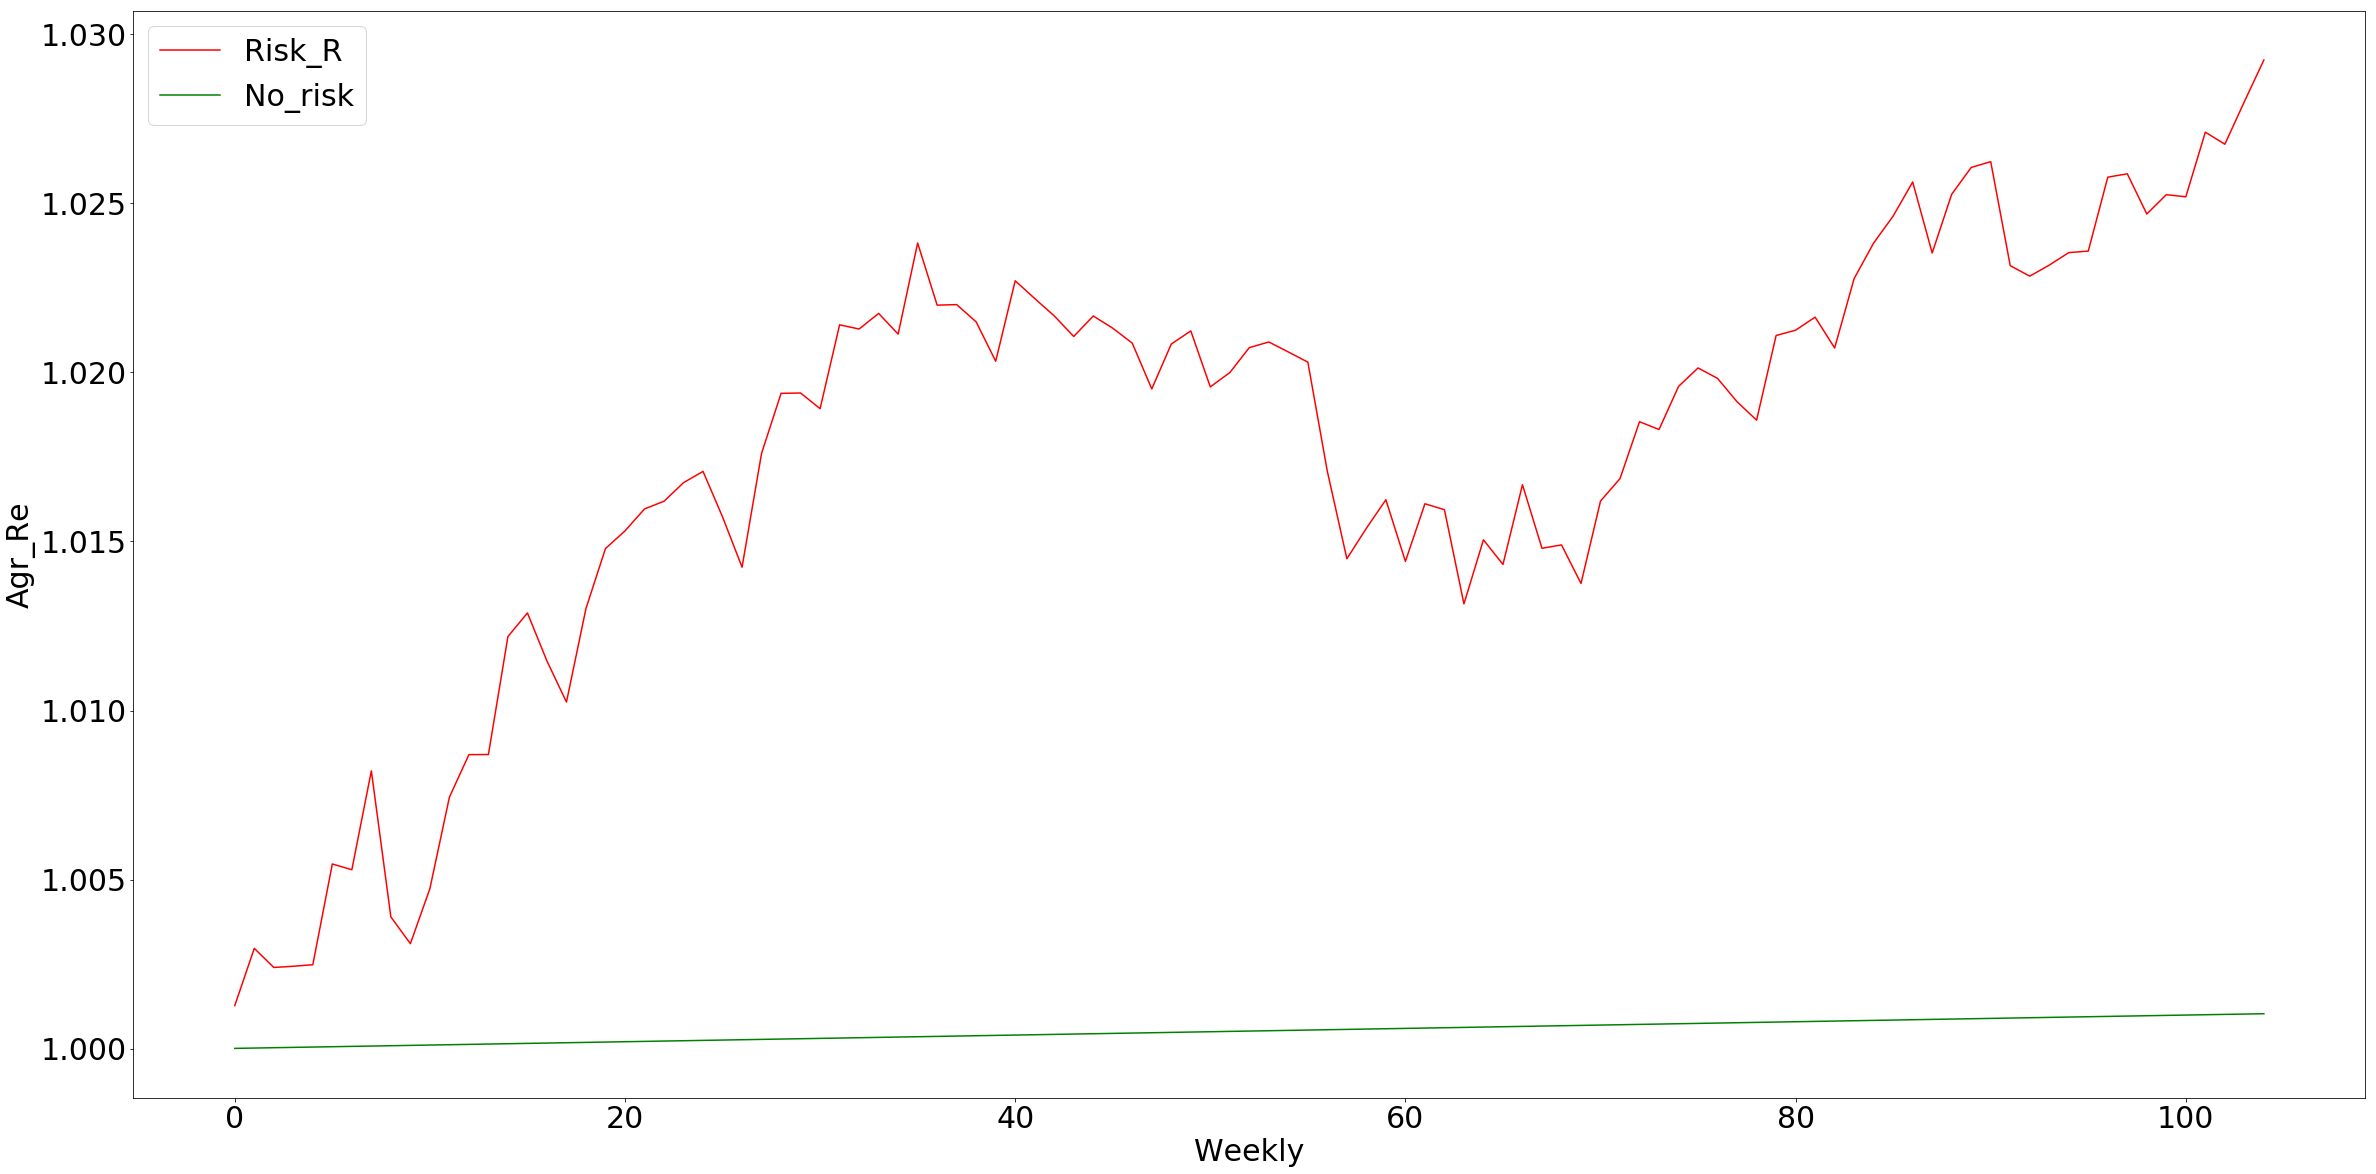

In [51]:
plt.figure(figsize=(40,20))
plt.plot(agr_val,'r',label = 'Risk_R')
plt.plot(agr_norisk,'g',label = 'No_risk')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Weekly',fontsize= 30)
plt.ylabel('Agr_Re',fontsize=30)
plt.legend(fontsize=30)

In [28]:
test.to_csv('Weekly_RE.csv')

In [38]:
pd.DataFrame(agr_norisk).to_csv('weekly_norisk.csv')

In [30]:
test02 = pd.DataFrame(agrval)

NameError: name 'agrval' is not defined

In [31]:
month_re = []
month_agr = []
month_agr_sp = []
for i in range(0,106,4):
    month_re.append(test.iloc[i])
    month_agr.append(agr_val[i])
    month_agr_sp.append(agr_val_sp[i])

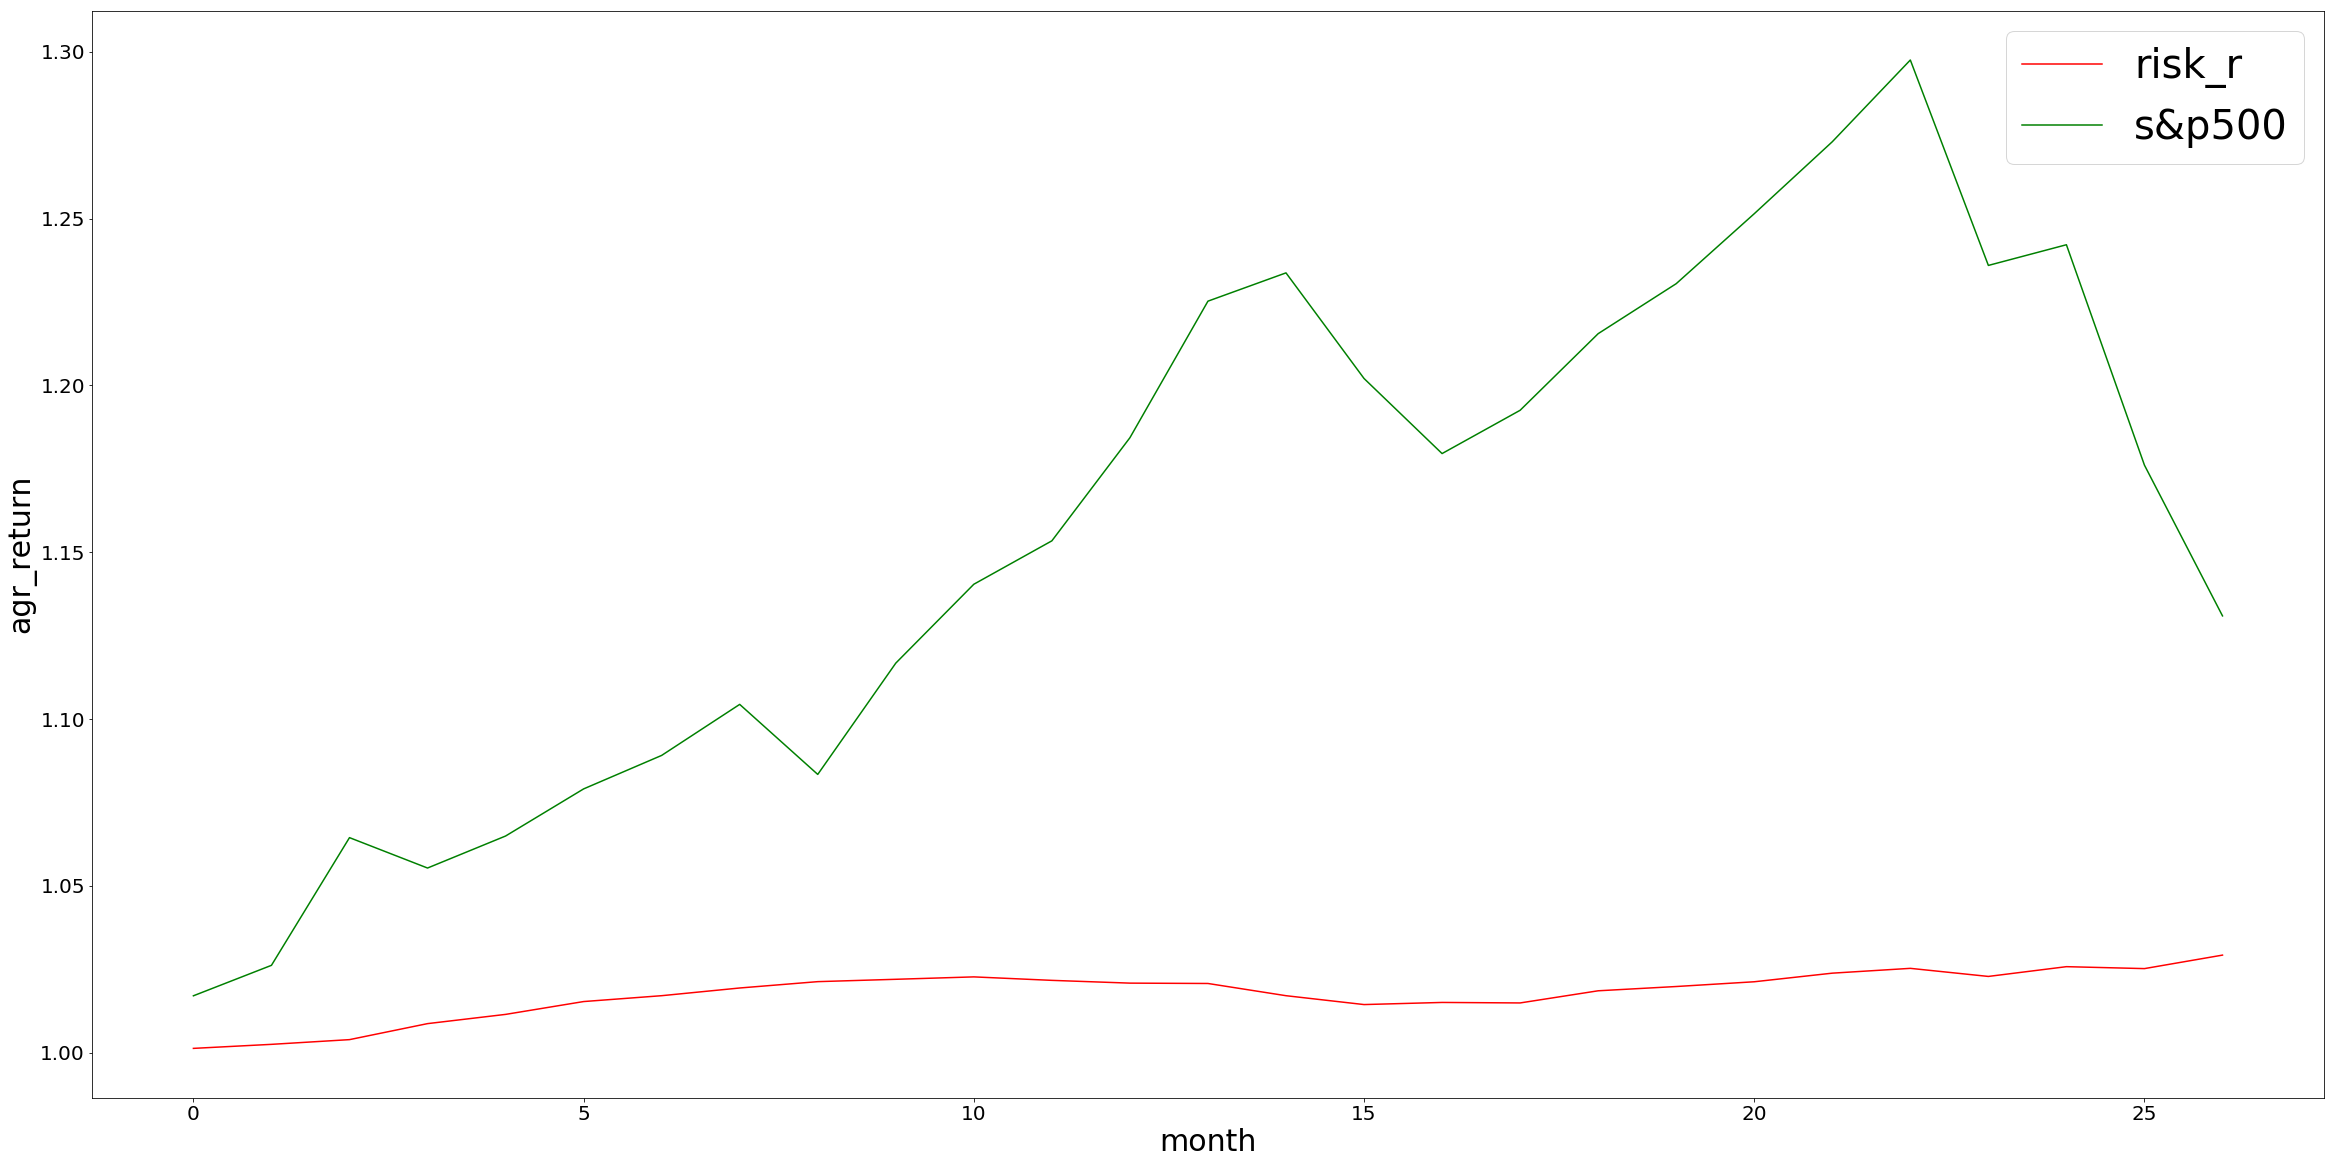

In [32]:
plt.figure(figsize=(40,20))
plt.plot(month_agr,'r',label = 'risk_r')
plt.plot(month_agr_sp,'g',label='s&p500')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('month',fontsize=30)
plt.ylabel('agr_return', fontsize=30)
plt.legend(fontsize=40)

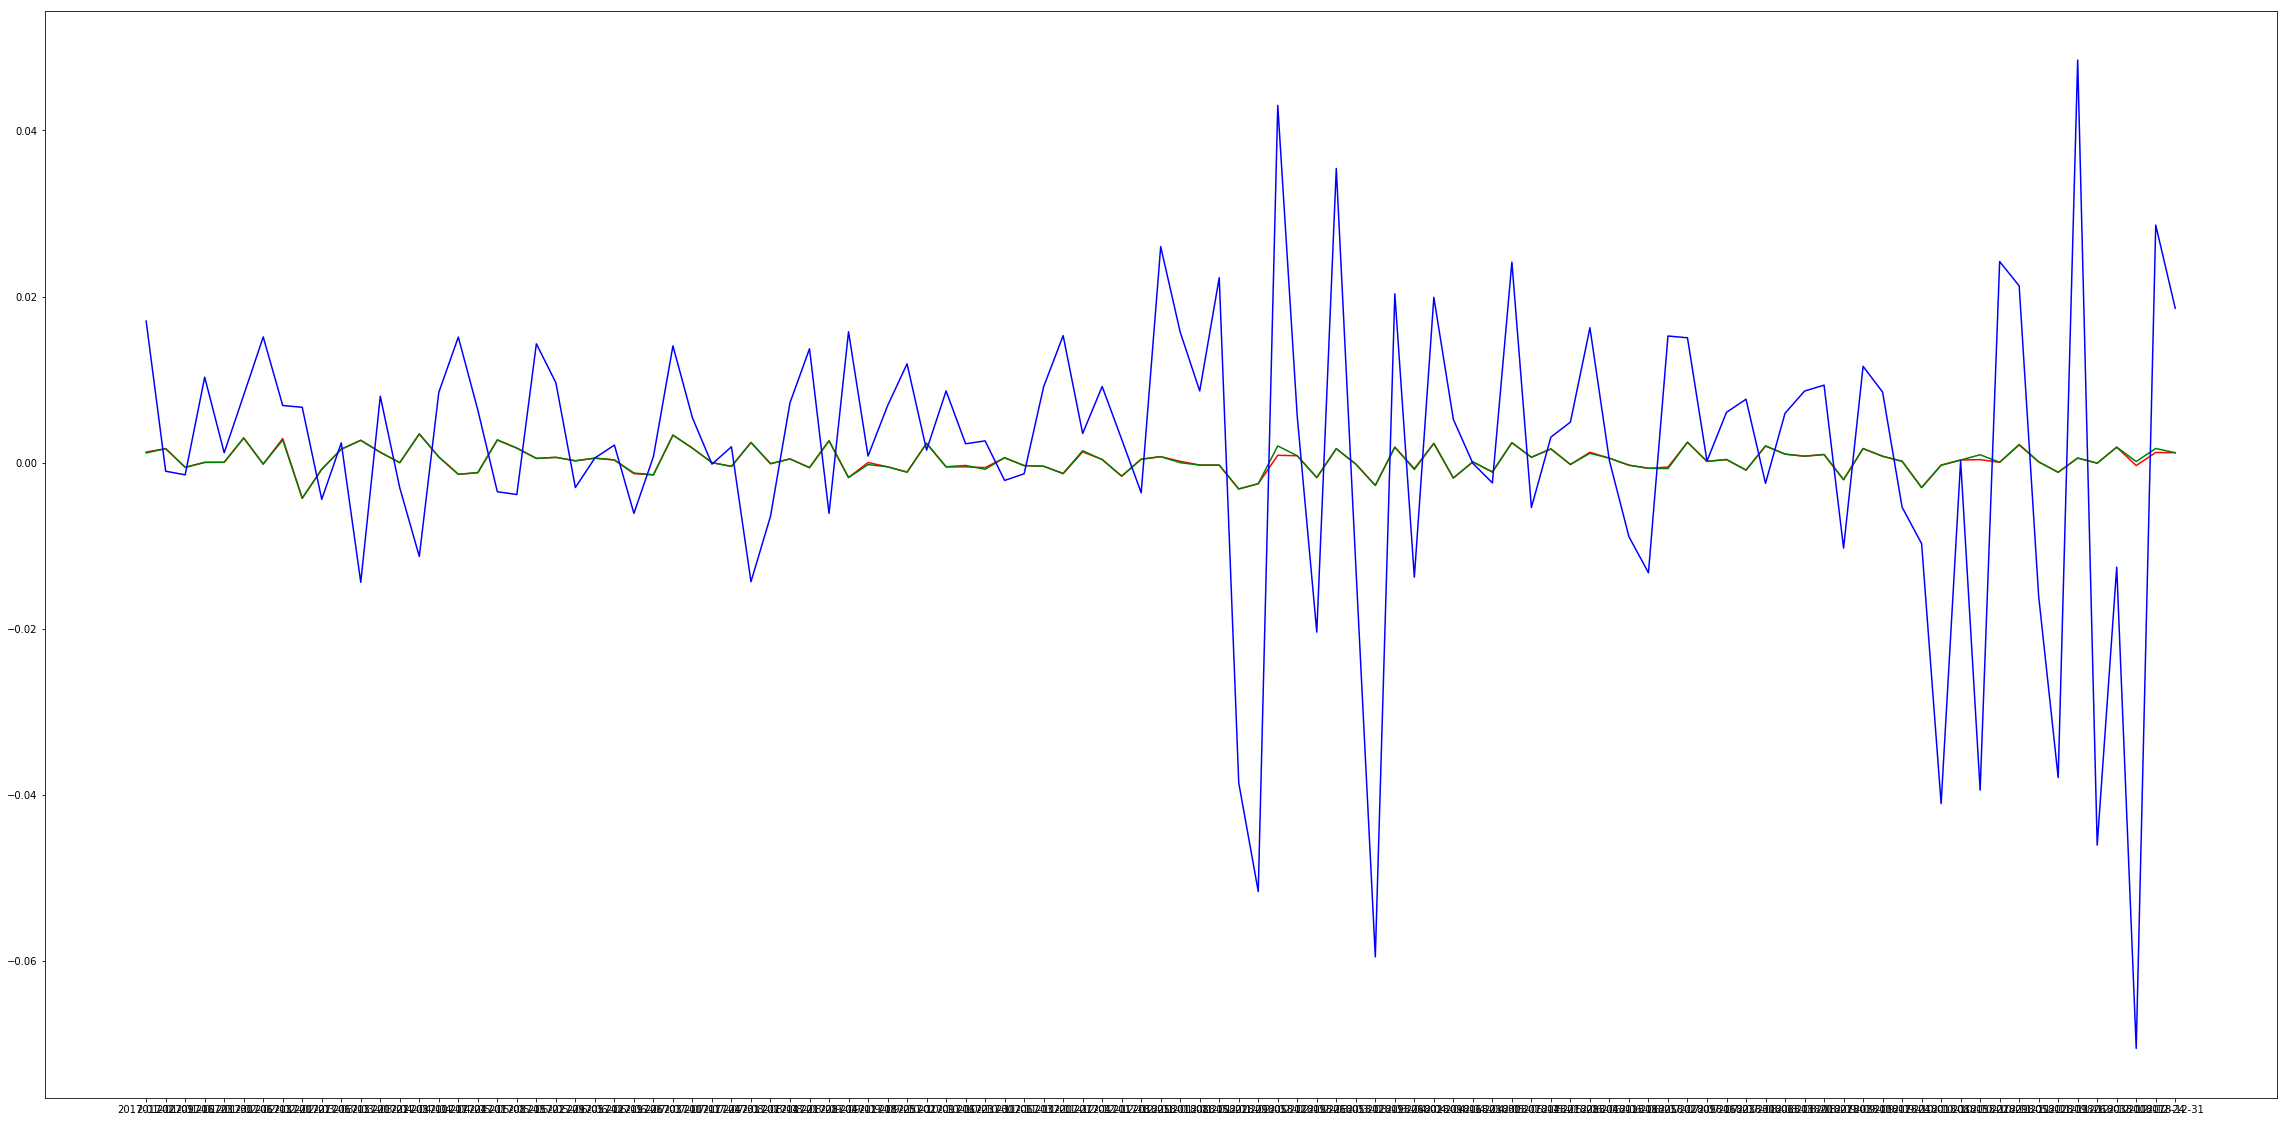

In [33]:
plt.figure(figsize=(40,20))
plt.plot(test,'r')
plt.plot(test01,'g')
plt.plot(sp500_re,'b')

In [34]:
print(test.mean(),test01.mean(),sp500_re.mean())

0    0.000276
dtype: float64 0    0.000293
dtype: float64 0    0.001349
dtype: float64


In [20]:
sp500 = pd.read_csv("C:\\Users\\USER\\Desktop\\^GSPC (3).csv")

In [21]:
sp500_1 = sp500[sp500['Date']>'2016-12-25']
sp500_2 = sp500_1[sp500_1['Date']<='2018-12-31']

In [22]:
return_sp500 = []
sp500_list = sp500_2['Adj Close'].tolist()
for i in range(len(sp500_2)-1) :
    return_sp500.append((sp500_list[i+1] - sp500_list[i]) / sp500_list[i])

In [23]:
sp500_re = pd.DataFrame(return_sp500)

In [24]:
sp500_re.iloc[0,:]

0    0.01704
Name: 0, dtype: float64

In [52]:
test.to_csv('risk_r_RE_weekly.csv')

In [54]:
sp500_re.to_csv('sp500_weekly.csv')